In [88]:
import warnings
warnings.filterwarnings('ignore')

import pickle

import sys
sys.path.append('/home/rupali/Documents/Master Thesis/jenga')

In [2]:
import random
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from jenga.basis import Dataset
from jenga.corruptions.generic import MissingValues, SwappedValues, CategoricalShift
from jenga.corruptions.numerical import Scaling, GaussianNoise
from jenga.cleaning.ppp import PipelinePerformancePrediction
from jenga.cleaning.outlier_detection import NoOutlierDetection, PyODKNNOutlierDetection, PyODIsolationForestOutlierDetection, PyODPCAOutlierDetection, PyODCBLOFOutlierDetection, PyODSOSOutlierDetection, SklearnOutlierDetection
from jenga.cleaning.imputation import MeanModeImputation, SklearnImputation, DatawigImputation
from jenga.cleaning.clean import Clean

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
## use categorical columns as strings
def cat_cols_to_str(df):
    for col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            df[col] = df[col].astype(str)

    return df

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def run_experiment(dataset_name, learner, param_grid, corruptions, fraction, cleaners, num_repetitions, categorical_precision_threshold=0.85, numerical_std_error_threshold=0.9):
    
    ## dataset
    dataset = Dataset(dataset_name)
    
    all_data = dataset.all_data
    attribute_names = dataset.attribute_names
    attribute_types = dataset.attribute_types
    
    ## categorical and numerical features
    categorical_columns = dataset.categorical_columns
    numerical_columns = dataset.numerical_columns
    print(f"Found {len(categorical_columns)} categorical and {len(numerical_columns)} numeric features \n")
    
    ## train and test data
    df_train, lab_train, df_test, lab_test = dataset.get_train_test_data()
    ### if we don't convert the categorical columns to str, the swapping corruption doesn't let us assign new values to the column: "Cannot setitem on a Categorical with a new category, set the categories first"
    df_train = cat_cols_to_str(df_train)
    df_test = cat_cols_to_str(df_test)
    
    ## pipeline performance prediction (ppp)
    ppp = PipelinePerformancePrediction(df_train, lab_train, df_test, lab_test, categorical_columns, numerical_columns, learner, param_grid)
    ppp_model = ppp.fit_ppp(df_train)
    ## the class column is added to the training data for Autogluon model fit
    if learner == None:
        df_train = df_train.loc[:, df_train.columns != 'class']
    
    ## generate corrupted data
    for _ in range(num_repetitions):
        df_corrupted, perturbations, cols_perturbed, summary_col_corrupt = ppp.get_corrupted(df_test, corruptions, fraction, num_repetitions)
    
    ## cleaning
    clean = Clean(df_train, df_corrupted, categorical_columns, numerical_columns, categorical_precision_threshold, numerical_std_error_threshold, ppp, ppp_model, cleaners)
    df_outliers, df_cleaned, corrupted_score_ppp, best_cleaning_score, cleaner_scores_ppp, summary_cleaners = clean(df_train, df_test, df_corrupted, cols_perturbed)
    
    ## results
    result = {
        'ppp_score_model': ppp.predict_score_ppp(ppp_model, df_test),
        'ppp_score_corrupted': corrupted_score_ppp,
        'ppp_score_cleaned': best_cleaning_score,
        'ppp_scores_cleaners': cleaner_scores_ppp
    }
#     print('\n'.join([f'{key}:{val}' for key, val in result.items()]))
    
    ## summary
    summary = {
        'dataset': dataset_name,
        'model': learner,
        'corruptions': summary_col_corrupt,
        'cleaners': summary_cleaners,
        'result': result
    }
#     print('\n\n\n\n'.join([f'{key}:{val}' for key, val in summary.items()]))
    
    return summary #summary_col_corrupt, result

### Altogether

In [5]:
datasets = [
    'thoracic_surgery',
    'cleve',
    'acute-inflammations'
#     'hill-valley'
]

In [6]:
## model parameters
## models is a dict where key = leaner & value = param_grid
models = {SGDClassifier(loss='log'): {'learner__max_iter': [500, 1000, 5000], 
                                         'learner__penalty': ['l2', 'l1', 'elasticnet'], 
                                         'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
                                        } 
#           RandomForestClassifier():{'learner__n_estimators': [100, 200, 500], 
#                                     'learner__max_depth': [5, 10, 15]
#                                    }
         }

## make dict of multiple leraners and corresponding param_grids

In [7]:
corruptions = [[MissingValues, Scaling, CategoricalShift, GaussianNoise]] #SwappedValues

In [8]:
fractions = [0.15, 0.25, 0.5, 0.75, 0.9]

In [9]:
cleaners = []
for od in [NoOutlierDetection, PyODKNNOutlierDetection, PyODIsolationForestOutlierDetection, PyODPCAOutlierDetection, PyODCBLOFOutlierDetection, PyODSOSOutlierDetection, SklearnOutlierDetection]:
    for imp in [MeanModeImputation, SklearnImputation, DatawigImputation]:
        cleaners.append((od, imp))

In [10]:
# stdoutOrigin=sys.stdout 
# sys.stdout = open("/home/rupali/Documents/Master Thesis/jenga/out/experiments.txt", "w")

# for _ in range(10):
#   print("\n\n..................................ITERATION..................................\n")
ind_results = {}

for fraction in fractions:
    ind_results[fraction] = []
    for learner, param_grid in models.items():
        for corruption in corruptions:
            for dataset in datasets:
                try:
                    ind_results[fraction].append(run_experiment(dataset, learner, param_grid, corruption, fraction, cleaners, 5))
                except ConnectionError:
                    print(f'Connection refused for dataset: {dataset}')
                    continue
                except ValueError:
                    print("Something went wrong with a value :(")
                    continue
        
# sys.stdout.close()
# sys.stdout=stdoutOrigin

Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
2021-04-17 16:29:37,362 [INFO]  Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
0.2708650s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
2021-04-17 16:29:37,636 [INFO]  0.2708650s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
pickle load data thoracic_surgery
2021-04-17 16:29:37,651 [INFO]  pickle load data thoracic_surgery
NumExpr defaulting to 4 threads.
2021-04-17 16:29:37,677 [INFO]  NumExpr defaulting to 4 threads.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.2s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined 


Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE25', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE14', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE8', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'PRE7', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scal

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8166666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.45081517160944373
Regressor for col: PRE4/median reached 0.6942821386470028
Regressor for col: PRE4/upper reached 0.3941287457942422
Regressor for col: PRE5/lower reached -0.03633891203093098
Regressor for col: PRE5/median reached 0.007759070447129368
Regressor for col: PRE5/upper reached -0.22961957755440834
Regressor for col: AGE/lower reached -1.0957376262216427
Regressor for col: AGE/median reached 0.03614083888787073


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -1.1175977298400293
Imputed 14 values in column PRE10

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.425531914893617, 'Recall': 0.5, 'F1-score': 0.4597701149425288, 'Accuracy': 0.851063829787234}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.8461910070605723, 'Recall': 0.9135980494601184, 'F1-score': 0.8368408561059437, 'Accuracy': 0.9042553191489362, 'Mean Squared Error': 2438556.762754937}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.6607017543859649, 'classification_report': {'F': {'precision': 0.8481012658227848, 'recall': 0.8933333333333333, 'f1-score': 0.8701298701298702, 'support': 75}, 'T': {'precision': 0.4666666666666667, 'recall': 0.3684210526315789, 'f1-score': 0.4117647058823529, 'support': 19}, 'accuracy': 0.7872340425531915, 'macro avg': {'precision': 0.6573839662447257, 'recall': 0.6308771929824561, 'f1-score': 0.6409472880061116, 'support': 9

Test set does not contain any ocurrences of values [DGN1] in column [DGN], consider using a more representative test set.
2021-04-17 16:29:53,330 [WARNING]  Test set does not contain any ocurrences of values [DGN1] in column [DGN], consider using a more representative test set.

========== start: fit model
2021-04-17 16:29:53,346 [INFO]  
========== start: fit model
Already bound, ignoring bind()
2021-04-17 16:29:53,347 [WARNING]  Already bound, ignoring bind()
Epoch[0] Batch [0-11]	Speed: 1316.44 samples/sec	cross-entropy=1.384766	DGN-accuracy=0.661458
2021-04-17 16:29:53,537 [INFO]  Epoch[0] Batch [0-11]	Speed: 1316.44 samples/sec	cross-entropy=1.384766	DGN-accuracy=0.661458
Epoch[0] Train-cross-entropy=1.104814
2021-04-17 16:29:53,672 [INFO]  Epoch[0] Train-cross-entropy=1.104814
Epoch[0] Train-DGN-accuracy=0.724432
2021-04-17 16:29:53,673 [INFO]  Epoch[0] Train-DGN-accuracy=0.724432
Epoch[0] Time cost=0.321
2021-04-17 16:29:53,674 [INFO]  Epoch[0] Time cost=0.321
Saved checkpoint t

Epoch[8] Validation-cross-entropy=0.703466
2021-04-17 16:29:56,769 [INFO]  Epoch[8] Validation-cross-entropy=0.703466
Epoch[8] Validation-DGN-accuracy=0.791667
2021-04-17 16:29:56,771 [INFO]  Epoch[8] Validation-DGN-accuracy=0.791667
Epoch[9] Batch [0-11]	Speed: 1197.67 samples/sec	cross-entropy=0.819718	DGN-accuracy=0.713542
2021-04-17 16:29:56,942 [INFO]  Epoch[9] Batch [0-11]	Speed: 1197.67 samples/sec	cross-entropy=0.819718	DGN-accuracy=0.713542
Epoch[9] Train-cross-entropy=0.759911
2021-04-17 16:29:57,111 [INFO]  Epoch[9] Train-cross-entropy=0.759911
Epoch[9] Train-DGN-accuracy=0.750000
2021-04-17 16:29:57,113 [INFO]  Epoch[9] Train-DGN-accuracy=0.750000
Epoch[9] Time cost=0.342
2021-04-17 16:29:57,114 [INFO]  Epoch[9] Time cost=0.342
Saved checkpoint to "imputer_model/model-0009.params"
2021-04-17 16:29:57,123 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
Epoch[9] Validation-cross-entropy=0.701963
2021-04-17 16:29:57,158 [INFO]  Epoch[9] Validation-cross-entropy=0

Epoch[17] Validation-DGN-accuracy=0.791667
2021-04-17 16:30:00,048 [INFO]  Epoch[17] Validation-DGN-accuracy=0.791667
Epoch[18] Batch [0-11]	Speed: 1111.35 samples/sec	cross-entropy=0.796186	DGN-accuracy=0.718750
2021-04-17 16:30:00,225 [INFO]  Epoch[18] Batch [0-11]	Speed: 1111.35 samples/sec	cross-entropy=0.796186	DGN-accuracy=0.718750
Epoch[18] Train-cross-entropy=0.738303
2021-04-17 16:30:00,379 [INFO]  Epoch[18] Train-cross-entropy=0.738303
Epoch[18] Train-DGN-accuracy=0.755682
2021-04-17 16:30:00,380 [INFO]  Epoch[18] Train-DGN-accuracy=0.755682
Epoch[18] Time cost=0.333
2021-04-17 16:30:00,382 [INFO]  Epoch[18] Time cost=0.333
Saved checkpoint to "imputer_model/model-0018.params"
2021-04-17 16:30:00,391 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
Epoch[18] Validation-cross-entropy=0.691903
2021-04-17 16:30:00,426 [INFO]  Epoch[18] Validation-cross-entropy=0.691903
Epoch[18] Validation-DGN-accuracy=0.791667
2021-04-17 16:30:00,427 [INFO]  Epoch[18] Validation-DG

Epoch[27] Batch [0-11]	Speed: 1266.43 samples/sec	cross-entropy=0.781023	DGN-accuracy=0.713542
2021-04-17 16:30:03,454 [INFO]  Epoch[27] Batch [0-11]	Speed: 1266.43 samples/sec	cross-entropy=0.781023	DGN-accuracy=0.713542
Epoch[27] Train-cross-entropy=0.722855
2021-04-17 16:30:03,583 [INFO]  Epoch[27] Train-cross-entropy=0.722855
Epoch[27] Train-DGN-accuracy=0.752841
2021-04-17 16:30:03,584 [INFO]  Epoch[27] Train-DGN-accuracy=0.752841
Epoch[27] Time cost=0.289
2021-04-17 16:30:03,585 [INFO]  Epoch[27] Time cost=0.289
Saved checkpoint to "imputer_model/model-0027.params"
2021-04-17 16:30:03,594 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
Epoch[27] Validation-cross-entropy=0.685004
2021-04-17 16:30:03,630 [INFO]  Epoch[27] Validation-cross-entropy=0.685004
Epoch[27] Validation-DGN-accuracy=0.791667
2021-04-17 16:30:03,631 [INFO]  Epoch[27] Validation-DGN-accuracy=0.791667
Epoch[28] Batch [0-11]	Speed: 1253.80 samples/sec	cross-entropy=0.779452	DGN-accuracy=0.713542
202

2021-04-17 16:30:06,769 [INFO]  Epoch[36] Batch [0-11]	Speed: 993.56 samples/sec	cross-entropy=0.768406	DGN-accuracy=0.718750
Epoch[36] Train-cross-entropy=0.710360
2021-04-17 16:30:06,906 [INFO]  Epoch[36] Train-cross-entropy=0.710360
Epoch[36] Train-DGN-accuracy=0.755682
2021-04-17 16:30:06,909 [INFO]  Epoch[36] Train-DGN-accuracy=0.755682
Epoch[36] Time cost=0.336
2021-04-17 16:30:06,910 [INFO]  Epoch[36] Time cost=0.336
Saved checkpoint to "imputer_model/model-0036.params"
2021-04-17 16:30:06,921 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
Epoch[36] Validation-cross-entropy=0.681599
2021-04-17 16:30:06,957 [INFO]  Epoch[36] Validation-cross-entropy=0.681599
Epoch[36] Validation-DGN-accuracy=0.791667
2021-04-17 16:30:06,959 [INFO]  Epoch[36] Validation-DGN-accuracy=0.791667
Epoch[37] Batch [0-11]	Speed: 1241.36 samples/sec	cross-entropy=0.767351	DGN-accuracy=0.718750
2021-04-17 16:30:07,122 [INFO]  Epoch[37] Batch [0-11]	Speed: 1241.36 samples/sec	cross-entropy=0.7

Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.425531914893617, 'Recall': 0.5, 'F1-score': 0.4597701149425288, 'Accuracy': 0.851063829787234}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8363782051282052, 'Recall': 0.8877359804946012, 'F1-score': 0.8157346130736931, 'Accuracy': 0.8882978723404256, 'Mean Squared Error': 2438556.762754937}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6607017543859649, 'classification_report': {'F': {'precision': 0.8481012658227848, 'recall': 0.8933333333333333, 'f1-score': 0.8701298701298702, 'support': 75}, 'T': {'precision': 0.4666666666666667, 'recall': 0.3684210526315789, 'f1-score': 0.4117647058823529, 'support': 19}, 'accuracy': 0.7872340425531915, 'macro avg': {'precision': 0.6573839662447257, 'recall': 0.6308771929824561, 'f1-score': 0.6409472880061116, 'support': 94}, 'weighted avg': {'precision': 0.7710027830146332, 'recall': 0.7872340425531915, 'f1-sco

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7507432480836735, 'Recall': 0.8421875000000001, 'F1-score': 0.7798972354792625, 'Accuracy': 0.9069148936170213}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8163799632154063, 'Recall': 0.8273911529083943, 'F1-score': 0.7589710510906164, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 113.53707766453334}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.463859649122807, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7033333333333334
Classifier for col: PRE6 reached 0.8533333333333333
Classifier for col: PRE7 reached 0.9299999999999999
Classifier for col: PRE8 reached 0.8166666666666667
Classifier for col: PRE9 reached 0.94
Classifier for col: PRE10 reached 0.9133333333333333
Classifier for col: PRE11 reached 0.8733333333333333
Classifier for col: PRE14 reached 0.52
Classifier for col: PRE17 reached 0.9299999999999999


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3999103538415956
Regressor for col: PRE4/median reached 0.6896169034041546
Regressor for col: PRE4/upper reached 0.3990294296074604
Regressor for col: PRE5/lower reached -0.04555843639225754
Regressor for col: PRE5/median reached -0.03378441370284868
Regressor for col: PRE5/upper reached -0.7922474776914396
Regressor for col: AGE/lower reached -0.8225191203964428
Regressor for col: AGE/median reached 0.04523902583170997
Regressor for col: AGE/upper reached -0.937149807983648
Imputed 14 values in column PRE10
Imputed 11 values in column PRE4
Imputed 22 values in column PRE5
Imputed 27 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7507432480836735, 'Recall': 0.8421875000000001, 'F1-score': 0.7798972354792625, 'Accuracy': 0.9069148936170213}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.8461910070605723, 'Recall': 0.9135980494601184, 'F1-score': 0.836840856

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7507432480836735, 'Recall': 0.8421875000000001, 'F1-score': 0.7798972354792625, 'Accuracy': 0.9069148936170213}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8395570001203805, 'Recall': 0.8963566701497736, 'F1-score': 0.8229464955807666, 'Accuracy': 0.8936170212765957, 'Mean Squared Error': 107.72286688449104}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4659649122807017, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6998658847063102, 'Recall': 0.8015625, 'F1-score': 0.7079045802046565, 'Accuracy': 0.8377659574468086}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8163799632154063, 'Recall': 0.8273911529083943, 'F1-score': 0.7589710510906164, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 120.05196744615459}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.4561403508771929, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'supp

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7
Classifier for col: PRE6 reached 0.85
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.8433333333333333
Classifier for col: PRE9 reached 0.9333333333333333
Classifier for col: PRE10 reached 0.89
Classifier for col: PRE11 reached 0.8366666666666667
Classifier for col: PRE14 reached 0.5266666666666666
Classifier for col: PRE17 reached 0.9266666666666666
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8466666666666667
Classifier for col: PRE32 reached 0.9933333333333333
Regressor for col: PRE4/lower reached 0.3939264631189695
Regressor for col: PRE4/median reached 0.6922123043799587
Regressor for col: PRE4/upper reached 0.3687132331230365
Regressor for col: PRE5/lower reached -0.04526061794250802
Regressor for col: PRE5/median reached -0.03314288953068745
Regressor for col: PRE5/upper reached -0.6003294995935207
Regressor for col: AGE/lower reached -1.0059613188698338
Regress

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6998658847063102, 'Recall': 0.8015625, 'F1-score': 0.7079045802046565, 'Accuracy': 0.8377659574468086}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8428266178266178, 'Recall': 0.904977359804946, 'F1-score': 0.8299778962719898, 'Accuracy': 0.898936170212766, 'Mean Squared Error': 110.67343460173304}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.45754385964912275, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'suppor

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.69056896662663, 'Recall': 0.7709821428571428, 'F1-score': 0.7064270858451893, 'Accuracy': 0.8484042553191489}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8163799632154063, 'Recall': 0.8273911529083943, 'F1-score': 0.7589710510906164, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 121.58266995229334}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.44491228070175437, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6866666666666666
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.9233333333333333
Classifier for col: PRE8 reached 0.8333333333333333
Classifier for col: PRE9 reached 0.9299999999999999
Classifier for col: PRE10 reached 0.8866666666666667
Classifier for col: PRE11 reached 0.8666666666666667
Classifier for col: PRE14 reached 0.47333333333333333
Classifier for col: PRE17 reached 0.9199999999999999
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8300000000000001
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3360739623394345
Regressor for col: PRE4/median reached 0.7177961148158403
Regressor for col: PRE4/upper reached 0.4013842548514273
Regressor for col: PRE5/lower reached -0.04941960949671276
Regressor for col: PRE5/median reached -0.027487403668256527
Regressor for col: PRE5/upper reached -0.5196711910509447
Regressor for col: AGE/lower reached -0.6676050954535128
Regressor for col: AGE/median reached 0.11625928007918834
Regressor for col: AGE/upper reached -0.9856887718707155
Imputed 14 values in column PRE10
Imputed 20 values in column PRE4
Imputed 30 values in column PRE5
Imputed 31 values in column AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.69056896662663, 'Recall': 0.7709821428571428, 'F1-score': 0.7064270858451893, 'Accuracy': 0.8484042553191489}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.8496543489190549, 'Recall': 0.9222187391152908, 'F1-score': 0.843546599

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.69056896662663, 'Recall': 0.7709821428571428, 'F1-score': 0.7064270858451893, 'Accuracy': 0.8484042553191489}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8428266178266178, 'Recall': 0.904977359804946, 'F1-score': 0.8299778962719898, 'Accuracy': 0.898936170212766, 'Mean Squared Error': 116.97281321092832}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4252631578947368, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6985520708924964, 'Recall': 0.8, 'F1-score': 0.7054741659570788, 'Accuracy': 0.8351063829787233}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8163799632154063, 'Recall': 0.8273911529083943, 'F1-score': 0.7589710510906164, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 114.80203859615268}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.4666666666666667, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7066666666666667
Classifier for col: PRE6 reached 0.8366666666666667
Classifier for col: PRE7 reached 0.9133333333333333
Classifier for col: PRE8 reached 0.8566666666666667
Classifier for col: PRE9 reached 0.9299999999999999
Classifier for col: PRE10 reached 0.89
Classifier for col: PRE11 reached 0.8533333333333334
Classifier for col: PRE14 reached 0.5233333333333334
Classifier for col: PRE17 reached 0.91


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8233333333333333
Classifier for col: PRE32 reached 0.99
Regressor for col: PRE4/lower reached 0.36679822961896785
Regressor for col: PRE4/median reached 0.7299116535268397
Regressor for col: PRE4/upper reached 0.3935171328678949
Regressor for col: PRE5/lower reached -0.030985612190072676
Regressor for col: PRE5/median reached 0.0439251639788617
Regressor for col: PRE5/upper reached -0.30063739241657916
Regressor for col: AGE/lower reached -0.9603536347333383
Regressor for col: AGE/median reached 0.13021458606731368
Regressor for col: AGE/upper reached -1.121429250153611
Imputed 14 values in column PRE10
Imputed 27 values in column PRE4
Imputed 34 values in column PRE5
Imputed 32 values in column AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7125410669586985, 'Recall': 0.815625, 'F1-score': 0.73024393864436, 'Accuracy': 0.8

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.699732907599649, 'Recall': 0.8015625, 'F1-score': 0.707833447034451, 'Accuracy': 0.8377659574468085}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8428266178266178, 'Recall': 0.904977359804946, 'F1-score': 0.8299778962719898, 'Accuracy': 0.898936170212766, 'Mean Squared Error': 107.82285383610558}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.46807017543859647, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5691489361702128, 'Recall': 0.625, 'F1-score': 0.5948275862068966, 'Accuracy': 0.8882978723404255}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8163799632154063, 'Recall': 0.8273911529083943, 'F1-score': 0.7589710510906164, 'Accuracy': 0.851063829787234, 'Mean Squared Error': 2438556.762754937}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6607017543859649, 'classification_report': {'F': {'precision': 0.8481012658227848, 'recall': 0.8933333333333333, 'f1-score': 0.8701298701298702, 'support': 75}, 'T': {'precision': 0.4666666666666667, 'recall': 0.3684210526315789, 'f1-score': 0.4117647058823529, 'support': 19}, 'accuracy': 0.7872340425531915, 'macro avg': {'precision': 0.6573839662447257, 'recall': 0.6308771929824561, 'f1-score': 0.6409472880061116, 'support': 94}, 'weighted avg': {'precision': 0.7710027830146332, 'recall': 0.7872340425

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6799999999999999
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.94
Classifier for col: PRE8 reached 0.8233333333333333
Classifier for col: PRE9 reached 0.9333333333333333
Classifier for col: PRE10 reached 0.89
Classifier for col: PRE11 reached 0.8566666666666667
Classifier for col: PRE14 reached 0.51
Classifier for col: PRE17 reached 0.9366666666666666


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8433333333333333
Classifier for col: PRE32 reached 0.99
Regressor for col: PRE4/lower reached 0.22650820437207153
Regressor for col: PRE4/median reached 0.6720722242754984
Regressor for col: PRE4/upper reached 0.34483451782626284
Regressor for col: PRE5/lower reached -0.04497721025181389
Regressor for col: PRE5/median reached -0.036515044591563406
Regressor for col: PRE5/upper reached -0.31499315318563514
Regressor for col: AGE/lower reached -1.0749170656691907
Regressor for col: AGE/median reached 0.07169874825786143
Regressor for col: AGE/upper reached -1.1116364509075243
Imputed 14 values in column PRE10

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5691489361702128, 'Recall': 0.625, 'F1-score': 0.5948275862068966, 'Accuracy': 0.8882978723404255}
Imputation method: SklearnImputation, Imputation Score: {'Precisio

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5691489361702128, 'Recall': 0.625, 'F1-score': 0.5948275862068966, 'Accuracy': 0.8882978723404255}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8273504273504273, 'Recall': 0.8618739115290839, 'F1-score': 0.7928815850011502, 'Accuracy': 0.8723404255319149, 'Mean Squared Error': 2438556.762754937}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6607017543859649, 'classification_report': {'F': {'precision': 0.8481012658227848, 'recall': 0.8933333333333333, 'f1-score': 0.8701298701298702, 'support': 75}, 'T': {'precision': 0.4666666666666667, 'recall': 0.3684210526315789, 'f1-score': 0.4117647058823529, 'support': 19}, 'accuracy': 0.7872340425531915, 'macro avg': {'precision': 0.6573839662447257, 'recall': 0.6308771929824561, 'f1-score': 0.6409472880061116, 'support': 94}, 'weighted avg': {'precision': 0.7710027830146332, 'recall': 0.78723404255

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.4586702889467321
Regressor for col: PRE4/median reached 0.6961122274035563
Regressor for col: PRE4/upper reached 0.4210793213441429
Regressor for col: PRE5/lower reached -0.053039429294533535
Regressor for col: PRE5/median reached -0.15122809015012578
Regressor for col: PRE5/upper reached -0.24428736902081438
Regressor for col: AGE/lower reached -1.0460375313674415
Regressor for col: AGE/median reached -0.009143893743665754
Regressor for col: AGE/upper reached -1.052222520750326
Column DGN contained 0 nans before, now 28
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 14 nans before, now 21
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 0
Column PRE25 contained 0 nans before, n

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7233333333333334
Classifier for col: PRE6 reached 0.8333333333333334
Classifier for col: PRE7 reached 0.9233333333333333
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9266666666666667
Classifier for col: PRE10 reached 0.8933333333333333
Classifier for col: PRE11 reached 0.8666666666666667
Classifier for col: PRE14 reached 0.5133333333333334
Classifier for col: PRE17 reached 0.9299999999999999
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9666666666666667
Classifier for col: PRE30 reached 0.8233333333333334
Classifier for col: PRE32 reached 0.9866666666666666
Regressor for col: PRE4/lower reached 0.2984546021765721
Regressor for col: PRE4/median reached 0.6757320831320804
Regressor for col: PRE4/upper reached 0.3632708362996881
Regressor for col: PRE5/lower reached -0.050126874224354245
Regressor for col: PRE5/median reached -0.009498116964227088
Regressor for col: PRE5/upper reached -0.09372718766579646
Regressor for col: AGE/lower reached -0.8761326790839915
Regressor for col: AGE/median reached 0.10409255186938166
Regressor for col: AGE/upper reached -0.8458785183038414
Column DGN contained 0 nans before, now 0
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 14 nans before, now 24
Column PRE11 contained 0 nans before, now 0
Column PRE14 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7266666666666667
Classifier for col: PRE6 reached 0.8533333333333333
Classifier for col: PRE7 reached 0.9333333333333333
Classifier for col: PRE8 reached 0.8466666666666667
Classifier for col: PRE9 reached 0.9333333333333333
Classifier for col: PRE10 reached 0.89
Classifier for col: PRE11 reached 0.8500000000000001
Classifier for col: PRE14 reached 0.5433333333333333
Classifier for col: PRE17 reached 0.9299999999999999
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.81
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.36794999723914257
Regressor for col: PRE4/median reached 0.7335415391490855
Regressor for col: PRE4/upper reached 0.37350631740392937
Regressor for col: PRE5/lower reached -0.03843729659789463
Regressor for col: PRE5/median reached -0.11840048490393762
Regressor for col: PRE5/upper reached -0.23181162593210392
Regressor for col: AGE/lower reached -0.9989946288006472
Regressor for col: AGE/median reached 0.019831846941709697
Regressor for col: AGE/upper reached -1.035494770351046
Column DGN contained 0 nans before, now 29
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 14 nans before, now 14
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 3
Column PRE25 contained 0 nans before, n

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Starting [get] request for the


Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7020962085829756, 'Recall': 0.8031250000000001, 'F1-score': 0.710827065997549, 'Accuracy': 0.8404255319148937}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8395570001203805, 'Recall': 0.8963566701497736, 'F1-score': 0.8229464955807666, 'Accuracy': 0.8936170212765957, 'Mean Squared Error': 114.44706142408461}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5003508771929825, 'classification_report': {'F': {'precision': 0.7978723404255319, 'recall': 1.0, 'f1-score': 0.8875739644970414, 'support': 75}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.39893617021276595, 'recall': 0.5, 'f1-score': 0.4437869822485207, 'support': 94}, 'weighted avg': {'precision': 0.6366002716161159, 'recall': 0.7978723404255319, 'f1-score': 0.7081707163540224, 'support': 94}}}

Best

INFO:root:0.2233253s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.5s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Cholesterol', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Max_heart_rate', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Resting_ecg', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'Age', 'fraction': 0.15, 'sampling': 'MAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Age', 'fraction': 0.15, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Age', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'Number_of_vessels_colored', 'fraction': 0.15, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'Age', 'fraction': 0.15, 'sampling': 'MNAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Number_of_vessels_colored', 'fraction': 0

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6423432130584192
Regressor for col: Age/lower reached -0.5377011921179488
Regressor for col: Age/median reached 0.2654201280009561
Regressor for col: Age/upper reached -0.45860444437618453
Regressor for col: Trestbps/lower reached -1.0759108631453467
Regressor for col: Trestbps/median reached 0.006925856820392651
Regressor for col: Trestbps/upper reached -1.1510686903034064
Regressor for col: Cholesterol/lower reached -0.8641379300198255
Regressor for col: Cholesterol/median reached -0.08122044250479243
Regressor for col: Cholesterol/upper reached -1.142596517542884
Regressor for col: Max_heart_rate/lower reached -0.2998857845794981
Regressor for col: Max_heart_rate/median reached 0.3320094353746436
Regressor for col: Max_heart_rate/upper reached -0.494198487256032
Regressor for col: Oldpeak/lower reached -0.3784062139295489
Regressor for col: Oldpeak/median reached 0.18794520128495512


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:CategoricalEncoder for column 

Regressor for col: Oldpeak/upper reached -0.5487717447533289
Imputed 9 values in column Age

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.5491803278688524, 'Recall': 0.625, 'F1-score': 0.5819222706015158, 'Accuracy': 0.8483606557377049}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 1322.184512150741}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.7750582750582751, 'classification_report': {'0': {'precision': 0.8157894736842105, 'recall': 0.7948717948717948, 'f1-score': 0.8051948051948051, 'support': 39}, '1': {'precision': 0.6521739130434783, 'recall': 0.6818181818181818, 'f1-score': 0.6666666666666666, 'support': 22}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7339816933638443, 'recall': 0.7383449883449883, 'f1-score': 0.7359307359307359, 'support': 61}, 'weighted avg': {'precision': 0.7567805829613234, '

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1466.83 samples/sec	cross-entropy=0.778689	Sex-accuracy=0.687500
INFO:root:Epoch[0] Train-cross-entropy=0.755543
INFO:root:Epoch[0] Train-Sex-accuracy=0.651786
INFO:root:Epoch[0] Time cost=0.174
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.685787
INFO:root:Epoch[0] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[1] Batch [0-7]	Speed: 1102.86 samples/sec	cross-entropy=0.528667	Sex-accuracy=0.773438
INFO:root:Epoch[1] Train-cross-entropy=0.554394
INFO:root:Epoch[1] Train-Sex-accuracy=0.732143
INFO:root:Epoch[1] Time cost=0.213
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.647738
INFO:root:Epoch[1] Validation-Sex-accuracy=0.625000
INFO:root:Epoch[2] Batch [0-7]	Speed: 1366.16 samples/sec	cross-entropy=0.497131	Sex-accuracy=0.765625
INFO:root:Epoch[2] Train-cross-entropy=0.529579
INFO:r

INFO:root:Epoch[20] Train-cross-entropy=0.417034
INFO:root:Epoch[20] Train-Sex-accuracy=0.772321
INFO:root:Epoch[20] Time cost=0.201
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.467488
INFO:root:Epoch[20] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[21] Batch [0-7]	Speed: 1361.64 samples/sec	cross-entropy=0.371782	Sex-accuracy=0.820312
INFO:root:Epoch[21] Train-cross-entropy=0.413607
INFO:root:Epoch[21] Train-Sex-accuracy=0.772321
INFO:root:Epoch[21] Time cost=0.179
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.464442
INFO:root:Epoch[21] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[22] Batch [0-7]	Speed: 1202.15 samples/sec	cross-entropy=0.368276	Sex-accuracy=0.820312
INFO:root:Epoch[22] Train-cross-entropy=0.410246
INFO:root:Epoch[22] Train-Sex-accuracy=0.776786
INFO:root:Epoch[22] Time cost=0.183
INFO:root:Saved checkpoint to "imputer_model/model-

INFO:root:Epoch[40] Train-Sex-accuracy=0.834821
INFO:root:Epoch[40] Time cost=0.174
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.438729
INFO:root:Epoch[40] Validation-Sex-accuracy=0.781250
INFO:root:Epoch[41] Batch [0-7]	Speed: 1064.12 samples/sec	cross-entropy=0.311219	Sex-accuracy=0.875000
INFO:root:Epoch[41] Train-cross-entropy=0.349490
INFO:root:Epoch[41] Train-Sex-accuracy=0.839286
INFO:root:Epoch[41] Time cost=0.197
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.436750
INFO:root:Epoch[41] Validation-Sex-accuracy=0.781250
INFO:root:Epoch[42] Batch [0-7]	Speed: 1079.88 samples/sec	cross-entropy=0.308976	Sex-accuracy=0.875000
INFO:root:Epoch[42] Train-cross-entropy=0.346734
INFO:root:Epoch[42] Train-Sex-accuracy=0.839286
INFO:root:Epoch[42] Time cost=0.207
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross

Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.5491803278688524, 'Recall': 0.625, 'F1-score': 0.5819222706015158, 'Accuracy': 0.8483606557377049}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 1321.191772664017}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7750582750582751, 'classification_report': {'0': {'precision': 0.8157894736842105, 'recall': 0.7948717948717948, 'f1-score': 0.8051948051948051, 'support': 39}, '1': {'precision': 0.6521739130434783, 'recall': 0.6818181818181818, 'f1-score': 0.6666666666666666, 'support': 22}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7339816933638443, 'recall': 0.7383449883449883, 'f1-score': 0.7359307359307359, 'support': 61}, 'weighted avg': {'precision': 0.7567805829613234, 'recall': 0.7540983606557375, 'f1-score': 0.7552338372010502, 'support': 61}}}

Outlier detec

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9430091185410334, 'Recall': 0.9263888888888889, 'F1-score': 0.933695652173913, 'Accuracy': 0.9508196721311475}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 17.055104210541135}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8135198135198136, 'classification_report': {'0': {'precision': 0.8157894736842105, 'recall': 0.7948717948717948, 'f1-score': 0.8051948051948051, 'support': 39}, '1': {'precision': 0.6521739130434783, 'recall': 0.6818181818181818, 'f1-score': 0.6666666666666666, 'support': 22}, 'accuracy': 0.75

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7881645114942528, 'Recall': 0.8842757936507937, 'F1-score': 0.7932104660045836, 'Accuracy': 0.8360655737704917}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 32.72106093960411}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8065268065268065, 'classification_report': {'0': {'precision': 0.8, 'recall': 0.8205128205128205, 'f1-score': 0.810126582278481, 'support': 39}, '1': {'precision': 0.6666666666666666, 'recall': 0.6363636363636364, 'f1-score': 0.6511627906976744, 'support': 22}, 'accurac

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Number_of_vessels_colored reached 0.5385524054982818
Classifier for col: Thal reached 0.6580756013745704
Regressor for col: Age/lower reached -0.8166725691788931
Regressor for col: Age/median reached 0.07677373474953347
Regressor for col: Age/upper reached -0.6051026176071063
Regressor for col: Trestbps/lower reached -1.034304097452047
Regressor for col: Trestbps/median reached -0.010911525864354565
Regressor for col: Trestbps/upper reached -0.7901244358187766
Regressor for col: Cholesterol/lower reached -0.6881320795628207
Regressor for col: Cholesterol/median reached -0.015552231050343257
Regressor for col: Cholesterol/upper reached -1.004253410265509
Regressor for col: Max_heart_rate/lower reached -0.5923341704083607
Regressor for col: Max_heart_rate/median reached 0.2346094954085044
Regressor for col: Max_heart_rate/upper reached -0.45242671992992056
Regressor for col: Oldpeak/lower reached -0.49913539164672815
Regressor for col: Oldpeak/median reached 0.2616883

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8823198198198199, 'Recall': 0.9131944444444444, 'F1-score': 0.8884146341463415, 'Accuracy': 0.901639344262295}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 19.420278834112175}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8123543123543123, 'classification_report': {'0': {'precision': 0.8157894736842105, 'recall': 0.7948717948717948, 'f1-score': 0.8051948051948051, 'support': 39}, '1': {'precision': 0.6521739130434783, 'recall': 0.6818181818181818, 'f1-score': 0.6666666666666666, 'support': 22}, 'accuracy': 0.75

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7526939655172413, 'Recall': 0.8396825396825396, 'F1-score': 0.7536660808938037, 'Accuracy': 0.7991803278688524}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 32.94417924754393}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8135198135198135, 'classification_report': {'0': {'precision': 0.8205128205128205, 'recall': 0.8205128205128205, 'f1-score': 0.8205128205128205, 'support': 39}, '1': {'precision': 0.6818181818181818, 'recall': 0.6818181818181818, 'f1-score': 0.6818181818181818, 'support': 22}, 'accuracy': 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.8311002522068096, 'Recall': 0.765625, 'F1-score': 0.7816168825447176, 'Accuracy': 0.9221311475409836}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 1326.4476088109154}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.7750582750582751, 'classification_report': {'0': {'precision': 0.8157894736842105, 'recall': 0.7948717948717948, 'f1-score': 0.8051948051948051, 'support': 39}, '1': {'precision': 0.6521739130434783, 'recall': 0.6818181818181818, 'f1-score': 0.6666666666666666, 'support': 22}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7339816933638443, 'recall': 0.7383449883449883, 'f1-score': 0.7359307359307359, 'support': 61}, 'weighted avg': {'precision': 0.7567805829613234, 'recall': 0.7540983606557375, 'f1-score': 0.7552338372010502, 'support': 61}}

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.8311002522068096, 'Recall': 0.765625, 'F1-score': 0.7816168825447176, 'Accuracy': 0.9221311475409836}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 1321.4139527670366}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7750582750582751, 'classification_report': {'0': {'precision': 0.8157894736842105, 'recall': 0.7948717948717948, 'f1-score': 0.8051948051948051, 'support': 39}, '1': {'precision': 0.6521739130434783, 'recall': 0.6818181818181818, 'f1-score': 0.6666666666666666, 'support': 22}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7339816933638443, 'recall': 0.7383449883449883, 'f1-score': 0.7359307359307359, 'support': 61}, 'weighted avg': {'precision': 0.7567805829613234, 'recall': 0.7540983606557375, 'f1-score': 0.7552338372010502, 'support': 61}}}


Regressor for col: Trestbps/upper reached -1.2394853320119725
Regressor for col: Cholesterol/lower reached -0.9345901012186016
Regressor for col: Cholesterol/median reached 0.003060693417097027
Regressor for col: Cholesterol/upper reached -0.8271152894903947
Regressor for col: Max_heart_rate/lower reached -0.3565692024848749
Regressor for col: Max_heart_rate/median reached 0.22297024963502254
Regressor for col: Max_heart_rate/upper reached -0.4531154401331805
Regressor for col: Oldpeak/lower reached -0.5869571842154909
Regressor for col: Oldpeak/median reached 0.07119518862325858
Regressor for col: Oldpeak/upper reached -0.5206249189795444
Column Sex contained 0 nans before, now 0
Column Chest_pain_type contained 0 nans before, now 0
Column Fasting_blood_sugar_&lt;_120 contained 0 nans before, now 0
Column Resting_ecg contained 0 nans before, now 0
Column Exercise_induced_angina contained 0 nans before, now 0
Column Slope contained 0 nans before, now 0
Column Number_of_vessels_colored 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored
Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.755298132183908, 'Recall': 0.8419146825396826, 'F1-score': 0.7580012307953484, 'Accuracy': 0.8032786885245902}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 35.861010843112275}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7983682983682985, 'classification_report': {'0': {'precision': 0.8205128205128205, 'recall': 0.8205128205128205, 'f1-score': 0.8205128205128205, 'support': 39}, '1': {'precision': 0.6818181818181818, 'recall': 0.6818181818181818, 'f1-score': 0.6818181818181818, 'support': 22}, 'accuracy': 0.77

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations



Best cleaning method:
Cleaning score: Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8158508158508159, 'classification_report': {'0': {'precision': 0.8205128205128205, 'recall': 0.8205128205128205, 'f1-score': 0.8205128205128205, 'support': 39}, '1': {'precision': 0.6818181818181818, 'recall': 0.6818181818181818, 'f1-score': 0.6818181818181818, 'support': 22}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7511655011655012, 'recall': 0.7511655011655012, 'f1-score': 0.7511655011655012, 'support': 61}, 'weighted avg': {'precision': 0.7704918032786885, 'recall': 0.7704918032786885, 'f1-score': 0.7704918032786885, 'support': 61}}} 

Cleaning improved the overall score 





INFO:root:0.2662597s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'V4', 'fraction': 0.15, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.15, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.15, 'sampling': 'MNAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V2', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: V1/upper reached 0.42731465324282886
Imputed 3 values in column V5

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.40625, 'Recall': 0.5, 'F1-score': 0.44761904761904764, 'Accuracy': 0.8125}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9464285714285714, 'Recall': 0.9423076923076923, 'F1-score': 0.9373913043478261, 'Accuracy': 0.9375, 'Mean Squared Error': 35554.03364291444}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.8392857142857143, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 14}, 'yes': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 10}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8571428571428572, 'recall': 0.8571428571428572, 'f1-score': 0.8333333333333333, 'support': 24}, 'weighted avg': {'precision': 0.8809523809523809, 'recall': 

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1119.03 samples/sec	cross-entropy=0.829309	V2-accuracy=0.734375
INFO:root:Epoch[0] Train-cross-entropy=0.774953
INFO:root:Epoch[0] Train-V2-accuracy=0.781250
INFO:root:Epoch[0] Time cost=0.095
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.519362
INFO:root:Epoch[0] Validation-V2-accuracy=0.750000
INFO:root:Epoch[1] Batch [0-3]	Speed: 1166.39 samples/sec	cross-entropy=0.445932	V2-accuracy=0.781250
INFO:root:Epoch[1] Train-cross-entropy=0.451415
INFO:root:Epoch[1] Train-V2-accuracy=0.812500
INFO:root:Epoch[1] Time cost=0.082
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.330969
INFO:root:Epoch[1] Validation-V2-accuracy=0.750000
INFO:root:Epoch[2] Batch [0-3]	Speed: 1286.42 samples/sec	cross-entropy=0.346111	V2-accuracy=0.781250
INFO:root:Epoch[2] Train-cross-entropy=0.357399
INFO:root:Epo

INFO:root:Epoch[20] Train-cross-entropy=0.157542
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.085
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.099335
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 1164.66 samples/sec	cross-entropy=0.169899	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.152578
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.094
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.095740
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 1038.01 samples/sec	cross-entropy=0.164921	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.147876
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.098
INFO:root:Saved checkpoint to "imputer_model/model-0022.pa

INFO:root:Epoch[40] Time cost=0.102
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.058876
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 1278.35 samples/sec	cross-entropy=0.100996	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.089087
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.083
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.057045
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1246.18 samples/sec	cross-entropy=0.098639	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.086981
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.092
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.055348
INFO:root:Epoch[42] Validation-V2-ac

INFO:root:Epoch[60] Validation-cross-entropy=0.040158
INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 1181.64 samples/sec	cross-entropy=0.066747	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.058400
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.098
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.039402
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 914.42 samples/sec	cross-entropy=0.065507	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.057299
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.121
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.038675
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 857.48 samples/sec	cross-entropy=0.064306	V2-a

INFO:root:Epoch[81] Batch [0-3]	Speed: 1175.29 samples/sec	cross-entropy=0.046945	V2-accuracy=1.000000
INFO:root:Epoch[81] Train-cross-entropy=0.040915
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.089
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.027450
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 1264.27 samples/sec	cross-entropy=0.046211	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.040266
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.085
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.027068
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 1415.29 samples/sec	cross-entropy=0.045495	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.039631
INFO:root:Epoch[83] Train-V2-accuracy=

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.40625, 'Recall': 0.5, 'F1-score': 0.44761904761904764, 'Accuracy': 0.8125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9308035714285714, 'Recall': 0.9145299145299145, 'F1-score': 0.9146209058658528, 'Accuracy': 0.9166666666666667, 'Mean Squared Error': 35554.03364291444}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8392857142857143, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 14}, 'yes': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 10}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8571428571428572, 'recall': 0.8571428571428572, 'f1-score': 0.8333333333333333, 'support': 24}, 'weighted avg': {'precision': 0.8809523809523809, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support': 24}}}

Outl

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.796875, 'Recall': 0.8472222222222223, 'F1-score': 0.8162464985994398, 'Accuracy': 0.9270833333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9308035714285714, 'Recall': 0.9145299145299145, 'F1-score': 0.9146209058658528, 'Accuracy': 0.9166666666666667, 'Mean Squared Error': 0.5801188596249753}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9642857142857144, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 14}, 'yes': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9166666666666667, 'recall': 0.9285714285714286, 'f1-score': 0.916083916083916, 'support': 24}, 'weighted avg': {'precision': 0.9305555555555557, 'recall': 0.9166666666666666, 'f1-score': 0.9172

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7247596153846154, 'Recall': 0.7777777777777777, 'F1-score': 0.7142165759225649, 'Accuracy': 0.8229166666666667}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.900974025974026, 'Recall': 0.908974358974359, 'F1-score': 0.8945341614906833, 'Accuracy': 0.8958333333333333, 'Mean Squared Error': 2.357316487630212}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9142857142857141, 'classification_report': {'no': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 14}, 'yes': {'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8000000000000002, 'support': 10}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8285714285714285, 'recall': 0.8285714285714285, 'f1-score': 0.8285714285714286, 'support': 24}, 'weighted avg': {'precision': 0.8333333333333334, 'recall': 0.8

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7247596153846154, 'Recall': 0.7777777777777777, 'F1-score': 0.7142165759225649, 'Accuracy': 0.8229166666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9308035714285714, 'Recall': 0.9145299145299145, 'F1-score': 0.9146209058658528, 'Accuracy': 0.9166666666666667, 'Mean Squared Error': 1.615740382069041}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.95, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 14}, 'yes': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9166666666666667, 'recall': 0.9285714285714286, 'f1-score': 0.916083916083916, 'support': 24}, 'weighted avg': {'precision': 0.9305555555555557, 'recall': 0.9166666666666666,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7457386363636362, 'Recall': 0.8055555555555556, 'F1-score': 0.7528146742567994, 'Accuracy': 0.8645833333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9308035714285714, 'Recall': 0.9145299145299145, 'F1-score': 0.9146209058658528, 'Accuracy': 0.9166666666666667, 'Mean Squared Error': 1.3498544766408929}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.942857142857143, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 14}, 'yes': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9166666666666667, 'recall': 0.9285714285714286, 'f1-score': 0.916083916083916, 'support': 24}, 'weighted avg': {'precision': 0.9305555555555557, 'recall': 0.9166666666666666, 'f1-score

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7457386363636362, 'Recall': 0.8055555555555556, 'F1-score': 0.7528146742567994, 'Accuracy': 0.8645833333333333}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9308035714285714, 'Recall': 0.9145299145299145, 'F1-score': 0.9146209058658528, 'Accuracy': 0.9166666666666667, 'Mean Squared Error': 0.9225783217752971}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9500000000000001, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 14}, 'yes': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9166666666666667, 'recall': 0.9285714285714286, 'f1-score': 0.916083916083916, 'support': 24}, 'weighted avg': {'precision': 0.9305555555555557, 'recall': 0.9166666666666666, 'f1-

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.546875, 'Recall': 0.625, 'F1-score': 0.5809523809523809, 'Accuracy': 0.84375}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.900974025974026, 'Recall': 0.908974358974359, 'F1-score': 0.8945341614906833, 'Accuracy': 0.8958333333333333, 'Mean Squared Error': 35554.03364291444}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8392857142857143, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 14}, 'yes': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 10}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8571428571428572, 'recall': 0.8571428571428572, 'f1-score': 0.8333333333333333, 'support': 24}, 'weighted avg': {'precision': 0.8809523809523809, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.546875, 'Recall': 0.625, 'F1-score': 0.5809523809523809, 'Accuracy': 0.84375}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9308035714285714, 'Recall': 0.9145299145299145, 'F1-score': 0.9146209058658528, 'Accuracy': 0.9166666666666667, 'Mean Squared Error': 35554.03364291444}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8392857142857143, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.7142857142857143, 'f1-score': 0.8333333333333333, 'support': 14}, 'yes': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 10}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8571428571428572, 'recall': 0.8571428571428572, 'f1-score': 0.8333333333333333, 'support': 24}, 'weighted avg': {'precision': 0.8809523809523809, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V1

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7809523809523808, 'Recall': 0.8730158730158729, 'F1-score': 0.7954730576441102, 'Accuracy': 0.8541666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.903921568627451, 'Recall': 0.8675213675213675, 'F1-score': 0.869208916083916, 'Accuracy': 0.875, 'Mean Squared Error': 1.4832129412995023}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9285714285714286, 'classification_report': {'no': {'precision': 0.9166666666666666, 'recall': 0.7857142857142857, 'f1-score': 0.8461538461538461, 'support': 14}, 'yes': {'precision': 0.75, 'recall': 0.9, 'f1-score': 0.8181818181818182, 'support': 10}, 'accuracy': 0.8333333333333334, 'macro avg': {'precision': 0.8333333333333333, 'recall': 0.8428571428571429, 'f1-score': 0.8321678321678322, 'support': 24}, 'weighted avg': {'precision': 0.8472222222222222, 'recall': 0.833333333

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery


Imputed 3 values in column V5
Imputed 12 values in column V1

Best cleaning method:
Cleaning score: Cleaner: (PyODIsolationForestOutlierDetection, SklearnImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 14}, 'yes': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 10}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9166666666666667, 'recall': 0.9285714285714286, 'f1-score': 0.916083916083916, 'support': 24}, 'weighted avg': {'precision': 0.9305555555555557, 'recall': 0.9166666666666666, 'f1-score': 0.9172494172494172, 'support': 24}}} 

Cleaning didnt't improve the overall score 





INFO:root:0.2239301s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.8s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE7', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE5', 'fraction': 0.25, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'PRE6', 'fraction': 0.25, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.25, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE6', 'fraction': 0.25, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE32', 'fraction': 0.25, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.25, 'sampling': 'MAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE17', 'fraction': 0.25, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scal

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.47546055548695215
Regressor for col: PRE4/median reached 0.7305508716888875
Regressor for col: PRE4/upper reached 0.40504788238328787
Regressor for col: PRE5/lower reached -0.03414989399782531
Regressor for col: PRE5/median reached 0.06487428850031313
Regressor for col: PRE5/upper reached 0.010048934491021455
Regressor for col: AGE/lower reached -0.9383866120466451
Regressor for col: AGE/median reached 0.06434909478643158


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -1.147300307327578
Imputed 23 values in column PRE11

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.3776595744680851, 'Recall': 0.5, 'F1-score': 0.43030303030303035, 'Accuracy': 0.7553191489361702}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 121.60613273857578}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.47973856209150334, 'classification_report': {'F': {'precision': 0.9, 'recall': 0.9529411764705882, 'f1-score': 0.9257142857142857, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.45, 'recall': 0.4764705882352941, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.8138297872340425, 'recall': 0.8617

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 1282.70 samples/sec	cross-entropy=1.428650	DGN-accuracy=0.630208
INFO:root:Epoch[0] Train-cross-entropy=1.212850
INFO:root:Epoch[0] Train-DGN-accuracy=0.701705
INFO:root:Epoch[0] Time cost=0.293
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.501106
INFO:root:Epoch[0] Validation-DGN-accuracy=0.916667
INFO:root:Epoch[1] Batch [0-11]	Speed: 1022.51 samples/sec	cross-entropy=0.926025	DGN-accuracy=0.703125
INFO:root:Epoch[1] Train-cross-entropy=0.901309
INFO:root:Epoch[1] Train-DGN-accuracy=0.735795
INFO:root:Epoch[1] Time cost=0.323
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.485528
INFO:root:Epoch[1] Validation-DGN-accuracy=0.895833
INFO:root:Epoch[2] Batch [0-11]	Speed: 1041.84 samples/sec	cross-entropy=0.873488	DGN-accuracy=0.703125
INFO:root:Epoch[2] Train-cross-entropy=0.849048
INF

Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.3776595744680851, 'Recall': 0.5, 'F1-score': 0.43030303030303035, 'Accuracy': 0.7553191489361702}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 121.60613273857578}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.47973856209150334, 'classification_report': {'F': {'precision': 0.9, 'recall': 0.9529411764705882, 'f1-score': 0.9257142857142857, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.45, 'recall': 0.4764705882352941, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.8138297872340425, 'recall': 0.8617021276595744, 'f1-score': 0.8370820668693009, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7899673280739501, 'Recall': 0.7648499693815065, 'F1-score': 0.740165199274869, 'Accuracy': 0.8723404255319149}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 7.6520640454620406}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.4954248366013072, 'classification_report': {'F': {'precision': 0.8977272727272727, 'recall': 0.9294117647058824, 'f1-score': 0.9132947976878613, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8404255319148937, 'macro avg': {'precision': 0.44886363636363635, 'recall': 0.4647058823529412, 'f1-score': 0.45664739884393063, 'support': 94}, 'weighted avg': {'precision': 0.8117746615087041, 'recall': 0.8404255319148937, 'f1-score': 0.82585167

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7266666666666666
Classifier for col: PRE6 reached 0.8266666666666667
Classifier for col: PRE7 reached 0.92
Classifier for col: PRE8 reached 0.8566666666666667
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8766666666666667
Classifier for col: PRE11 reached 0.8466666666666667
Classifier for col: PRE14 reached 0.51
Classifier for col: PRE17 reached 0.8933333333333333
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8133333333333332
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.5125766453648237
Regressor for col: PRE4/median reached 0.7174116436514739
Regressor for col: PRE4/upper reached 0.26644389951557684
Regressor for col: PRE5/lower reached -0.03878295035804313
Regressor for col: PRE5/median reached -0.045306188620995225
Regressor for col: PRE5/upper reached -0.8038077143538653
Regressor for col: AGE/lower reached -1.0336378018129972
Regressor for col: AGE/median reached 0.029718568269701706
Regressor for col: AGE/upper reached -1.4321998177537874
Imputed 23 values in column PRE11
Imputed 30 values in column PRE4
Imputed 9 values in column PRE5
Imputed 5 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7899673280739501, 'Recall': 0.7648499693815065, 'F1-score': 0.740165199274869, 'Accuracy': 0.8723404255319149}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.68324528

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7899673280739501, 'Recall': 0.7648499693815065, 'F1-score': 0.740165199274869, 'Accuracy': 0.8723404255319149}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 7.1835836398854385}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5019607843137255, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9411764705882353, 'f1-score': 0.9195402298850575, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.449438202247191, 'recall': 0.47058823529411764, 'f1-score': 0.45977011494252873, 'support': 94}, 'weighted avg': {'precision': 0.8128137700215156, 'recall': 0.851063829787234, 'f1-score': 0.83149914404499

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.694391219374597, 'Recall': 0.7537507654623392, 'F1-score': 0.7080231929390937, 'Accuracy': 0.8111702127659575}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 23.797759306369905}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.4915032679738562, 'classification_report': {'F': {'precision': 0.8977272727272727, 'recall': 0.9294117647058824, 'f1-score': 0.9132947976878613, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8404255319148937, 'macro avg': {'precision': 0.44886363636363635, 'recall': 0.4647058823529412, 'f1-score': 0.45664739884393063, 'support': 94}, 'weighted avg': {'precision': 0.8117746615087041, 'recall': 0.8404255319148937

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7033333333333334
Classifier for col: PRE6 reached 0.8
Classifier for col: PRE7 reached 0.9166666666666666
Classifier for col: PRE8 reached 0.8666666666666667
Classifier for col: PRE9 reached 0.9066666666666667
Classifier for col: PRE10 reached 0.8566666666666667
Classifier for col: PRE11 reached 0.8466666666666667
Classifier for col: PRE14 reached 0.52
Classifier for col: PRE17 reached 0.9033333333333333
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.7966666666666666
Regressor for col: PRE4/lower reached 0.36016968149416717
Regressor for col: PRE4/median reached 0.6764968138237677
Regressor for col: PRE4/upper reached 0.2927080685978515
Regressor for col: PRE5/lower reached -0.04443605371196069
Regressor for col: PRE5/median reached -0.01204924294354942
Regressor for col: PRE5/upper reached -0.42492593209795093
Regressor for col: AGE/lower reached -0.9276752607312884
Regressor for col: AGE/median reached 0.06608598810690647
Regressor for col: AGE/upper reached -0.9859290145231134
Imputed 23 values in column PRE11
Imputed 44 values in column PRE4
Imputed 27 values in column PRE5
Imputed 29 values in column AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6965595162357818, 'Recall': 0.755511328842621, 'F1-score': 0.7103053793985831, 'Accuracy': 0.8138297872340425}
Imputation method: Skle

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6965595162357818, 'Recall': 0.755511328842621, 'F1-score': 0.7103053793985831, 'Accuracy': 0.8138297872340425}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 19.5268264314176}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5124183006535948, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9411764705882353, 'f1-score': 0.9195402298850575, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.449438202247191, 'recall': 0.47058823529411764, 'f1-score': 0.45977011494252873, 'support': 94}, 'weighted avg': {'precision': 0.8128137700215156, 'recall': 0.851063829787234, 'f1-sc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7075115833708665, 'Recall': 0.7622473974280465, 'F1-score': 0.7275944485115271, 'Accuracy': 0.8351063829787233}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 23.305319356631312}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5084967320261438, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9411764705882353, 'f1-score': 0.9195402298850575, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.449438202247191, 'recall': 0.47058823529411764, 'f1-score': 0.45977011494252873, 'support': 94}, 'weighted avg': {'precision': 0.8128137700215156, 'recall': 0.851063829787234, 'f1-score': 0.83149914404

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.72
Classifier for col: PRE6 reached 0.8233333333333333
Classifier for col: PRE7 reached 0.9066666666666667
Classifier for col: PRE8 reached 0.8466666666666667
Classifier for col: PRE9 reached 0.9266666666666666
Classifier for col: PRE10 reached 0.8366666666666667
Classifier for col: PRE11 reached 0.86
Classifier for col: PRE14 reached 0.56
Classifier for col: PRE17 reached 0.8899999999999999
Classifier for col: PRE25 reached 0.9433333333333334
Classifier for col: PRE30 reached 0.8200000000000001
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.35898312483881584
Regressor for col: PRE4/median reached 0.6914072512258875
Regressor for col: PRE4/upper reached 0.36542173896729174
Regressor for col: PRE5/lower reached -0.07853025855040408
Regressor for col: PRE5/median reached -0.04459380692585291
Regressor for col: PRE5/upper reached -1.3955712528526756
Regressor for col: AGE/lower reached -0.994919238601988
Regressor for col: AGE/median reached 0.03515246921226822
Regressor for col: AGE/upper reached -1.059243206290291
Imputed 23 values in column PRE11
Imputed 34 values in column PRE4
Imputed 13 values in column PRE5
Imputed 27 values in column AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7075115833708665, 'Recall': 0.7622473974280465, 'F1-score': 0.7275944485115271, 'Accuracy': 0.8351063829787233}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.68324528

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7075115833708665, 'Recall': 0.7622473974280465, 'F1-score': 0.7275944485115271, 'Accuracy': 0.8351063829787233}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 29.345076636824203}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.534640522875817, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9411764705882353, 'f1-score': 0.9195402298850575, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.449438202247191, 'recall': 0.47058823529411764, 'f1-score': 0.45977011494252873, 'support': 94}, 'weighted avg': {'precision': 0.8128137700215156, 'recall': 0.851063829787234, 'f1-score': 0.83149914404499

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6761304212831323, 'Recall': 0.7323178199632578, 'F1-score': 0.6853700655623246, 'Accuracy': 0.7898936170212766}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 12.7327442180312}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.49803921568627446, 'classification_report': {'F': {'precision': 0.8977272727272727, 'recall': 0.9294117647058824, 'f1-score': 0.9132947976878613, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8404255319148937, 'macro avg': {'precision': 0.44886363636363635, 'recall': 0.4647058823529412, 'f1-score': 0.45664739884393063, 'support': 94}, 'weighted avg': {'precision': 0.8117746615087041, 'recall': 0.8404255319148937, 'f1-score': 0.8258

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6866666666666668
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.9266666666666666
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9333333333333333
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8500000000000001
Classifier for col: PRE14 reached 0.5466666666666666
Classifier for col: PRE17 reached 0.8966666666666667


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9633333333333334
Classifier for col: PRE30 reached 0.8066666666666666
Regressor for col: PRE4/lower reached 0.24437789412345068
Regressor for col: PRE4/median reached 0.6316999992410934
Regressor for col: PRE4/upper reached 0.2984340063167066
Regressor for col: PRE5/lower reached -0.05354139502419153
Regressor for col: PRE5/median reached -0.15854144662114722
Regressor for col: PRE5/upper reached -0.423587628991156
Regressor for col: AGE/lower reached -1.1508770223624516
Regressor for col: AGE/median reached 0.019793726274054346
Regressor for col: AGE/upper reached -1.040422126847781
Imputed 23 values in column PRE11
Imputed 45 values in column PRE4
Imputed 21 values in column PRE5
Imputed 27 values in column AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6803463474589229, 'Recall': 0.7356858542559706, 'F1-score': 0.6920440013950244, 'Accuracy': 0.80053191489361

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6841229726074121, 'Recall': 0.7393600734843846, 'F1-score': 0.6939325670644756, 'Accuracy': 0.800531914893617}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 11.681439023389839}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4810457516339869, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9411764705882353, 'f1-score': 0.9195402298850575, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.449438202247191, 'recall': 0.47058823529411764, 'f1-score': 0.45977011494252873, 'support': 94}, 'weighted avg': {'precision': 0.8128137700215156, 'recall': 0.851063829787234, 'f1-score': 0.8314991440

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5332446808510638, 'Recall': 0.625, 'F1-score': 0.5727272727272728, 'Accuracy': 0.8164893617021276}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 121.60613273857578}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.47973856209150334, 'classification_report': {'F': {'precision': 0.9, 'recall': 0.9529411764705882, 'f1-score': 0.9257142857142857, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.45, 'recall': 0.4764705882352941, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.8138297872340425, 'recall': 0.8617021276595744, 'f1-score': 0.8370820668693009, 'support': 94}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6966666666666667
Classifier for col: PRE6 reached 0.8166666666666667
Classifier for col: PRE7 reached 0.9299999999999999
Classifier for col: PRE8 reached 0.8633333333333333
Classifier for col: PRE9 reached 0.9166666666666667
Classifier for col: PRE10 reached 0.8866666666666667
Classifier for col: PRE11 reached 0.8333333333333333
Classifier for col: PRE14 reached 0.51
Classifier for col: PRE17 reached 0.8766666666666667
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8
Regressor for col: PRE4/lower reached 0.30252005570606305
Regressor for col: PRE4/median reached 0.7087574998054582
Regressor for col: PRE4/upper reached 0.31026431558935547
Regressor for col: PRE5/lower reached -0.04340295057953947
Regressor for col: PRE5/median reached -0.3259788176367534
Regressor for col: PRE5/upper reached -1.0914185458074004
Regressor for col: AGE/lower reached -0.9719731751988759
Regressor for col: AGE/median reached 0.055466563108693634
Regressor for col: AGE/upper reached -1.1900231630261664
Imputed 23 values in column PRE11

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5332446808510638, 'Recall': 0.625, 'F1-score': 0.5727272727272728, 'Accuracy': 0.8164893617021276}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7486519607843137, 'Recall': 0.8612489660876758, 'F1-score': 0.6832452845402804, 'Accuracy': 0.85638297

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5332446808510638, 'Recall': 0.625, 'F1-score': 0.5727272727272728, 'Accuracy': 0.8164893617021276}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7286532493610807, 'Recall': 0.8773933155653586, 'F1-score': 0.6869596987380917, 'Accuracy': 0.8563829787234043, 'Mean Squared Error': 121.60613273857578}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.47973856209150334, 'classification_report': {'F': {'precision': 0.9, 'recall': 0.9529411764705882, 'f1-score': 0.9257142857142857, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.45, 'recall': 0.4764705882352941, 'f1-score': 0.46285714285714286, 'support': 94}, 'weighted avg': {'precision': 0.8138297872340425, 'recall': 0.8617021276595744, 'f1-score': 0.8370820668693009, 'support': 94}}}
Classifier for c

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8133333333333332
Regressor for col: PRE4/lower reached 0.3033512956183352
Regressor for col: PRE4/median reached 0.6347702097299888
Regressor for col: PRE4/upper reached 0.32149674071954554
Regressor for col: PRE5/lower reached -0.045230507285992094
Regressor for col: PRE5/median reached -0.010992679714792786
Regressor for col: PRE5/upper reached -0.27268813099160727
Regressor for col: AGE/lower reached -0.9932401420102508
Regressor for col: AGE/median reached 0.06830736596149317
Regressor for col: AGE/upper reached -0.9379143042374096
Column DGN contained 0 nans before, now 43
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 8
Column PRE11 contained 23 nans before, now 23
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans befo

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.72
Classifier for col: PRE6 reached 0.8433333333333333
Classifier for col: PRE7 reached 0.9199999999999999
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9166666666666667
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.8600000000000001
Classifier for col: PRE14 reached 0.5233333333333334
Classifier for col: PRE17 reached 0.9033333333333333
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.81
Regressor for col: PRE4/lower reached 0.17996416064967635
Regressor for col: PRE4/median reached 0.6061898934502651
Regressor for col: PRE4/upper reached 0.29639604662036345
Regressor for col: PRE5/lower reached -0.0461175543096789
Regressor for col: PRE5/median reached 0.016548826159049512
Regressor for col: PRE5/upper reached -0.22357176568158554
Regressor for col: AGE/lower reached -1.0306087689858932
Regressor for col: AGE/median reached 0.1039220011055601
Regressor for col: AGE/upper reached -1.0682474210787838
Column DGN contained 0 nans before, now 34
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contained 23 nans before, now 23
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6933333333333334
Classifier for col: PRE6 reached 0.84
Classifier for col: PRE7 reached 0.9299999999999999
Classifier for col: PRE8 reached 0.8733333333333333
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.85
Classifier for col: PRE14 reached 0.5166666666666666
Classifier for col: PRE17 reached 0.9
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8166666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3059727796280841
Regressor for col: PRE4/median reached 0.7000968167895992
Regressor for col: PRE4/upper reached 0.27574530647519746
Regressor for col: PRE5/lower reached -0.055900754737815306
Regressor for col: PRE5/median reached -0.09994971735550096
Regressor for col: PRE5/upper reached -4.489629397405272
Regressor for col: AGE/lower reached -1.2037711537432658
Regressor for col: AGE/median reached 0.10649314884052347
Regressor for col: AGE/upper reached -1.308545558339497
Column DGN contained 0 nans before, now 29
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contained 23 nans before, now 23
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 24
Column PRE25 contained 0 nans before, now

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8514559565958564, 'Recall': 0.8859461114513165, 'F1-score': 0.8564129132056368, 'Accuracy': 0.8776595744680852}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7355757196495619, 'Recall': 0.6730769230769231, 'F1-score': 0.6971844597641904, 'Accuracy': 0.973404255319149, 'Mean Squared Error': 21.6221180287132}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5124183006535947, 'classification_report': {'F': {'precision': 0.9021739130434783, 'recall': 0.9764705882352941, 'f1-score': 0.9378531073446328, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.8829787234042553, 'macro avg': {'precision': 0.45108695652173914, 'recall': 0.48823529411764705, 'f1-score': 0.4689265536723164, 'support': 94}, 'weighted avg': {'precision': 0.815795559666975, 'recall': 0.8829787234042553, 'f1-score': 0.8480586608967

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve



Best cleaning method:
Cleaning score: Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.534640522875817, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9411764705882353, 'f1-score': 0.9195402298850575, 'support': 85}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.449438202247191, 'recall': 0.47058823529411764, 'f1-score': 0.45977011494252873, 'support': 94}, 'weighted avg': {'precision': 0.8128137700215156, 'recall': 0.851063829787234, 'f1-score': 0.8314991440449988, 'support': 94}}} 

Cleaning improved the overall score 





INFO:root:0.1940999s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.0s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined 


Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Thal', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Cholesterol', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Exercise_induced_angina', 'fraction': 0.25, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'Cholesterol', 'fraction': 0.25, 'sampling': 'MNAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Max_heart_rate', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Trestbps', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Thal', 'fraction': 0.25, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'Max_heart_rate', 'fraction': 0.25, 'sampling': 'MNAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Number_of_vessels_colore

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6320339347079038
Regressor for col: Age/lower reached -0.667181294961236
Regressor for col: Age/median reached 0.13481939942685067
Regressor for col: Age/upper reached -0.696194068711921
Regressor for col: Trestbps/lower reached -0.9369404586532815
Regressor for col: Trestbps/median reached 0.01725906533134547
Regressor for col: Trestbps/upper reached -0.8907223258672388
Regressor for col: Cholesterol/lower reached -1.053882818992319
Regressor for col: Cholesterol/median reached -0.1306297882708376
Regressor for col: Cholesterol/upper reached -1.6455757054751647
Regressor for col: Max_heart_rate/lower reached -0.42756613000298394
Regressor for col: Max_heart_rate/median reached 0.1553101122223327
Regressor for col: Max_heart_rate/upper reached -0.43205141643330236
Regressor for col: Oldpeak/lower reached -0.2829566860392607
Regressor for col: Oldpeak/median reached 0.3267547179246602


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: Oldpeak/upper reached -0.4377142596842126
Imputed 15 values in column Exercise_induced_angina

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.38114754098360654, 'Recall': 0.5, 'F1-score': 0.4325216496613221, 'Accuracy': 0.7622950819672131}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7943667443667444, 'Recall': 0.8623654123654123, 'F1-score': 0.7629748227694954, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 26175821.61597293}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.6702586206896551, 'classification_report': {'0': {'precision': 0.6842105263157895, 'recall': 0.8125, 'f1-score': 0.742857142857143, 'support': 32}, '1': {'precision': 0.7391304347826086, 'recall': 0.5862068965517241, 'f1-score': 0.6538461538461539, 'support': 29}, 'accuracy': 0.7049180327868853, 'macro avg': {'precision': 0.7116704805491991, 'recall': 0.6993534482758621, 'f1-score': 0.6983516483516484, 

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1162.72 samples/sec	cross-entropy=0.807268	Sex-accuracy=0.648438
INFO:root:Epoch[0] Train-cross-entropy=0.758855
INFO:root:Epoch[0] Train-Sex-accuracy=0.611607
INFO:root:Epoch[0] Time cost=0.223
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.556726
INFO:root:Epoch[0] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[1] Batch [0-7]	Speed: 1354.12 samples/sec	cross-entropy=0.579042	Sex-accuracy=0.718750
INFO:root:Epoch[1] Train-cross-entropy=0.590184
INFO:root:Epoch[1] Train-Sex-accuracy=0.705357
INFO:root:Epoch[1] Time cost=0.174
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.502686
INFO:root:Epoch[1] Validation-Sex-accuracy=0.781250
INFO:root:Epoch[2] Batch [0-7]	Speed: 1397.53 samples/sec	cross-entropy=0.536982	Sex-accuracy=0.710938
INFO:root:Epoch[2] Train-cross-entropy=0.556167
INFO:r

INFO:root:Epoch[20] Train-cross-entropy=0.433722
INFO:root:Epoch[20] Train-Sex-accuracy=0.754464
INFO:root:Epoch[20] Time cost=0.186
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.458586
INFO:root:Epoch[20] Validation-Sex-accuracy=0.750000
INFO:root:Epoch[21] Batch [0-7]	Speed: 1374.36 samples/sec	cross-entropy=0.429649	Sex-accuracy=0.765625
INFO:root:Epoch[21] Train-cross-entropy=0.429889
INFO:root:Epoch[21] Train-Sex-accuracy=0.754464
INFO:root:Epoch[21] Time cost=0.181
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.457224
INFO:root:Epoch[21] Validation-Sex-accuracy=0.750000
INFO:root:Epoch[22] Batch [0-7]	Speed: 1348.36 samples/sec	cross-entropy=0.426244	Sex-accuracy=0.757812
INFO:root:Epoch[22] Train-cross-entropy=0.426121
INFO:root:Epoch[22] Train-Sex-accuracy=0.750000
INFO:root:Epoch[22] Time cost=0.170
INFO:root:Saved checkpoint to "imputer_model/model-

INFO:root:Epoch[40] Train-Sex-accuracy=0.834821
INFO:root:Epoch[40] Time cost=0.171
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.449101
INFO:root:Epoch[40] Validation-Sex-accuracy=0.750000
INFO:root:Epoch[41] Batch [0-7]	Speed: 1325.38 samples/sec	cross-entropy=0.367165	Sex-accuracy=0.859375
INFO:root:Epoch[41] Train-cross-entropy=0.360963
INFO:root:Epoch[41] Train-Sex-accuracy=0.834821
INFO:root:Epoch[41] Time cost=0.176
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.450131
INFO:root:Epoch[41] Validation-Sex-accuracy=0.750000
INFO:root:Epoch[42] Batch [0-7]	Speed: 1387.26 samples/sec	cross-entropy=0.364512	Sex-accuracy=0.859375
INFO:root:Epoch[42] Train-cross-entropy=0.357958
INFO:root:Epoch[42] Train-Sex-accuracy=0.843750
INFO:root:Epoch[42] Time cost=0.181
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross

Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.38114754098360654, 'Recall': 0.5, 'F1-score': 0.4325216496613221, 'Accuracy': 0.7622950819672131}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8121406371406372, 'Recall': 0.879123654123654, 'F1-score': 0.7801482461929188, 'Accuracy': 0.8442622950819672, 'Mean Squared Error': 26175821.61597293}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6648706896551724, 'classification_report': {'0': {'precision': 0.6666666666666666, 'recall': 0.8125, 'f1-score': 0.7323943661971831, 'support': 32}, '1': {'precision': 0.7272727272727273, 'recall': 0.5517241379310345, 'f1-score': 0.6274509803921569, 'support': 29}, 'accuracy': 0.6885245901639344, 'macro avg': {'precision': 0.696969696969697, 'recall': 0.6821120689655172, 'f1-score': 0.6799226732946699, 'support': 61}, 'weighted avg': {'precision': 0.6954793840039741, 'recall': 0.6885245901639344, 'f1-score': 0.6825

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7790579346492695, 'Recall': 0.8115942028985508, 'F1-score': 0.7889195458301776, 'Accuracy': 0.8934426229508197}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8090439276485788, 'Recall': 0.8574203574203574, 'F1-score': 0.760572945367618, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 191.32524140194494}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8459051724137931, 'classification_report': {'0': {'precision': 0.7222222222222222, 'recall': 0.8125, 'f1-score': 0.7647058823529411, 'support': 32}, '1': {'precision': 0.76, 'recall': 0.6551724137931034, 'f1-score': 0.7037037037037037, 'support': 29}, 'accuracy': 0.7377049180327869, 'macro avg': {'precision': 0.741111111111111, 'recall': 0.7338362068965517, 'f1-score': 0.7342047930283224, 'support': 61}, 'weighted avg': {'precision': 0.7401821493624772, 'recall': 0.7377049180327869, 'f1-s

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7790579346492695, 'Recall': 0.8115942028985508, 'F1-score': 0.7889195458301776, 'Accuracy': 0.8934426229508197}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8061507936507937, 'Recall': 0.8695082695082694, 'F1-score': 0.7711011405766642, 'Accuracy': 0.8360655737704918, 'Mean Squared Error': 125.41181602014773}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8545258620689655, 'classification_report': {'0': {'precision': 0.7575757575757576, 'recall': 0.78125, 'f1-score': 0.7692307692307692, 'support': 32}, '1': {'precision': 0.75, 'recall': 0.7241379310344828, 'f1-score': 0.736842105263158, 'support': 29}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7537878787878788, 'recall': 0.7526939655172413, 'f1-score': 0.7530364372469636, 'support': 61}, 'weighted avg': {'precision': 0.7539741679085942, 'recall': 0.7540983606557377, 'f1-s

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6941160033312878, 'Recall': 0.7432971014492753, 'F1-score': 0.6980891154916384, 'Accuracy': 0.8073770491803279}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8090439276485788, 'Recall': 0.8574203574203574, 'F1-score': 0.760572945367618, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 272.843678226395}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8793103448275863, 'classification_report': {'0': {'precision': 0.7567567567567568, 'recall': 0.875, 'f1-score': 0.8115942028985507, 'support': 32}, '1': {'precision': 0.8333333333333334, 'recall': 0.6896551724137931, 'f1-score': 0.7547169811320755, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.795045045045045, 'recall': 0.7823275862068966, 'f1-score': 0.783155592015313, 'support': 61}, 'weighted avg': {'precision': 0.7931620144734899, '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6924448803366354, 'Recall': 0.7405797101449276, 'F1-score': 0.6943658865665994, 'Accuracy': 0.8032786885245902}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8003726287262873, 'Recall': 0.8598928848928848, 'F1-score': 0.7618744661199397, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 233.01699255428326}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.884698275862069, 'classification_report': {'0': {'precision': 0.7714285714285715, 'recall': 0.84375, 'f1-score': 0.8059701492537314, 'support': 32}, '1': {'precision': 0.8076923076923077, 'recall': 0.7241379310344828, 'f1-score': 0.7636363636363636, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7895604395604396, 'recall': 0.7839439655172413, 'f1-score': 0.7848032564450476, 'support': 61}, 'weighted avg': {'precision': 0.788668708340839

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7742865816636308, 'Recall': 0.7757246376811594, 'F1-score': 0.7501729119504349, 'Accuracy': 0.8647540983606556}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8090439276485788, 'Recall': 0.8574203574203574, 'F1-score': 0.760572945367618, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 183.74760832908856}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8642241379310345, 'classification_report': {'0': {'precision': 0.7741935483870968, 'recall': 0.75, 'f1-score': 0.7619047619047619, 'support': 32}, '1': {'precision': 0.7333333333333333, 'recall': 0.7586206896551724, 'f1-score': 0.7457627118644068, 'support': 29}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.753763440860215, 'recall': 0.7543103448275862, 'f1-score': 0.7538337368845843, 'support': 61}, 'weighted avg': {'precision': 0.7547682002467829, 'recall': 0.75409836065

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6633376288659794
Regressor for col: Age/lower reached -0.6248502707659945
Regressor for col: Age/median reached 0.28164836193608417
Regressor for col: Age/upper reached -0.749668647680998
Regressor for col: Trestbps/lower reached -1.024841006838743
Regressor for col: Trestbps/median reached -0.010168547491842095
Regressor for col: Trestbps/upper reached -0.8939540265927838
Regressor for col: Cholesterol/lower reached -0.9505581729568335
Regressor for col: Cholesterol/median reached -0.04749062443565932
Regressor for col: Cholesterol/upper reached -1.1442219223637713
Regressor for col: Max_heart_rate/lower reached -0.6116457288324222
Regressor for col: Max_heart_rate/median reached 0.2337972553160383
Regressor for col: Max_heart_rate/upper reached -0.4598947193950381
Regressor for col: Oldpeak/lower reached -0.3661355382757723
Regressor for col: Oldpeak/median reached 0.2682614502614443
Regressor for col: Oldpeak/upper reached -0.44960726955824654
Impu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7742865816636308, 'Recall': 0.7757246376811594, 'F1-score': 0.7501729119504349, 'Accuracy': 0.8647540983606556}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7733483483483483, 'Recall': 0.8480796980796981, 'F1-score': 0.7469462942409668, 'Accuracy': 0.8114754098360656, 'Mean Squared Error': 115.94655354324756}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8566810344827586, 'classification_report': {'0': {'precision': 0.8, 'recall': 0.75, 'f1-score': 0.7741935483870969, 'support': 32}, '1': {'precision': 0.7419354838709677, 'recall': 0.7931034482758621, 'f1-score': 0.7666666666666667, 'support': 29}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7709677419354839, 'recall': 0.771551724137931, 'f1-score': 0.7704301075268818, 'support': 61}, 'weighted avg': {'precision': 0.7723955579058699, 'recall': 0.7704918032786885, 'f1-score

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7163171817824662, 'Recall': 0.782427536231884, 'F1-score': 0.719269671047194, 'Accuracy': 0.8155737704918034}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8090439276485788, 'Recall': 0.8574203574203574, 'F1-score': 0.760572945367618, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 240.95180011396485}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8577586206896552, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.84375, 'f1-score': 0.7941176470588235, 'support': 32}, '1': {'precision': 0.8, 'recall': 0.6896551724137931, 'f1-score': 0.7407407407407408, 'support': 29}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.775, 'recall': 0.7667025862068966, 'f1-score': 0.7674291938997821, 'support': 61}, 'weighted avg': {'precision': 0.7737704918032787, 'recall': 0.7704918032786885, 'f1-score': 0.768741740776456

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7241541723780774, 'Recall': 0.7932971014492753, 'F1-score': 0.7343414517439746, 'Accuracy': 0.8319672131147542}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8003726287262873, 'Recall': 0.8598928848928848, 'F1-score': 0.7618744661199397, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 174.8626638927647}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8577586206896552, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.84375, 'f1-score': 0.7941176470588235, 'support': 32}, '1': {'precision': 0.8, 'recall': 0.6896551724137931, 'f1-score': 0.7407407407407408, 'support': 29}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.775, 'recall': 0.7667025862068966, 'f1-score': 0.7674291938997821, 'support': 61}, 'weighted avg': {'precision': 0.7737704918032787, 'recall': 0.7704918032786885, 'f1-score': 0.768741740776456

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5368852459016393, 'Recall': 0.625, 'F1-score': 0.5750450141473035, 'Accuracy': 0.8237704918032787}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8090439276485788, 'Recall': 0.8574203574203574, 'F1-score': 0.760572945367618, 'Accuracy': 0.8278688524590163, 'Mean Squared Error': 26175821.61597293}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6637931034482758, 'classification_report': {'0': {'precision': 0.65, 'recall': 0.8125, 'f1-score': 0.7222222222222223, 'support': 32}, '1': {'precision': 0.7142857142857143, 'recall': 0.5172413793103449, 'f1-score': 0.6000000000000001, 'support': 29}, 'accuracy': 0.6721311475409836, 'macro avg': {'precision': 0.6821428571428572, 'recall': 0.6648706896551724, 'f1-score': 0.6611111111111112, 'support': 61}, 'weighted avg': {'precision': 0.6805620608899299, 'recall': 0.6721311475409836, 'f1-score': 0.6641

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.5368852459016393, 'Recall': 0.625, 'F1-score': 0.5750450141473035, 'Accuracy': 0.8237704918032787}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8061507936507937, 'Recall': 0.8695082695082694, 'F1-score': 0.7711011405766642, 'Accuracy': 0.8360655737704918, 'Mean Squared Error': 26175821.61597293}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6670258620689654, 'classification_report': {'0': {'precision': 0.6666666666666666, 'recall': 0.8125, 'f1-score': 0.7323943661971831, 'support': 32}, '1': {'precision': 0.7272727272727273, 'recall': 0.5517241379310345, 'f1-score': 0.6274509803921569, 'support': 29}, 'accuracy': 0.6885245901639344, 'macro avg': {'precision': 0.696969696969697, 'recall': 0.6821120689655172, 'f1-score': 0.6799226732946699, 'support': 61}, 'weighted avg': {'precision': 0.6954793840039741, 'recall': 0.6885245901639344, 'f1-sc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.678479381443299
Classifier for col: Chest_pain_type reached 0.48732817869415807
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8238831615120275
Classifier for col: Resting_ecg reached 0.538928264604811
Classifier for col: Exercise_induced_angina reached 0.7358784364261168
Classifier for col: Slope reached 0.6995811855670103
Classifier for col: Number_of_vessels_colored reached 0.6060996563573884
Classifier for col: Thal reached 0.6734321305841924
Regressor for col: Age/lower reached -0.6030851984368709
Regressor for col: Age/median reached 0.21837458169373541
Regressor for col: Age/upper reached -0.39557760628910177
Regressor for col: Trestbps/lower reached -0.9296854839638499
Regressor for col: Trestbps/median reached 0.017234707401819205
Regressor for col: Trestbps/upper reached -1.35171178632452
Regressor for col: Cholesterol/lower reached -1.228525254962208
Regressor for col: Cholesterol/median reached -0.1125512221886078
Regressor for 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6892719072164948
Classifier for col: Chest_pain_type reached 0.44550042955326463
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8549720790378007
Classifier for col: Resting_ecg reached 0.4771262886597938
Classifier for col: Exercise_induced_angina reached 0.7978951890034365
Classifier for col: Slope reached 0.6786941580756014
Classifier for col: Number_of_vessels_colored reached 0.5801653780068728
Classifier for col: Thal reached 0.6579682130584192
Regressor for col: Age/lower reached -0.9589853531853787
Regressor for col: Age/median reached 0.30036687906509724
Regressor for col: Age/upper reached -0.7939957797002223
Regressor for col: Trestbps/lower reached -1.1154646468918172
Regressor for col: Trestbps/median reached -0.00104267214532211
Regressor for col: Trestbps/upper reached -1.2746274543889144
Regressor for col: Cholesterol/lower reached -1.1427052419172687
Regressor for col: Cholesterol/median reached -0.040955042201814854
Regresso

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7081550280320772, 'Recall': 0.7655797101449275, 'F1-score': 0.7138513893934473, 'Accuracy': 0.8155737704918034}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8138888888888889, 'Recall': 0.867035742035742, 'F1-score': 0.7700523548470274, 'Accuracy': 0.8360655737704918, 'Mean Squared Error': 213.33279923494564}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8383620689655172, 'classification_report': {'0': {'precision': 0.725, 'recall': 0.90625, 'f1-score': 0.8055555555555555, 'support': 32}, '1': {'precision': 0.8571428571428571, 'recall': 0.6206896551724138, 'f1-score': 0.7200000000000001, 'support': 29}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7910714285714285, 'recall': 0.7634698275862069, 'f1-score': 0.7627777777777778, 'support': 61}, 'weighted avg': {'precision': 0.7878220140515221, 'recall': 0.7704918032786885, 'f1-

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations


Imputed 15 values in column Exercise_induced_angina
Imputed 28 values in column Age
Imputed 22 values in column Trestbps
Imputed 17 values in column Cholesterol
Imputed 35 values in column Max_heart_rate
Imputed 17 values in column Oldpeak

Best cleaning method:
Cleaning score: Cleaner: (PyODIsolationForestOutlierDetection, SklearnImputation): {'roc_auc_score': 0.8857758620689655, 'classification_report': {'0': {'precision': 0.7878787878787878, 'recall': 0.8125, 'f1-score': 0.8, 'support': 32}, '1': {'precision': 0.7857142857142857, 'recall': 0.7586206896551724, 'f1-score': 0.7719298245614034, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7867965367965368, 'recall': 0.7855603448275862, 'f1-score': 0.7859649122807018, 'support': 61}, 'weighted avg': {'precision': 0.7868497622595982, 'recall': 0.7868852459016393, 'f1-score': 0.7866551624964049, 'support': 61}}} 

Cleaning improved the overall score 





INFO:root:0.2743380s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished



Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V3', 'fraction': 0.25, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'V4', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V4', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'V4', 'fraction': 0.25, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.25, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V4', 'fraction': 0.25, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.986842105263158
Classifier for col: V4 reached 0.8947368421052632
Classifier for col: V5 reached 0.881578947368421
Classifier for col: V6 reached 0.881578947368421
Regressor for col: V1/lower reached 0.4289804413227506
Regressor for col: V1/median reached 0.7460637869740836


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:CategoricalEncoder for column 

Regressor for col: V1/upper reached 0.6491556228222057
Imputed 6 values in column V6

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.46875, 'Recall': 0.625, 'F1-score': 0.5238095238095238, 'Accuracy': 0.6875}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9772727272727273, 'Recall': 0.9821428571428572, 'F1-score': 0.9788359788359788, 'Accuracy': 0.9791666666666667, 'Mean Squared Error': 691722343.4247147}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.4370629370629371, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.36363636363636365, 'f1-score': 0.5333333333333333, 'support': 11}, 'yes': {'precision': 0.65, 'recall': 1.0, 'f1-score': 0.787878787878788, 'support': 13}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.825, 'recall': 0.6818181818181819, 'f1-score': 0.6606060606060606, 'support': 24}, 'weighted avg': {'precision': 0.8104166666666668, 'recall': 0.7083333333333

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1373.68 samples/sec	cross-entropy=0.872073	V2-accuracy=0.796875
INFO:root:Epoch[0] Train-cross-entropy=0.799542
INFO:root:Epoch[0] Train-V2-accuracy=0.802083
INFO:root:Epoch[0] Time cost=0.078
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.470482
INFO:root:Epoch[0] Validation-V2-accuracy=0.937500
INFO:root:Epoch[1] Batch [0-3]	Speed: 1388.63 samples/sec	cross-entropy=0.533092	V2-accuracy=0.796875
INFO:root:Epoch[1] Train-cross-entropy=0.481893
INFO:root:Epoch[1] Train-V2-accuracy=0.822917
INFO:root:Epoch[1] Time cost=0.087
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.255576
INFO:root:Epoch[1] Validation-V2-accuracy=0.937500
INFO:root:Epoch[2] Batch [0-3]	Speed: 1159.56 samples/sec	cross-entropy=0.424204	V2-accuracy=0.796875
INFO:root:Epoch[2] Train-cross-entropy=0.396307
INFO:root:Epo

INFO:root:Epoch[20] Train-cross-entropy=0.156250
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.098
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.067057
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 1045.59 samples/sec	cross-entropy=0.156960	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.151095
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.095
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.065369
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 1243.00 samples/sec	cross-entropy=0.152282	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.146215
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.084
INFO:root:Saved checkpoint to "imputer_model/model-0022.pa

INFO:root:Epoch[40] Time cost=0.105
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.046535
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 1016.10 samples/sec	cross-entropy=0.091590	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.085116
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.099
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.045895
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1214.90 samples/sec	cross-entropy=0.089417	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.083015
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.092
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.045285
INFO:root:Epoch[42] Validation-V2-ac

INFO:root:Epoch[60] Validation-cross-entropy=0.036728
INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 1210.45 samples/sec	cross-entropy=0.059394	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.054377
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.086
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.036290
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 1329.39 samples/sec	cross-entropy=0.058250	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.053297
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.082
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.035875
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 1178.54 samples/sec	cross-entropy=0.057135	V2

INFO:root:Epoch[81] Batch [0-3]	Speed: 1215.01 samples/sec	cross-entropy=0.041311	V2-accuracy=1.000000
INFO:root:Epoch[81] Train-cross-entropy=0.037542
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.094
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.029384
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 1436.24 samples/sec	cross-entropy=0.040605	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.036897
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.085
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.029145
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 1355.08 samples/sec	cross-entropy=0.039920	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.036267
INFO:root:Epoch[83] Train-V2-accuracy=

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.46875, 'Recall': 0.625, 'F1-score': 0.5238095238095238, 'Accuracy': 0.6875}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 691722343.4247147}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4370629370629371, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.36363636363636365, 'f1-score': 0.5333333333333333, 'support': 11}, 'yes': {'precision': 0.65, 'recall': 1.0, 'f1-score': 0.787878787878788, 'support': 13}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.825, 'recall': 0.6818181818181819, 'f1-score': 0.6606060606060606, 'support': 24}, 'weighted avg': {'precision': 0.8104166666666668, 'recall': 0.7083333333333334, 'f1-score': 0.6712121212121213, 'support': 24}}}

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 

Classifier for col: V3 reached 0.9210526315789473
Classifier for col: V4 reached 0.8552631578947368
Classifier for col: V5 reached 0.881578947368421
Classifier for col: V6 reached 0.7763157894736843
Regressor for col: V1/lower reached 0.43734320169362695
Regressor for col: V1/median reached 0.8230746908487385
Regressor for col: V1/upper reached 0.5491282925560139
Imputed 6 values in column V6
Imputed 18 values in column V1

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.9166666666666665, 'Recall': 0.875, 'F1-score': 0.8666666666666667, 'Accuracy': 0.875}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9583333333333334, 'Recall': 0.9642857142857143, 'F1-score': 0.958041958041958, 'Accuracy': 0.9583333333333333, 'Mean Squared Error': 0.6171835879600164}
Cleaner: (PyODPCAOutlierDetection, SklearnImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.625, 'Recall': 0.75, 'F1-score': 0.6666666666666666, 'Accuracy': 0.75}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 691722343.4247147}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.4370629370629371, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.36363636363636365, 'f1-score': 0.5333333333333333, 'support': 11}, 'yes': {'precision': 0.65, 'recall': 1.0, 'f1-score': 0.787878787878788, 'support': 13}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.825, 'recall': 0.6818181818181819, 'f1-score': 0.6606060606060606, 'support': 24}, 'weighted avg': {'precision': 0.8104166666666668, 'recall': 0.7083333333333334, 'f1-score': 0.6712121212121213, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.986842105263158


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.625, 'Recall': 0.75, 'F1-score': 0.6666666666666666, 'Accuracy': 0.75}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9772727272727273, 'Recall': 0.9821428571428572, 'F1-score': 0.9788359788359788, 'Accuracy': 0.9791666666666667, 'Mean Squared Error': 691722343.4247147}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4370629370629371, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.36363636363636365, 'f1-score': 0.5333333333333333, 'support': 11}, 'yes': {'precision': 0.65, 'recall': 1.0, 'f1-score': 0.787878787878788, 'support': 13}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.825, 'recall': 0.6818181818181819, 'f1-score': 0.6606060606060606, 'support': 24}, 'weighted avg': {'precision': 0.8104166666666668, 'recall': 0.7083333333333334, 'f1-score': 0.6712121212121213, 'support': 24}}}
Classifier for col: V2 rea

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: V2 reached 0.9736842105263157
Classifier for col: V3 reached 1.0
Classifier for col: V4 reached 0.9342105263157894
Classifier for col: V5 reached 0.9078947368421053
Classifier for col: V6 reached 0.8289473684210527
Regressor for col: V1/lower reached 0.05685753692678608
Regressor for col: V1/median reached 0.7964657976107452
Regressor for col: V1/upper reached 0.4499740676088002
Column V2 contained 0 nans before, now 0
Column V3 contained 0 nans before, now 4
Column V4 contained 0 nans before, now 3
Column V5 contained 0 nans before, now 0
Column V6 contained 6 nans before, now 6
Column V1 contained 0 nans before, now 20
Imputed 4 values in column V3
Imputed 3 values in column V4
Imputed 6 values in column V6
Imputed 20 values in column V1

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.8999999999999999, 'Recall': 0.8333333333333333, 'F1-score': 0.8125, 'Accuracy': 0.8333333333333333}
Imputation method: SklearnImputation,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7749999999999999, 'Recall': 0.6979166666666666, 'F1-score': 0.6820652173913043, 'Accuracy': 0.8124999999999999}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9318181818181819, 'Recall': 0.9488095238095238, 'F1-score': 0.935978835978836, 'Accuracy': 0.9375, 'Mean Squared Error': 3.0817561159115363}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9965034965034965, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 11}, 'yes': {'precision': 0.9285714285714286, 'recall': 1.0, 'f1-score': 0.962962962962963, 'support': 13}, 'accuracy': 0.9583333333333334, 'macro avg': {'precision': 0.9642857142857143, 'recall': 0.9545454545454546, 'f1-score': 0.9576719576719577, 'support': 24}, 'weighted avg': {'precision': 0.9613095238095237, 'recall': 0.9583333333333334, 'f1-score': 0.958112

INFO:root:0.2128534s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.9s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE8', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'DGN', 'fraction': 0.5, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.5, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE9', 'fraction': 0.5, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE7', 'fraction': 0.5, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.5, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE9', 'fraction': 0.5, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'co

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3337980934152187
Regressor for col: PRE4/median reached 0.710576609648568
Regressor for col: PRE4/upper reached 0.36079657452074565
Regressor for col: PRE5/lower reached -0.04440422765305807
Regressor for col: PRE5/median reached 0.06913763563849762
Regressor for col: PRE5/upper reached -0.574665343031967
Regressor for col: AGE/lower reached -0.938901376053265
Regressor for col: AGE/median reached 0.04671990138813614


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -1.0611434841137142
Imputed 47 values in column PRE10

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.25, 'Recall': 0.5, 'F1-score': 0.3333333333333333, 'Accuracy': 0.5}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9146341463414633, 'Recall': 0.9416666666666667, 'F1-score': 0.9223598820058998, 'Accuracy': 0.925531914893617, 'Mean Squared Error': 9529539.31916897}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.5063291139240507, 'classification_report': {'F': {'precision': 0.8888888888888888, 'recall': 0.4050632911392405, 'f1-score': 0.5565217391304348, 'support': 79}, 'T': {'precision': 0.1896551724137931, 'recall': 0.7333333333333333, 'f1-score': 0.30136986301369867, 'support': 15}, 'accuracy': 0.4574468085106383, 'macro avg': {'precision': 0.539272030651341, 'recall': 0.5691983122362869, 'f1-score': 0.4289458010720667, 'support': 94}, 'weighted avg': {'precisi

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 1013.91 samples/sec	cross-entropy=1.321423	DGN-accuracy=0.687500
INFO:root:Epoch[0] Train-cross-entropy=1.345880
INFO:root:Epoch[0] Train-DGN-accuracy=0.701705
INFO:root:Epoch[0] Time cost=0.352
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=1.241639
INFO:root:Epoch[0] Validation-DGN-accuracy=0.604167
INFO:root:Epoch[1] Batch [0-11]	Speed: 1170.53 samples/sec	cross-entropy=0.904764	DGN-accuracy=0.718750
INFO:root:Epoch[1] Train-cross-entropy=0.965544
INFO:root:Epoch[1] Train-DGN-accuracy=0.718750
INFO:root:Epoch[1] Time cost=0.292
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.963203
INFO:root:Epoch[1] Validation-DGN-accuracy=0.604167
INFO:root:Epoch[2] Batch [0-11]	Speed: 1193.34 samples/sec	cross-entropy=0.882332	DGN-accuracy=0.723958
INFO:root:Epoch[2] Train-cross-entropy=0.878760
INF

Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.25, 'Recall': 0.5, 'F1-score': 0.3333333333333333, 'Accuracy': 0.5}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9473684210526316, 'Recall': 0.9666666666666667, 'F1-score': 0.9549808429118773, 'Accuracy': 0.9574468085106383, 'Mean Squared Error': 9529539.31916897}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5063291139240507, 'classification_report': {'F': {'precision': 0.8888888888888888, 'recall': 0.4050632911392405, 'f1-score': 0.5565217391304348, 'support': 79}, 'T': {'precision': 0.1896551724137931, 'recall': 0.7333333333333333, 'f1-score': 0.30136986301369867, 'support': 15}, 'accuracy': 0.4574468085106383, 'macro avg': {'precision': 0.539272030651341, 'recall': 0.5691983122362869, 'f1-score': 0.4289458010720667, 'support': 94}, 'weighted avg': {'precision': 0.7773090405152032, 'recall': 0.4574468085106383, 'f1-score': 0.5158060142181896, 'su

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8266666666666667
Regressor for col: PRE4/lower reached 0.3261725864063011
Regressor for col: PRE4/median reached 0.6733723547539063
Regressor for col: PRE4/upper reached 0.36424134371416694
Regressor for col: PRE5/lower reached -0.04173432439063374
Regressor for col: PRE5/median reached 0.04350280708080862
Regressor for col: PRE5/upper reached -0.38956578323533897
Regressor for col: AGE/lower reached -1.1274715828054815
Regressor for col: AGE/median reached 0.0076876328131100236
Regressor for col: AGE/upper reached -1.2075930086845736
Imputed 1 values in column DGN
Imputed 47 values in column PRE10
Imputed 8 values in column PRE4
Imputed 54 values in column PRE5
Imputed 47 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9674768518518518, 'Recall': 0.9654255319148937, 'F1-score': 0.9652327301695687, 'Accuracy':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.9674768518518518, 'Recall': 0.9654255319148937, 'F1-score': 0.9652327301695687, 'Accuracy': 0.9654255319148937}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9146341463414633, 'Recall': 0.9416666666666667, 'F1-score': 0.9223598820058998, 'Accuracy': 0.925531914893617, 'Mean Squared Error': 72.60920217017761}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6303797468354431, 'classification_report': {'F': {'precision': 0.8387096774193549, 'recall': 0.9873417721518988, 'f1-score': 0.9069767441860466, 'support': 79}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.8297872340425532, 'macro avg'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8266666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.1972555569802606
Regressor for col: PRE4/median reached 0.7398771928582089
Regressor for col: PRE4/upper reached 0.3925370426890473
Regressor for col: PRE5/lower reached -0.04356920349847493
Regressor for col: PRE5/median reached 0.03772162334350454
Regressor for col: PRE5/upper reached -0.05968178840523375
Regressor for col: AGE/lower reached -1.0146267704562855
Regressor for col: AGE/median reached -0.08568020183940006
Regressor for col: AGE/upper reached -1.1853143205422225
Imputed 1 values in column DGN
Imputed 47 values in column PRE10
Imputed 27 values in column PRE4
Imputed 75 values in column PRE5
Imputed 56 values in column AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.9249984335839598, 'Recall': 0.8962765957446809, 'F1-score': 0.8882864890490509, 'Accuracy': 0.8962765957446809}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9857142857142858, 'Recall'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.9286213083228586, 'Recall': 0.9042553191489361, 'F1-score': 0.8991288725398895, 'Accuracy': 0.9042553191489361}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9473684210526316, 'Recall': 0.9666666666666667, 'F1-score': 0.9549808429118773, 'Accuracy': 0.9574468085106383, 'Mean Squared Error': 77.93885082994183}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6333333333333333, 'classification_report': {'F': {'precision': 0.8387096774193549, 'recall': 0.9873417721518988, 'f1-score': 0.9069767441860466, 'support': 79}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.8297

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8366666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.34225977417337883
Regressor for col: PRE4/median reached 0.6994919954748622
Regressor for col: PRE4/upper reached 0.35659021107179883
Regressor for col: PRE5/lower reached -0.04103584590077303
Regressor for col: PRE5/median reached 0.023833664735876114
Regressor for col: PRE5/upper reached -0.39589919711731625
Regressor for col: AGE/lower reached -1.0648087344281385
Regressor for col: AGE/median reached 0.041170254835707853
Regressor for col: AGE/upper reached -1.001266396193549
Imputed 1 values in column DGN
Imputed 47 values in column PRE10
Imputed 23 values in column PRE4
Imputed 42 values in column PRE5
Imputed 56 values in column AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8871909340659341, 'Recall': 0.8829787234042553, 'F1-score': 0.8824931532225598, 'Accuracy': 0.8829787234042553}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.925, 'Recall': 0.95, 'F1-score': 0.9

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8871909340659341, 'Recall': 0.8829787234042553, 'F1-score': 0.8824931532225598, 'Accuracy': 0.8829787234042553}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9473684210526316, 'Recall': 0.9666666666666667, 'F1-score': 0.9549808429118773, 'Accuracy': 0.9574468085106383, 'Mean Squared Error': 111.39262331919085}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5278481012658227, 'classification_report': {'F': {'precision': 0.8387096774193549, 'recall': 0.9873417721518988, 'f1-score': 0.9069767441860466, 'support': 79}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.8297872340425532, 'macro av

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7033333333333334
Classifier for col: PRE6 reached 0.81
Classifier for col: PRE7 reached 0.91
Classifier for col: PRE8 reached 0.8266666666666667
Classifier for col: PRE9 reached 0.9433333333333334
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.8233333333333334
Classifier for col: PRE14 reached 0.5
Classifier for col: PRE17 reached 0.9099999999999999
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8300000000000001
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.2901279237055069
Regressor for col: PRE4/median reached 0.6730990952251721
Regressor for col: PRE4/upper reached 0.29337152706098535
Regressor for col: PRE5/lower reached -0.046800709193640766
Regressor for col: PRE5/median reached -0.0360599185456858
Regressor for col: PRE5/upper reached -0.3347431826498082
Regressor for col: AGE/lower reached -0.9397562622719341
Regressor for col: AGE/median reached 0.01516624047933751
Regressor for col: AGE/upper reached -1.068681893618876
Imputed 1 values in column DGN
Imputed 47 values in column PRE10
Imputed 21 values in column PRE4
Imputed 60 values in column PRE5
Imputed 60 values in column AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.9343137254901961, 'Recall': 0.9202127659574468, 'F1-score': 0.9186569747317411, 'Accuracy': 0.9202127659574468}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9857142857142858, 'Recall': 0.9916666

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.9359733300099702, 'Recall': 0.9228723404255319, 'F1-score': 0.9214619926915977, 'Accuracy': 0.9228723404255319}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.925, 'Recall': 0.95, 'F1-score': 0.9331436699857752, 'Accuracy': 0.9361702127659575, 'Mean Squared Error': 78.25945161110249}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6725738396624472, 'classification_report': {'F': {'precision': 0.8387096774193549, 'recall': 0.9873417721518988, 'f1-score': 0.9069767441860466, 'support': 79}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.8297872340425532, 'macro avg': {'precision': 0.4193

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.625, 'Recall': 0.75, 'F1-score': 0.6666666666666666, 'Accuracy': 0.75}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'Accuracy': 1.0, 'Mean Squared Error': 9529539.31916897}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5063291139240507, 'classification_report': {'F': {'precision': 0.8888888888888888, 'recall': 0.4050632911392405, 'f1-score': 0.5565217391304348, 'support': 79}, 'T': {'precision': 0.1896551724137931, 'recall': 0.7333333333333333, 'f1-score': 0.30136986301369867, 'support': 15}, 'accuracy': 0.4574468085106383, 'macro avg': {'precision': 0.539272030651341, 'recall': 0.5691983122362869, 'f1-score': 0.4289458010720667, 'support': 94}, 'weighted avg': {'precision': 0.7773090405152032, 'recall': 0.4574468085106383, 'f1-score': 0.5158060142181896, 'support': 94}}}
Classifier for col: DGN reached

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.32062004236117536
Regressor for col: PRE4/median reached 0.648083221631752
Regressor for col: PRE4/upper reached 0.40997919724262977
Regressor for col: PRE5/lower reached -0.04914051786291018
Regressor for col: PRE5/median reached 0.10590854370501412
Regressor for col: PRE5/upper reached -0.3804413370596582
Regressor for col: AGE/lower reached -0.9598282566835459
Regressor for col: AGE/median reached 0.02619687780193669
Regressor for col: AGE/upper reached -0.9299737346196366
Imputed 1 values in column DGN
Imputed 47 values in column PRE10

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.625, 'Recall': 0.75, 'F1-score': 0.6666666666666666, 'Accuracy': 0.75}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.9722222222222222, 'Recall': 0.9833333333333334, 'F1-score': 0.9772397094430992, 'Accuracy': 0.9787234042553191, 'Mean Squared Error': 9529539.31916897}
Cleaner: (PyODSOSOutlierDe

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.625, 'Recall': 0.75, 'F1-score': 0.6666666666666666, 'Accuracy': 0.75}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.9473684210526316, 'Recall': 0.9666666666666667, 'F1-score': 0.9549808429118773, 'Accuracy': 0.9574468085106383, 'Mean Squared Error': 9529539.31916897}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5063291139240507, 'classification_report': {'F': {'precision': 0.8888888888888888, 'recall': 0.4050632911392405, 'f1-score': 0.5565217391304348, 'support': 79}, 'T': {'precision': 0.1896551724137931, 'recall': 0.7333333333333333, 'f1-score': 0.30136986301369867, 'support': 15}, 'accuracy': 0.4574468085106383, 'macro avg': {'precision': 0.539272030651341, 'recall': 0.5691983122362869, 'f1-score': 0.4289458010720667, 'support': 94}, 'weighted avg': {'precision': 0.7773090405152032, 'recall': 0.4574468085106383, 'f1-score': 0.51580601

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.21882139730566907
Regressor for col: PRE4/median reached 0.7041445145915873
Regressor for col: PRE4/upper reached 0.37802501228174645
Regressor for col: PRE5/lower reached -0.028400429880300893
Regressor for col: PRE5/median reached -0.21108047130757268
Regressor for col: PRE5/upper reached -0.4598614166797141
Regressor for col: AGE/lower reached -1.21328017641038
Regressor for col: AGE/median reached 0.026331667024124705
Regressor for col: AGE/upper reached -0.961511247968007
Column DGN contained 0 nans before, now 34
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 47 nans before, now 58
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 0
Column PRE25 contained 0 nans before, now

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: DGN reached 0.7233333333333334
Classifier for col: PRE6 reached 0.8233333333333334
Classifier for col: PRE7 reached 0.9233333333333333
Classifier for col: PRE8 reached 0.8466666666666667
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.89
Classifier for col: PRE11 reached 0.8766666666666667
Classifier for col: PRE14 reached 0.49333333333333335
Classifier for col: PRE17 reached 0.9233333333333333
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8133333333333332
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3401976935031679
Regressor for col: PRE4/median reached 0.6425058249109015
Regressor for col: PRE4/upper reached 0.45424150196862084
Regressor for col: PRE5/lower reached -0.044520094881078
Regressor for col: PRE5/median reached -0.6802949434370342
Regressor for col: PRE5/upper reached -1.4295958283374148
Regressor for col: AGE/lower reached -1.0410216768043883
Regressor for col: AGE/median reached 0.05175566706494811
Regressor for col: AGE/upper reached -0.8949612429459013
Column DGN contained 0 nans before, now 59
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 47 nans before, now 60
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 2
Column PRE25 contained 0 nans before, now 4


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.8233333333333333
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3035798362220421
Regressor for col: PRE4/median reached 0.6926151481192893
Regressor for col: PRE4/upper reached 0.45403535923201
Regressor for col: PRE5/lower reached -0.040535401894561396
Regressor for col: PRE5/median reached 0.017887709209956193
Regressor for col: PRE5/upper reached -0.13680528210127674
Regressor for col: AGE/lower reached -1.1306968584628545
Regressor for col: AGE/median reached 0.14958674784779374
Regressor for col: AGE/upper reached -1.1524506575961972
Column DGN contained 0 nans before, now 29
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 47 nans before, now 59
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 16
Column PRE25 contained 0 nans before, now

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.869634073880553, 'Recall': 0.8430851063829787, 'F1-score': 0.8397169784641438, 'Accuracy': 0.8430851063829787}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.855862775217614, 'Recall': 0.8406862745098038, 'F1-score': 0.8471544715447155, 'Accuracy': 0.8617021276595744, 'Mean Squared Error': 92.19110300495896}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5341772151898734, 'classification_report': {'F': {'precision': 0.8387096774193549, 'recall': 0.9873417721518988, 'f1-score': 0.9069767441860466, 'support': 79}, 'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15}, 'accuracy': 0.8297872340425532, 'macro avg':

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve


Imputed 1 values in column DGN
Imputed 47 values in column PRE10
Imputed 25 values in column PRE4
Imputed 61 values in column PRE5
Imputed 59 values in column AGE

Best cleaning method:
Cleaning score: Cleaner: (PyODCBLOFOutlierDetection, SklearnImputation): {'roc_auc_score': 0.7223628691983123, 'classification_report': {'F': {'precision': 0.8478260869565217, 'recall': 0.9873417721518988, 'f1-score': 0.9122807017543859, 'support': 79}, 'T': {'precision': 0.5, 'recall': 0.06666666666666667, 'f1-score': 0.11764705882352941, 'support': 15}, 'accuracy': 0.8404255319148937, 'macro avg': {'precision': 0.6739130434782609, 'recall': 0.5270042194092828, 'f1-score': 0.5149638802889577, 'support': 94}, 'weighted avg': {'precision': 0.7923219241443108, 'recall': 0.8404255319148937, 'f1-score': 0.7854774608611642, 'support': 94}}} 

Cleaning improved the overall score 





INFO:root:0.2168219s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.5s finished



Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Oldpeak', 'fraction': 0.5, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Age', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Thal', 'fraction': 0.5, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'Age', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Number_of_vessels_colored', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Cholesterol', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Thal', 'fraction': 0.5, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'Oldpeak', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Thal', 'fraction': 0.5, 'sampling': 'MAR', 'na_value': na

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: Sex reached 0.6837951030927836
Classifier for col: Chest_pain_type reached 0.5282968213058419
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8394544673539519
Classifier for col: Resting_ecg reached 0.507678264604811
Classifier for col: Exercise_induced_angina reached 0.7823775773195876
Classifier for col: Slope reached 0.5957366838487972
Classifier for col: Number_of_vessels_colored reached 0.5906894329896908
Classifier for col: Thal reached 0.6320339347079038
Regressor for col: Age/lower reached -0.622306731288677
Regressor for col: Age/median reached 0.21792121638538448
Regressor for col: Age/upper reached -0.5718559669631096
Regressor for col: Trestbps/lower reached -1.0728558471334966
Regressor for col: Trestbps/median reached -0.0784204849122464
Regressor for col: Trestbps/upper reached -1.0058452315497404
Regressor for col: Cholesterol/lower reached -0.9112509174060248
Regressor for col: Cholesterol/median reached -0.046940562367875915
Regressor fo

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: Oldpeak/upper reached -0.45689316321673945
Imputed 30 values in column Oldpeak

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.2540983606557377, 'Recall': 0.5, 'F1-score': 0.3369565217391305, 'Accuracy': 0.5081967213114754}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 35934064.428407654}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.6558441558441559, 'classification_report': {'0': {'precision': 0.6078431372549019, 'recall': 0.9393939393939394, 'f1-score': 0.738095238095238, 'support': 33}, '1': {'precision': 0.8, 'recall': 0.2857142857142857, 'f1-score': 0.4210526315789473, 'support': 28}, 'accuracy': 0.639344262295082, 'macro avg': {'precision': 0.7039215686274509, 'recall': 0.6125541125541125, 'f1-score': 0.5795739348370926, 'support': 61}, 'w

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1531.84 samples/sec	cross-entropy=0.813802	Sex-accuracy=0.601562
INFO:root:Epoch[0] Train-cross-entropy=0.741316
INFO:root:Epoch[0] Train-Sex-accuracy=0.642857
INFO:root:Epoch[0] Time cost=0.166
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.516715
INFO:root:Epoch[0] Validation-Sex-accuracy=0.750000
INFO:root:Epoch[1] Batch [0-7]	Speed: 1365.42 samples/sec	cross-entropy=0.612961	Sex-accuracy=0.648438
INFO:root:Epoch[1] Train-cross-entropy=0.592642
INFO:root:Epoch[1] Train-Sex-accuracy=0.678571
INFO:root:Epoch[1] Time cost=0.166
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.498727
INFO:root:Epoch[1] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[2] Batch [0-7]	Speed: 1302.02 samples/sec	cross-entropy=0.596756	Sex-accuracy=0.648438
INFO:root:Epoch[2] Train-cross-entropy=0.575340
INFO:r

INFO:root:Epoch[20] Train-cross-entropy=0.469009
INFO:root:Epoch[20] Train-Sex-accuracy=0.741071
INFO:root:Epoch[20] Time cost=0.206
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.460112
INFO:root:Epoch[20] Validation-Sex-accuracy=0.687500
INFO:root:Epoch[21] Batch [0-7]	Speed: 1142.17 samples/sec	cross-entropy=0.493457	Sex-accuracy=0.726562
INFO:root:Epoch[21] Train-cross-entropy=0.464962
INFO:root:Epoch[21] Train-Sex-accuracy=0.741071
INFO:root:Epoch[21] Time cost=0.203
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.458306
INFO:root:Epoch[21] Validation-Sex-accuracy=0.687500
INFO:root:Epoch[22] Batch [0-7]	Speed: 1421.52 samples/sec	cross-entropy=0.489782	Sex-accuracy=0.726562
INFO:root:Epoch[22] Train-cross-entropy=0.461035
INFO:root:Epoch[22] Train-Sex-accuracy=0.741071
INFO:root:Epoch[22] Time cost=0.165
INFO:root:Saved checkpoint to "imputer_model/model-

INFO:root:Epoch[40] Train-Sex-accuracy=0.803571
INFO:root:Epoch[40] Time cost=0.181
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.423222
INFO:root:Epoch[40] Validation-Sex-accuracy=0.781250
INFO:root:Epoch[41] Batch [0-7]	Speed: 1339.15 samples/sec	cross-entropy=0.427841	Sex-accuracy=0.750000
INFO:root:Epoch[41] Train-cross-entropy=0.395984
INFO:root:Epoch[41] Train-Sex-accuracy=0.808036
INFO:root:Epoch[41] Time cost=0.173
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.421684
INFO:root:Epoch[41] Validation-Sex-accuracy=0.781250
INFO:root:Epoch[42] Batch [0-7]	Speed: 1367.93 samples/sec	cross-entropy=0.424107	Sex-accuracy=0.750000
INFO:root:Epoch[42] Train-cross-entropy=0.392898
INFO:root:Epoch[42] Train-Sex-accuracy=0.803571
INFO:root:Epoch[42] Time cost=0.186
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross

INFO:root:Epoch[60] Time cost=0.189
INFO:root:Saved checkpoint to "imputer_model/model-0060.params"
INFO:root:Epoch[60] Validation-cross-entropy=0.392679
INFO:root:Epoch[60] Validation-Sex-accuracy=0.812500
INFO:root:Epoch[61] Batch [0-7]	Speed: 1377.91 samples/sec	cross-entropy=0.371016	Sex-accuracy=0.781250
INFO:root:Epoch[61] Train-cross-entropy=0.340939
INFO:root:Epoch[61] Train-Sex-accuracy=0.834821
INFO:root:Epoch[61] Time cost=0.165
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.390922
INFO:root:Epoch[61] Validation-Sex-accuracy=0.812500
INFO:root:Epoch[62] Batch [0-7]	Speed: 1254.75 samples/sec	cross-entropy=0.368390	Sex-accuracy=0.781250
INFO:root:Epoch[62] Train-cross-entropy=0.338411
INFO:root:Epoch[62] Train-Sex-accuracy=0.839286
INFO:root:Epoch[62] Time cost=0.203
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.390127
INFO:root:Epoch[62] Validation

INFO:root:Saved checkpoint to "imputer_model/model-0080.params"
INFO:root:Epoch[80] Validation-cross-entropy=0.365532
INFO:root:Epoch[80] Validation-Sex-accuracy=0.875000
INFO:root:Epoch[81] Batch [0-7]	Speed: 1357.45 samples/sec	cross-entropy=0.321615	Sex-accuracy=0.851562
INFO:root:Epoch[81] Train-cross-entropy=0.294243
INFO:root:Epoch[81] Train-Sex-accuracy=0.875000
INFO:root:Epoch[81] Time cost=0.171
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.364100
INFO:root:Epoch[81] Validation-Sex-accuracy=0.875000
INFO:root:Epoch[82] Batch [0-7]	Speed: 1065.95 samples/sec	cross-entropy=0.319302	Sex-accuracy=0.859375
INFO:root:Epoch[82] Train-cross-entropy=0.292051
INFO:root:Epoch[82] Train-Sex-accuracy=0.879464
INFO:root:Epoch[82] Time cost=0.198
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.362896
INFO:root:Epoch[82] Validation-Sex-accuracy=0.875000
INFO:root:Epo

Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.2540983606557377, 'Recall': 0.5, 'F1-score': 0.3369565217391305, 'Accuracy': 0.5081967213114754}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 35977658.2335808}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6558441558441559, 'classification_report': {'0': {'precision': 0.6078431372549019, 'recall': 0.9393939393939394, 'f1-score': 0.738095238095238, 'support': 33}, '1': {'precision': 0.8, 'recall': 0.2857142857142857, 'f1-score': 0.4210526315789473, 'support': 28}, 'accuracy': 0.639344262295082, 'macro avg': {'precision': 0.7039215686274509, 'recall': 0.6125541125541125, 'f1-score': 0.5795739348370926, 'support': 61}, 'weighted avg': {'precision': 0.696046287367406, 'recall': 0.639344262295082, 'f1-score': 0.5925674842

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7276374933897409, 'Recall': 0.7891129032258064, 'F1-score': 0.7481735566642908, 'Accuracy': 0.790983606557377}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 165.29048315213467}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8874458874458875, 'classification_report': {'0': {'precision': 0.7567567567567568, 'recall': 0.8484848484848485, 'f1-score': 0.8000000000000002, 'support': 33}, '1': {'precision': 0.7916666666666666, 'recall': 0.6785714285714286, 'f1-score': 0.7307692307692307, 'support': 28}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7742117117117118, 'recall': 0.7635281385281385, 'f1-score': 0.7653846153846154, 'support': 61}, 'weighted avg': {'precision': 0.7727809776990104, 'recall

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7276374933897409, 'Recall': 0.7891129032258064, 'F1-score': 0.7481735566642908, 'Accuracy': 0.790983606557377}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 134.23132047568606}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8917748917748918, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.8181818181818182, 'f1-score': 0.7826086956521738, 'support': 33}, '1': {'precision': 0.76, 'recall': 0.6785714285714286, 'f1-score': 0.7169811320754718, 'support': 28}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.755, 'recall': 0.7483766233766234, 'f1-score': 0.7497949138638228, 'support': 61}, 'weighted avg': {'precision': 0.7545901639344262, 'recall': 0.7540983606557377, 'f1-score': 0.752484

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7165676255599109, 'Recall': 0.7696236559139785, 'F1-score': 0.7263342028116069, 'Accuracy': 0.7704918032786885}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 187.25922760992384}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8950216450216449, 'classification_report': {'0': {'precision': 0.7567567567567568, 'recall': 0.8484848484848485, 'f1-score': 0.8000000000000002, 'support': 33}, '1': {'precision': 0.7916666666666666, 'recall': 0.6785714285714286, 'f1-score': 0.7307692307692307, 'support': 28}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7742117117117118, 'recall': 0.7635281385281385, 'f1-score': 0.7653846153846154, 'support': 61}, 'weighted avg': {'precision': 0.

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.6958660135754042, 'Recall': 0.7452956989247312, 'F1-score': 0.7007903311169417, 'Accuracy': 0.7459016393442623}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 158.23548462818522}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8841991341991342, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.8181818181818182, 'f1-score': 0.7826086956521738, 'support': 33}, '1': {'precision': 0.76, 'recall': 0.6785714285714286, 'f1-score': 0.7169811320754718, 'support': 28}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.755, 'recall': 0.7483766233766234, 'f1-score': 0.7497949138638228, 'support': 61}, 'weighted avg': {'precision': 0.7545901639344262, 'recall': 0.7540983606557

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6935300014193457, 'Recall': 0.7525537634408602, 'F1-score': 0.7110895572406064, 'Accuracy': 0.7540983606557377}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 188.72795280559748}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8971861471861472, 'classification_report': {'0': {'precision': 0.7567567567567568, 'recall': 0.8484848484848485, 'f1-score': 0.8000000000000002, 'support': 33}, '1': {'precision': 0.7916666666666666, 'recall': 0.6785714285714286, 'f1-score': 0.7307692307692307, 'support': 28}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7742117117117118, 'recall': 0.7635281385281385, 'f1-score': 0.7653846153846154, 'support': 61}, 'weighted avg': {'precision': 0.7727809776990104, 'recal

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.6935300014193457, 'Recall': 0.7525537634408602, 'F1-score': 0.7110895572406064, 'Accuracy': 0.7540983606557377}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 137.99812547655978}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8961038961038961, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.8181818181818182, 'f1-score': 0.7826086956521738, 'support': 33}, '1': {'precision': 0.76, 'recall': 0.6785714285714286, 'f1-score': 0.7169811320754718, 'support': 28}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.755, 'recall': 0.7483766233766234, 'f1-score': 0.7497949138638228, 'support': 61}, 'weighted avg': {'precision': 0.7545901639344262, 'recall': 0.7540983606557377, 'f1-score': 0.75248

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6802696871721894, 'Recall': 0.7290322580645162, 'F1-score': 0.6827333876919186, 'Accuracy': 0.7295081967213114}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 195.44444576516125}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8885281385281385, 'classification_report': {'0': {'precision': 0.7777777777777778, 'recall': 0.8484848484848485, 'f1-score': 0.8115942028985507, 'support': 33}, '1': {'precision': 0.8, 'recall': 0.7142857142857143, 'f1-score': 0.7547169811320756, 'support': 28}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.788888888888889, 'recall': 0.7813852813852814, 'f1-score': 0.7831555920153132, 'support': 61}, 'weighted avg': {'precision': 0.7879781420765027, 'recall': 0.786885

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Number_of_vessels_colored reached 0.580272766323024


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.5905820446735395
Regressor for col: Age/lower reached -0.37488693241945537
Regressor for col: Age/median reached 0.1702010505128189
Regressor for col: Age/upper reached -0.45848255075111954
Regressor for col: Trestbps/lower reached -0.802255977496869
Regressor for col: Trestbps/median reached -0.021844773697243084
Regressor for col: Trestbps/upper reached -1.0319550995801134
Regressor for col: Cholesterol/lower reached -0.728744178111934
Regressor for col: Cholesterol/median reached -0.03103534775958916
Regressor for col: Cholesterol/upper reached -1.217853890908175
Regressor for col: Max_heart_rate/lower reached -0.124379270385356
Regressor for col: Max_heart_rate/median reached 0.18471456907017675
Regressor for col: Max_heart_rate/upper reached -0.5943844917753194
Regressor for col: Oldpeak/lower reached -0.4609699081258255
Regressor for col: Oldpeak/median reached 0.1788423823820865
Regressor for col: Oldpeak/upper reached -0.37928524466146374
Impu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.6821249463803898, 'Recall': 0.7330645161290323, 'F1-score': 0.6871704817113152, 'Accuracy': 0.7336065573770492}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 155.25131797716531}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8712121212121212, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.8181818181818182, 'f1-score': 0.7826086956521738, 'support': 33}, '1': {'precision': 0.76, 'recall': 0.6785714285714286, 'f1-score': 0.7169811320754718, 'support': 28}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.755, 'recall': 0.7483766233766234, 'f1-score': 0.7497949138638228, 'support': 61}, 'weighted avg': {'precision': 0.7545901639344262, 'recall': 0.7540983606557377, 'f1-score': 0.7

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.44057377049180324, 'Recall': 0.625, 'F1-score': 0.5027173913043478, 'Accuracy': 0.6311475409836065}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 35934064.35587373}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6688311688311688, 'classification_report': {'0': {'precision': 0.6078431372549019, 'recall': 0.9393939393939394, 'f1-score': 0.738095238095238, 'support': 33}, '1': {'precision': 0.8, 'recall': 0.2857142857142857, 'f1-score': 0.4210526315789473, 'support': 28}, 'accuracy': 0.639344262295082, 'macro avg': {'precision': 0.7039215686274509, 'recall': 0.6125541125541125, 'f1-score': 0.5795739348370926, 'support': 61}, 'weighted avg': {'precision': 0.696046287367406, 'recall': 0.639344262295082, 'f1-scor

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6476052405498282
Regressor for col: Age/lower reached -0.834087525158341
Regressor for col: Age/median reached 0.15542348518248733
Regressor for col: Age/upper reached -0.8917050717025399
Regressor for col: Trestbps/lower reached -0.9101087455282766
Regressor for col: Trestbps/median reached -0.03415582484178825
Regressor for col: Trestbps/upper reached -1.1011725218012711
Regressor for col: Cholesterol/lower reached -0.9532643146654288
Regressor for col: Cholesterol/median reached -0.04265651315598984
Regressor for col: Cholesterol/upper reached -0.9960867480178339
Regressor for col: Max_heart_rate/lower reached -1.1049842147670415
Regressor for col: Max_heart_rate/median reached 0.19145777637642725
Regressor for col: Max_heart_rate/upper reached -0.6794182419726656
Regressor for col: Oldpeak/lower reached -0.4467396477813763
Regressor for col: Oldpeak/median reached 0.25474350013551866
Regressor for col: Oldpeak/upper reached -0.06362265374309273
Im

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type
Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.44057377049180324, 'Recall': 0.625, 'F1-score': 0.5027173913043478, 'Accuracy': 0.6311475409836065}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 35985317.86825318}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.658008658008658, 'classification_report': {'0': {'precision': 0.6078431372549019, 'recall': 0.9393939393939394, 'f1-score': 0.738095238095238, 'support': 33}, '1': {'precision': 0.8, 'recall': 0.2857142857142857, 'f1-score': 0.4210526315789473, 'support': 28}, 'accuracy': 0.639344262295082, 'macro avg': {'precision': 0.7039215686274509, 'recall': 0.6125541125541125, 'f1-score': 0.5795739348370926, 'support': 61}, 'weighted avg': {'precision': 0.696046287367406, 'recall': 0.639344262295082, 'f1-score':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6219394329896908
Classifier for col: Chest_pain_type reached 0.5439755154639175
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8186748281786942
Classifier for col: Resting_ecg reached 0.5546606529209621
Classifier for col: Exercise_induced_angina reached 0.7928479381443299
Classifier for col: Slope reached 0.6891645189003437
Classifier for col: Number_of_vessels_colored reached 0.5753329037800687


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6374033505154639
Regressor for col: Age/lower reached -1.0200088340935376
Regressor for col: Age/median reached 0.3024719275602985
Regressor for col: Age/upper reached -0.4599005292178441
Regressor for col: Trestbps/lower reached -0.7030204158520905
Regressor for col: Trestbps/median reached 0.026336158759936168
Regressor for col: Trestbps/upper reached -0.9370725035925276
Regressor for col: Cholesterol/lower reached -0.940758494733606
Regressor for col: Cholesterol/median reached -0.04190645972633067
Regressor for col: Cholesterol/upper reached -0.9301921208950119
Regressor for col: Max_heart_rate/lower reached -0.7569839697297569
Regressor for col: Max_heart_rate/median reached 0.3080237712632687
Regressor for col: Max_heart_rate/upper reached -0.4938968935185568
Regressor for col: Oldpeak/lower reached -0.4637590796309188
Regressor for col: Oldpeak/median reached 0.3163949908273936
Regressor for col: Oldpeak/upper reached -0.30643502342518514
Colum

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6890571305841924
Classifier for col: Chest_pain_type reached 0.5028457903780069
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8290914948453608
Classifier for col: Resting_ecg reached 0.5129939862542956
Classifier for col: Exercise_induced_angina reached 0.7410330756013745
Classifier for col: Slope reached 0.6839024914089347
Classifier for col: Number_of_vessels_colored reached 0.507946735395189


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6475515463917525
Regressor for col: Age/lower reached -0.5687218560213806
Regressor for col: Age/median reached 0.20666394906873536
Regressor for col: Age/upper reached -0.8054422712558291
Regressor for col: Trestbps/lower reached -1.070992426057381
Regressor for col: Trestbps/median reached -0.06013498675442974
Regressor for col: Trestbps/upper reached -0.9134714728682927
Regressor for col: Cholesterol/lower reached -0.9110048541120057
Regressor for col: Cholesterol/median reached -0.08633111349120881
Regressor for col: Cholesterol/upper reached -1.2249004052276289
Regressor for col: Max_heart_rate/lower reached -0.660428462035001
Regressor for col: Max_heart_rate/median reached 0.31650246962448475
Regressor for col: Max_heart_rate/upper reached -0.7091158965407943
Regressor for col: Oldpeak/lower reached -0.4124652123463116
Regressor for col: Oldpeak/median reached 0.2832174145075136
Regressor for col: Oldpeak/upper reached -0.5446811440216737
Colum

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal
Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.6668808067924622, 'Recall': 0.7008064516129032, 'F1-score': 0.6530601103633971, 'Accuracy': 0.7008196721311475}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5208333333333334, 'Recall': 0.6666666666666666, 'F1-score': 0.42810457516339867, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 153.04331576840295}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8474025974025974, 'classification_report': {'0': {'precision': 0.725, 'recall': 0.8787878787878788, 'f1-score': 0.7945205479452054, 'support': 33}, '1': {'precision': 0.8095238095238095, 'recall': 0.6071428571428571, 'f1-score': 0.6938775510204083, 'support': 28}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7672619047619047, 'recall': 0.7429653679653679, 'f1-score': 0.7441990494828068, 'support': 61}, 'weighted avg': {'precision': 0.7637978142076502, 'recall': 0.754098360

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations



Best cleaning method:
Cleaning score: Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8971861471861472, 'classification_report': {'0': {'precision': 0.7567567567567568, 'recall': 0.8484848484848485, 'f1-score': 0.8000000000000002, 'support': 33}, '1': {'precision': 0.7916666666666666, 'recall': 0.6785714285714286, 'f1-score': 0.7307692307692307, 'support': 28}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7742117117117118, 'recall': 0.7635281385281385, 'f1-score': 0.7653846153846154, 'support': 61}, 'weighted avg': {'precision': 0.7727809776990104, 'recall': 0.7704918032786885, 'f1-score': 0.7682219419924339, 'support': 61}}} 

Cleaning improved the overall score 





INFO:root:0.2709303s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.4s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V6', 'fraction': 0.5, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.5, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V2', 'fraction': 0.5, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.5, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.5, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V3', 'fraction': 0.5, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fracti

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: V1/upper reached -0.2087454065113924
Imputed 12 values in column V5

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.09375000000000001, 'Recall': 0.5, 'F1-score': 0.15136476426799006, 'Accuracy': 0.18750000000000003}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7666666666666666, 'Recall': 0.78125, 'F1-score': 0.7722960151802657, 'Accuracy': 0.7916666666666666, 'Mean Squared Error': 3192320801.635128}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.5234375, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.1875, 'f1-score': 0.3, 'support': 16}, 'yes': {'precision': 0.35, 'recall': 0.875, 'f1-score': 0.4999999999999999, 'support': 8}, 'accuracy': 0.4166666666666667, 'macro avg': {'precision': 0.55, 'recall': 0.53125, 'f1-score': 0.3999999999999999, 'support': 24}, 'weighted avg': {'precision': 0.6166666666666667, 'recall': 0.4166666666666667, 'f1-score': 0.366666666666

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1376.12 samples/sec	cross-entropy=0.838090	V2-accuracy=0.625000
INFO:root:Epoch[0] Train-cross-entropy=0.706285
INFO:root:Epoch[0] Train-V2-accuracy=0.697917
INFO:root:Epoch[0] Time cost=0.088
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.822808
INFO:root:Epoch[0] Validation-V2-accuracy=0.250000
INFO:root:Epoch[1] Batch [0-3]	Speed: 1401.22 samples/sec	cross-entropy=0.435939	V2-accuracy=0.812500
INFO:root:Epoch[1] Train-cross-entropy=0.384902
INFO:root:Epoch[1] Train-V2-accuracy=0.822917
INFO:root:Epoch[1] Time cost=0.078
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.624049
INFO:root:Epoch[1] Validation-V2-accuracy=0.250000
INFO:root:Epoch[2] Batch [0-3]	Speed: 1009.47 samples/sec	cross-entropy=0.325861	V2-accuracy=0.812500
INFO:root:Epoch[2] Train-cross-entropy=0.301513
INFO:root:Epo

INFO:root:Epoch[20] Train-cross-entropy=0.153021
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.096
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.308652
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 1118.40 samples/sec	cross-entropy=0.158458	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.149363
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.092
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.272356
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 1153.40 samples/sec	cross-entropy=0.156661	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.147612
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.092
INFO:root:Saved checkpoint to "imputer_model/model-0022.pa

INFO:root:Epoch[40] Time cost=0.094
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.197326
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 979.24 samples/sec	cross-entropy=0.094513	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.090137
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.104
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.195397
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1232.53 samples/sec	cross-entropy=0.092264	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.088155
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.087
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.192390
INFO:root:Epoch[42] Validation-V2-acc

INFO:root:Epoch[60] Validation-cross-entropy=0.159669
INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 1263.73 samples/sec	cross-entropy=0.061393	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.059807
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.089
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.156358
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 1036.67 samples/sec	cross-entropy=0.060139	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.058716
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.100
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.154535
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 1290.05 samples/sec	cross-entropy=0.058888	V2

INFO:root:Epoch[81] Batch [0-3]	Speed: 1002.16 samples/sec	cross-entropy=0.042200	V2-accuracy=1.000000
INFO:root:Epoch[81] Train-cross-entropy=0.041927
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.094
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.118476
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 1290.55 samples/sec	cross-entropy=0.041443	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.041229
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.087
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.117709
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 1451.37 samples/sec	cross-entropy=0.040667	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.040523
INFO:root:Epoch[83] Train-V2-accuracy=

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.09375000000000001, 'Recall': 0.5, 'F1-score': 0.15136476426799006, 'Accuracy': 0.18750000000000003}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.45, 'Recall': 0.46875, 'F1-score': 0.4444444444444445, 'Accuracy': 0.5833333333333334, 'Mean Squared Error': 3192320801.635128}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5234375, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.1875, 'f1-score': 0.3, 'support': 16}, 'yes': {'precision': 0.35, 'recall': 0.875, 'f1-score': 0.4999999999999999, 'support': 8}, 'accuracy': 0.4166666666666667, 'macro avg': {'precision': 0.55, 'recall': 0.53125, 'f1-score': 0.3999999999999999, 'support': 24}, 'weighted avg': {'precision': 0.6166666666666667, 'recall': 0.4166666666666667, 'f1-score': 0.36666666666666664, 'support': 24}}}

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: 

Classifier for col: V5 reached 0.881578947368421
Classifier for col: V6 reached 0.7763157894736842
Regressor for col: V1/lower reached 0.1829481806736885
Regressor for col: V1/median reached 0.7754107245966292
Regressor for col: V1/upper reached 0.028601386670074558
Imputed 12 values in column V5
Imputed 22 values in column V1

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.8958333333333334, 'Recall': 0.9264705882352942, 'F1-score': 0.8911070780399274, 'Accuracy': 0.8958333333333333}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7666666666666666, 'Recall': 0.78125, 'F1-score': 0.7722960151802657, 'Accuracy': 0.7916666666666666, 'Mean Squared Error': 0.5987028699002789}
Cleaner: (PyODPCAOutlierDetection, SklearnImputation): {'roc_auc_score': 1.0, 'classification_report': {'no': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16}, 'yes': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8}, '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.4166666666666667, 'Recall': 0.6764705882352942, 'F1-score': 0.4295686165014658, 'Accuracy': 0.43749999999999994}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5625, 'Recall': 0.5625, 'F1-score': 0.5, 'Accuracy': 0.5, 'Mean Squared Error': 3192320801.635128}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5234375, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.1875, 'f1-score': 0.3, 'support': 16}, 'yes': {'precision': 0.35, 'recall': 0.875, 'f1-score': 0.4999999999999999, 'support': 8}, 'accuracy': 0.4166666666666667, 'macro avg': {'precision': 0.55, 'recall': 0.53125, 'f1-score': 0.3999999999999999, 'support': 24}, 'weighted avg': {'precision': 0.6166666666666667, 'recall': 0.4166666666666667, 'f1-score': 0.36666666666666664, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 1.0
Classifier 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.4166666666666667, 'Recall': 0.6764705882352942, 'F1-score': 0.4295686165014658, 'Accuracy': 0.43749999999999994}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.45, 'Recall': 0.46875, 'F1-score': 0.4444444444444445, 'Accuracy': 0.5833333333333334, 'Mean Squared Error': 3192320801.635128}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5234375, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.1875, 'f1-score': 0.3, 'support': 16}, 'yes': {'precision': 0.35, 'recall': 0.875, 'f1-score': 0.4999999999999999, 'support': 8}, 'accuracy': 0.4166666666666667, 'macro avg': {'precision': 0.55, 'recall': 0.53125, 'f1-score': 0.3999999999999999, 'support': 24}, 'weighted avg': {'precision': 0.6166666666666667, 'recall': 0.4166666666666667, 'f1-score': 0.36666666666666664, 'support': 24}}}
Classifier for col: V2 reached 0.9736842105263157
Clas

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.9196859903381642, 'Recall': 0.7888655462184874, 'F1-score': 0.8319902319902319, 'Accuracy': 0.9166666666666667}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7352941176470589, 'Recall': 0.71875, 'F1-score': 0.6243478260869565, 'Accuracy': 0.625, 'Mean Squared Error': 2.8752181407881383}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.80859375, 'classification_report': {'no': {'precision': 0.8181818181818182, 'recall': 0.5625, 'f1-score': 0.6666666666666666, 'support': 16}, 'yes': {'precision': 0.46153846153846156, 'recall': 0.75, 'f1-score': 0.5714285714285714, 'support': 8}, 'accuracy': 0.625, 'macro avg': {'precision': 0.6398601398601399, 'recall': 0.65625, 'f1-score': 0.6190476190476191, 'support': 24}, 'weighted avg': {'precision': 0.6993006993006993, 'recall': 0.625, 'f1-score': 0.6349206349206349, 'support': 24}}}

Best cleaning method:

INFO:root:5.2239726s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.6s finished



Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE4', 'fraction': 0.75, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE5', 'fraction': 0.75, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'PRE7', 'fraction': 0.75, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.75, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'DGN', 'fraction': 0.75, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.75, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'PRE8', 'fraction': 0.75, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.75, 'sampling': 'MAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE6', 'fraction': 0.75, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scali

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: DGN reached 0.71
Classifier for col: PRE6 reached 0.8333333333333333
Classifier for col: PRE7 reached 0.9566666666666667
Classifier for col: PRE8 reached 0.8633333333333333
Classifier for col: PRE9 reached 0.9066666666666667
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.88
Classifier for col: PRE14 reached 0.5366666666666666
Classifier for col: PRE17 reached 0.9066666666666666
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8166666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.14413612663054526
Regressor for col: PRE4/median reached 0.672499422361282
Regressor for col: PRE4/upper reached 0.3945296475900874
Regressor for col: PRE5/lower reached -0.030094011906387386
Regressor for col: PRE5/median reached -0.01902793189216645
Regressor for col: PRE5/upper reached -0.48270029500302636
Regressor for col: AGE/lower reached -0.9540772701182709
Regressor for col: AGE/median reached 0.051168776768141966


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -0.9649281193710738
Imputed 70 values in column PRE10

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.07978723404255318, 'Recall': 0.5, 'F1-score': 0.13169491525423727, 'Accuracy': 0.15957446808510636}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.6870416493704166, 'Recall': 0.7160633484162896, 'F1-score': 0.5295582706766917, 'Accuracy': 0.5638297872340425, 'Mean Squared Error': 1425614.6167271691}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.49961802902979374, 'classification_report': {'F': {'precision': 0.8309859154929577, 'recall': 0.7662337662337663, 'f1-score': 0.7972972972972973, 'support': 77}, 'T': {'precision': 0.21739130434782608, 'recall': 0.29411764705882354, 'f1-score': 0.25, 'support': 17}, 'accuracy': 0.6808510638297872, 'macro avg': {'precision': 0.524188609920392, 'recall': 0.5301757066462949, 'f1-score': 0.5236486486486487, 'support': 94}, 'w

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 1284.42 samples/sec	cross-entropy=1.386064	DGN-accuracy=0.692708
INFO:root:Epoch[0] Train-cross-entropy=1.202286
INFO:root:Epoch[0] Train-DGN-accuracy=0.730114
INFO:root:Epoch[0] Time cost=0.318
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.958673
INFO:root:Epoch[0] Validation-DGN-accuracy=0.770833
INFO:root:Epoch[1] Batch [0-11]	Speed: 1278.33 samples/sec	cross-entropy=0.850162	DGN-accuracy=0.765625
INFO:root:Epoch[1] Train-cross-entropy=0.835846
INFO:root:Epoch[1] Train-DGN-accuracy=0.769886
INFO:root:Epoch[1] Time cost=0.285
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.838014
INFO:root:Epoch[1] Validation-DGN-accuracy=0.770833
INFO:root:Epoch[2] Batch [0-11]	Speed: 1044.10 samples/sec	cross-entropy=0.818441	DGN-accuracy=0.765625
INFO:root:Epoch[2] Train-cross-entropy=0.797450
INF

INFO:root:No improvement detected for 5 epochs compared to 0.7803213993708292 last error obtained: 0.7831078370412191, stopping here
INFO:root:
========== done (7.351903915405273 s) fit model
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.07978723404255318, 'Recall': 0.5, 'F1-score': 0.13169491525423727, 'Accuracy': 0.15957446808510636}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7126549249836921, 'Recall': 0.6538461538461539, 'F1-score': 0.4760599415204678, 'Accuracy': 0.5425531914893617, 'Mean Squared Error': 1425614.6167271691}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.49961802902979374, 'classification_report': {'F': {'precision': 0.8309859154929577, 'recall': 0.7662337662337663, 'f1-score': 0.7972972972972973, 'support': 77}, 'T': {'precision': 0.21739130434782608, 'recall': 0.29411764705882354, 'f1-score': 0.25, 'support': 17}, 'accuracy': 0.6808510638297872, 'macro avg': {'precision': 0.524188609920392, 'recall': 0.5301757066462949, 'f1-score': 0.5236486486486487, 'support': 94}, 'weighted avg': {'precision': 0.720016677307136, 'recall': 0.6808510638297872, 'f1-score': 0.

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7763593380614657, 'Recall': 0.7916666666666665, 'F1-score': 0.7480384688630737, 'Accuracy': 0.803191489361702}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7034557907845579, 'Recall': 0.6153846153846154, 'F1-score': 0.4251855600539811, 'Accuracy': 0.5212765957446809, 'Mean Squared Error': 63.58198568717913}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6203208556149733, 'classification_report': {'F': {'precision': 0.8314606741573034, 'recall': 0.961038961038961, 'f1-score': 0.8915662650602411, 'support': 77}, 'T': {'precision': 0.4, 'recall': 0.11764705882352941, 'f1-score': 0.1818181818181818, 'support': 17}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.6157303370786518, 'recall': 0.5393430099312452, 'f1-score': 0.5366922234392114, 'support': 94}, 'weighted avg': {'precision': 0.7534305522352378, 'recall': 0.808510638297

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6699999999999999
Classifier for col: PRE6 reached 0.8433333333333333
Classifier for col: PRE7 reached 0.9533333333333334
Classifier for col: PRE8 reached 0.88
Classifier for col: PRE9 reached 0.9299999999999999
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.87
Classifier for col: PRE14 reached 0.5733333333333334
Classifier for col: PRE17 reached 0.9066666666666667


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9833333333333334
Classifier for col: PRE30 reached 0.8233333333333333
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.08662464123513691
Regressor for col: PRE4/median reached 0.7223887220005057
Regressor for col: PRE4/upper reached 0.3447179307659022
Regressor for col: PRE5/lower reached -0.03213807282128267
Regressor for col: PRE5/median reached -0.0075229208800406955
Regressor for col: PRE5/upper reached -0.3857618890232316
Regressor for col: AGE/lower reached -1.0724681781893535
Regressor for col: AGE/median reached 0.06360904739828399
Regressor for col: AGE/upper reached -1.288117931021245
Imputed 70 values in column PRE10
Imputed 3 values in column PRE4
Imputed 7 values in column PRE5
Imputed 90 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7763593380614657, 'Recall': 0.7916666666666665, 'F1-score': 0.7480384688630737, 'Accuracy': 0.803191489361702}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.713100557782266, 'Recall': 0.7078619909502263, 'F1-score': 0.5305678364

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7763593380614657, 'Recall': 0.7916666666666665, 'F1-score': 0.7480384688630737, 'Accuracy': 0.803191489361702}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7167133665421337, 'Recall': 0.7426470588235294, 'F1-score': 0.5575344611528822, 'Accuracy': 0.5851063829787234, 'Mean Squared Error': 52.35277534965561}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6424751718869366, 'classification_report': {'F': {'precision': 0.8333333333333334, 'recall': 0.974025974025974, 'f1-score': 0.8982035928143713, 'support': 77}, 'T': {'precision': 0.5, 'recall': 0.11764705882352941, 'f1-score': 0.19047619047619047, 'support': 17}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.6666666666666667, 'recall': 0.5458365164247517, 'f1-score': 0.5443398916452808, 'support': 94}, 'weighted avg': {'precision': 0.7730496453900709, 'recall': 0.8191489361702

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7710453283996299, 'Recall': 0.7083333333333333, 'F1-score': 0.6702919020715631, 'Accuracy': 0.7925531914893618}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7034557907845579, 'Recall': 0.6153846153846154, 'F1-score': 0.4251855600539811, 'Accuracy': 0.5212765957446809, 'Mean Squared Error': 66.47444689519664}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6214667685255921, 'classification_report': {'F': {'precision': 0.8314606741573034, 'recall': 0.961038961038961, 'f1-score': 0.8915662650602411, 'support': 77}, 'T': {'precision': 0.4, 'recall': 0.11764705882352941, 'f1-score': 0.1818181818181818, 'support': 17}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.6157303370786518, 'recall': 0.5393430099312452, 'f1-score': 0.5366922234392114, 'support': 94}, 'weighted avg': {'precision': 0.7534305522352378,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7333333333333334
Classifier for col: PRE6 reached 0.8566666666666667
Classifier for col: PRE7 reached 0.9433333333333334
Classifier for col: PRE8 reached 0.86
Classifier for col: PRE9 reached 0.9199999999999999
Classifier for col: PRE10 reached 0.8700000000000001
Classifier for col: PRE11 reached 0.8766666666666667
Classifier for col: PRE14 reached 0.5333333333333333
Classifier for col: PRE17 reached 0.9066666666666667


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8166666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3351980995692925
Regressor for col: PRE4/median reached 0.7059156771961714
Regressor for col: PRE4/upper reached 0.4043716951072294
Regressor for col: PRE5/lower reached -0.04178921518710399
Regressor for col: PRE5/median reached -0.03069490729345492
Regressor for col: PRE5/upper reached -1.1647832277566932
Regressor for col: AGE/lower reached -1.061652391228892
Regressor for col: AGE/median reached -0.0008978495928618768
Regressor for col: AGE/upper reached -1.2882019838623333
Imputed 70 values in column PRE10
Imputed 24 values in column PRE4
Imputed 29 values in column PRE5
Imputed 90 values in column AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7763593380614657, 'Recall': 0.7916666666666665, 'F1-score': 0.7480384688630737, 'Accuracy': 0.803191489361702}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.6858013987630773, 'Recall': 0.6753393665158371, 'F1-score

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7763593380614657, 'Recall': 0.7916666666666665, 'F1-score': 0.7480384688630737, 'Accuracy': 0.803191489361702}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7167133665421337, 'Recall': 0.7426470588235294, 'F1-score': 0.5575344611528822, 'Accuracy': 0.5851063829787234, 'Mean Squared Error': 54.77921063511228}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6409472880061116, 'classification_report': {'F': {'precision': 0.8333333333333334, 'recall': 0.974025974025974, 'f1-score': 0.8982035928143713, 'support': 77}, 'T': {'precision': 0.5, 'recall': 0.11764705882352941, 'f1-score': 0.19047619047619047, 'support': 17}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.6666666666666667, 'recall': 0.5458365164247517, 'f1-score': 0.5443398916452808, 'support': 94}, 'weighted avg': {'precision': 0.7730496453900709, '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7819148936170213, 'Recall': 0.875, 'F1-score': 0.8008474576271186, 'Accuracy': 0.8138297872340425}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7034557907845579, 'Recall': 0.6153846153846154, 'F1-score': 0.4251855600539811, 'Accuracy': 0.5212765957446809, 'Mean Squared Error': 58.559375090297905}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6348357524828113, 'classification_report': {'F': {'precision': 0.8222222222222222, 'recall': 0.961038961038961, 'f1-score': 0.8862275449101796, 'support': 77}, 'T': {'precision': 0.25, 'recall': 0.058823529411764705, 'f1-score': 0.09523809523809523, 'support': 17}, 'accuracy': 0.7978723404255319, 'macro avg': {'precision': 0.5361111111111111, 'recall': 0.5099312452253628, 'f1-score': 0.49073282007413743, 'support': 94}, 'weighted avg': {'precision': 0.7187352245862884, 'recall': 0.7978723404255319, '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7
Classifier for col: PRE6 reached 0.8433333333333333
Classifier for col: PRE7 reached 0.9533333333333334
Classifier for col: PRE8 reached 0.85
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8666666666666667
Classifier for col: PRE11 reached 0.88
Classifier for col: PRE14 reached 0.5833333333333334
Classifier for col: PRE17 reached 0.91


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8266666666666667
Regressor for col: PRE4/lower reached 0.16970038881613442
Regressor for col: PRE4/median reached 0.7004022163463564
Regressor for col: PRE4/upper reached 0.2677387849845431
Regressor for col: PRE5/lower reached -0.03735133672654989
Regressor for col: PRE5/median reached 0.0582067230774711
Regressor for col: PRE5/upper reached -0.2755918399767281
Regressor for col: AGE/lower reached -0.808885960343014
Regressor for col: AGE/median reached 0.04690917747756945
Regressor for col: AGE/upper reached -1.106059946750217
Imputed 70 values in column PRE10
Imputed 28 values in column PRE4
Imputed 29 values in column PRE5
Imputed 88 values in column AGE

Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7819148936170213, 'Recall': 0.875, 'F1-score': 0.8008474576271186, 'Accuracy': 0.8138297872340425}
Imputation method: SklearnIm

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7819148936170213, 'Recall': 0.875, 'F1-score': 0.8008474576271186, 'Accuracy': 0.8138297872340425}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7167133665421337, 'Recall': 0.7426470588235294, 'F1-score': 0.5575344611528822, 'Accuracy': 0.5851063829787234, 'Mean Squared Error': 55.413381829176664}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.638655462184874, 'classification_report': {'F': {'precision': 0.8241758241758241, 'recall': 0.974025974025974, 'f1-score': 0.8928571428571428, 'support': 77}, 'T': {'precision': 0.3333333333333333, 'recall': 0.058823529411764705, 'f1-score': 0.1, 'support': 17}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.5787545787545787, 'recall': 0.5164247517188694, 'f1-score': 0.4964285714285714, 'support': 94}, 'weighted avg': {'precision': 0.7354064375340971, 'recall': 0.8085106382978723, 'f1-sco

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7791059048529763, 'Recall': 0.8333333333333335, 'F1-score': 0.7767077555213148, 'Accuracy': 0.8085106382978724}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7034557907845579, 'Recall': 0.6153846153846154, 'F1-score': 0.4251855600539811, 'Accuracy': 0.5212765957446809, 'Mean Squared Error': 61.87704073278561}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6233766233766235, 'classification_report': {'F': {'precision': 0.8314606741573034, 'recall': 0.961038961038961, 'f1-score': 0.8915662650602411, 'support': 77}, 'T': {'precision': 0.4, 'recall': 0.11764705882352941, 'f1-score': 0.1818181818181818, 'support': 17}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.6157303370786518, 'recall': 0.5393430099312452, 'f1-score': 0.5366922234392114, 'support': 94}, 'weighted avg': {'precision': 0.7534305522352378, 'recall': 0.8085106

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.6733333333333333
Classifier for col: PRE6 reached 0.8466666666666667
Classifier for col: PRE7 reached 0.9299999999999999
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.9066666666666667
Classifier for col: PRE10 reached 0.8766666666666667
Classifier for col: PRE11 reached 0.85
Classifier for col: PRE14 reached 0.54
Classifier for col: PRE17 reached 0.92
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.8200000000000001
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.25090314112246825
Regressor for col: PRE4/median reached 0.6997756507065541
Regressor for col: PRE4/upper reached 0.3692104366292331
Regressor for col: PRE5/lower reached -0.047952119242256286
Regressor for col: PRE5/median reached 0.05062816258804559
Regressor for col: PRE5/upper reached -0.15122289529878552
Regressor for col: AGE/lower reached -0.9593119320787454
Regressor for col: AGE/median reached 0.03736906753546482
Regressor for col: AGE/upper reached -1.0813900214206245
Imputed 70 values in column PRE10
Imputed 14 values in column PRE4
Imputed 30 values in column PRE5
Imputed 89 values in column AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7791059048529763, 'Recall': 0.8333333333333335, 'F1-score': 0.7767077555213148, 'Accuracy': 0.8085106382978724}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7282226905514577, 'Recall': 0.7115384615384616, 'F1-score': 0.5368

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7791059048529763, 'Recall': 0.8333333333333335, 'F1-score': 0.7767077555213148, 'Accuracy': 0.8085106382978724}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7167133665421337, 'Recall': 0.7426470588235294, 'F1-score': 0.5575344611528822, 'Accuracy': 0.5851063829787234, 'Mean Squared Error': 53.571822524182586}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6378915202444615, 'classification_report': {'F': {'precision': 0.8333333333333334, 'recall': 0.974025974025974, 'f1-score': 0.8982035928143713, 'support': 77}, 'T': {'precision': 0.5, 'recall': 0.11764705882352941, 'f1-score': 0.19047619047619047, 'support': 17}, 'accuracy': 0.8191489361702128, 'macro avg': {'precision': 0.6666666666666667, 'recall': 0.5458365164247517, 'f1-score': 0.5443398916452808, 'support': 94}, 'weighted avg': {'precision': 0.7730496453900709, 'recall': 0.8191489

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.2978723404255319, 'Recall': 0.625, 'F1-score': 0.33084745762711865, 'Accuracy': 0.3457446808510638}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7034557907845579, 'Recall': 0.6153846153846154, 'F1-score': 0.4251855600539811, 'Accuracy': 0.5212765957446809, 'Mean Squared Error': 1425614.6167271691}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.49961802902979374, 'classification_report': {'F': {'precision': 0.8309859154929577, 'recall': 0.7662337662337663, 'f1-score': 0.7972972972972973, 'support': 77}, 'T': {'precision': 0.21739130434782608, 'recall': 0.29411764705882354, 'f1-score': 0.25, 'support': 17}, 'accuracy': 0.6808510638297872, 'macro avg': {'precision': 0.524188609920392, 'recall': 0.5301757066462949, 'f1-score': 0.5236486486486487, 'support': 94}, 'weighted avg': {'precision': 0.720016677307136, 'recall': 0.6808510638297872, 'f

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7033333333333334
Classifier for col: PRE6 reached 0.8633333333333333
Classifier for col: PRE7 reached 0.9333333333333333
Classifier for col: PRE8 reached 0.8466666666666667
Classifier for col: PRE9 reached 0.9233333333333333
Classifier for col: PRE10 reached 0.8866666666666667
Classifier for col: PRE11 reached 0.8866666666666667
Classifier for col: PRE14 reached 0.5466666666666666
Classifier for col: PRE17 reached 0.9199999999999999
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8266666666666667
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3580851446817611
Regressor for col: PRE4/median reached 0.5503527621486721
Regressor for col: PRE4/upper reached 0.23302182667684895
Regressor for col: PRE5/lower reached -0.14233021849225325
Regressor for col: PRE5/median reached -0.0534054867458138
Regressor for col: PRE5/upper reached -0.5615487666342878
Regressor for col: AGE/lower reached -0.9159463875130776
Regressor for col: AGE/median reached -0.033649687140419327
Regressor for col: AGE/upper reached -1.0881897555694908
Imputed 70 values in column PRE10

Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.2978723404255319, 'Recall': 0.625, 'F1-score': 0.33084745762711865, 'Accuracy': 0.3457446808510638}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.7056326223917693, 'Recall': 0.688631221719457, 'F1-score': 0.5121097058849213, 'Accuracy': 0.5585106382978723, 'Mean Squared Error': 1425614.6167271691}
Cleaner: (PyODSOSOutlierD

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.2978723404255319, 'Recall': 0.625, 'F1-score': 0.33084745762711865, 'Accuracy': 0.3457446808510638}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7126549249836921, 'Recall': 0.6538461538461539, 'F1-score': 0.4760599415204678, 'Accuracy': 0.5425531914893617, 'Mean Squared Error': 1425614.6167271691}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.49961802902979374, 'classification_report': {'F': {'precision': 0.8309859154929577, 'recall': 0.7662337662337663, 'f1-score': 0.7972972972972973, 'support': 77}, 'T': {'precision': 0.21739130434782608, 'recall': 0.29411764705882354, 'f1-score': 0.25, 'support': 17}, 'accuracy': 0.6808510638297872, 'macro avg': {'precision': 0.524188609920392, 'recall': 0.5301757066462949, 'f1-score': 0.5236486486486487, 'support': 94}, 'weighted avg': {'precision': 0.720016677307136, 'recall': 0.6808510638297872, 'f1-

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.9733333333333334
Classifier for col: PRE30 reached 0.81
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3340822003147668
Regressor for col: PRE4/median reached 0.6476025431494571
Regressor for col: PRE4/upper reached 0.37097056930048466
Regressor for col: PRE5/lower reached -0.021907529596825348
Regressor for col: PRE5/median reached -0.011202545831721089
Regressor for col: PRE5/upper reached -0.44099190219698114
Regressor for col: AGE/lower reached -1.0412795594188358
Regressor for col: AGE/median reached 0.050125316614231696
Regressor for col: AGE/upper reached -1.0324160976063512
Column DGN contained 0 nans before, now 56
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 70 nans before, now 70
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 1
Column PRE25 contained 0 nans before,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7366666666666666
Classifier for col: PRE6 reached 0.7966666666666666
Classifier for col: PRE7 reached 0.9533333333333334
Classifier for col: PRE8 reached 0.8566666666666667
Classifier for col: PRE9 reached 0.94
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.86
Classifier for col: PRE14 reached 0.5433333333333333
Classifier for col: PRE17 reached 0.9233333333333333
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9666666666666667
Classifier for col: PRE30 reached 0.8133333333333334
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3271004708848846
Regressor for col: PRE4/median reached 0.7412498055112073
Regressor for col: PRE4/upper reached 0.40250353356130125
Regressor for col: PRE5/lower reached -0.041288660982363945
Regressor for col: PRE5/median reached 0.01670358945011763
Regressor for col: PRE5/upper reached -0.5033828359298856
Regressor for col: AGE/lower reached -1.1333850648048587
Regressor for col: AGE/median reached 0.03925424433998781
Regressor for col: AGE/upper reached -1.1859811390219201
Column DGN contained 0 nans before, now 75
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 70 nans before, now 70
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 1
Column PRE25 contained 0 nans before, now

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7366666666666667
Classifier for col: PRE6 reached 0.8533333333333333
Classifier for col: PRE7 reached 0.9333333333333333
Classifier for col: PRE8 reached 0.8266666666666667
Classifier for col: PRE9 reached 0.9166666666666666
Classifier for col: PRE10 reached 0.87
Classifier for col: PRE11 reached 0.8433333333333334
Classifier for col: PRE14 reached 0.5800000000000001
Classifier for col: PRE17 reached 0.9166666666666666
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.78
Regressor for col: PRE4/lower reached 0.32237758224114715
Regressor for col: PRE4/median reached 0.6793631114713923
Regressor for col: PRE4/upper reached 0.41591159437454744
Regressor for col: PRE5/lower reached -0.03470941173698516
Regressor for col: PRE5/median reached 0.0363312030548652
Regressor for col: PRE5/upper reached -0.14197581312179375
Regressor for col: AGE/lower reached -1.0522863069325519
Regressor for col: AGE/median reached 0.03730925188666756


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7710453283996299, 'Recall': 0.7083333333333333, 'F1-score': 0.6702919020715631, 'Accuracy': 0.7925531914893618}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.7209292083651402, 'Recall': 0.752262443438914, 'F1-score': 0.5651826283334235, 'Accuracy': 0.5904255319148936, 'Mean Squared Error': 56.57813265707833}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6669213139801375, 'classification_report': {'F': {'precision': 0.8241758241758241, 'recall': 0.974025974025974, 'f1-score': 0.8928571428571428, 'support': 77}, 'T': {'precision': 0.3333333333333333, 'recall': 0.058823529411764705, 'f1-score': 0.1, 'support': 17}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.5787545787545787, 'recall': 0.5164247517188694, 'f1-score': 0.4964285714285714, 'support': 94}, 'weighted avg': {'precision': 0.7354064375340971, 'recall': 0.8085106382978

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.3897538145493119
Regressor for col: PRE4/median reached 0.7328940162658358
Regressor for col: PRE4/upper reached 0.42144838772797494
Regressor for col: PRE5/lower reached -0.03874455358570217
Regressor for col: PRE5/median reached 0.011666649334799772
Regressor for col: PRE5/upper reached -0.11927948041717562
Regressor for col: AGE/lower reached -1.0604389054223664
Regressor for col: AGE/median reached 0.05968240028268812
Regressor for col: AGE/upper reached -1.0913912350506598
Column DGN contained 0 nans before, now 73
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 70 nans before, now 70
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 0 nans before, now 0
Column PRE19 contained 0 nans before, now 0
Column PRE25 contained 0 nans before, no

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9
Fitting model for column: PRE10
Fitting model for column: PRE11
Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25
Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve



Best cleaning method:
Cleaning score: Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6669213139801375, 'classification_report': {'F': {'precision': 0.8241758241758241, 'recall': 0.974025974025974, 'f1-score': 0.8928571428571428, 'support': 77}, 'T': {'precision': 0.3333333333333333, 'recall': 0.058823529411764705, 'f1-score': 0.1, 'support': 17}, 'accuracy': 0.8085106382978723, 'macro avg': {'precision': 0.5787545787545787, 'recall': 0.5164247517188694, 'f1-score': 0.4964285714285714, 'support': 94}, 'weighted avg': {'precision': 0.7354064375340971, 'recall': 0.8085106382978723, 'f1-score': 0.749468085106383, 'support': 94}}} 

Cleaning improved the overall score 





INFO:root:0.1944053s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.5s finished



Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Resting_ecg', 'fraction': 0.75, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Oldpeak', 'fraction': 0.75, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'Chest_pain_type', 'fraction': 0.75, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'Cholesterol', 'fraction': 0.75, 'sampling': 'MCAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Age', 'fraction': 0.75, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Age', 'fraction': 0.75, 'sampling': 'MAR'}
	perturbation: CategoricalShift: {'column': 'Number_of_vessels_colored', 'fraction': 0.75, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'Oldpeak', 'fraction': 0.75, 'sampling': 'MNAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Slope', 'fraction': 0.75, 'samp

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: Sex reached 0.6890571305841924
Classifier for col: Chest_pain_type reached 0.5027384020618557
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8445554123711341
Classifier for col: Resting_ecg reached 0.5129939862542956
Classifier for col: Exercise_induced_angina reached 0.6575386597938144
Classifier for col: Slope reached 0.642235824742268
Classifier for col: Number_of_vessels_colored reached 0.564647766323024
Classifier for col: Thal reached 0.5853200171821307
Regressor for col: Age/lower reached -0.7985534117238979
Regressor for col: Age/median reached 0.26938761476863904
Regressor for col: Age/upper reached -0.7417628850891661
Regressor for col: Trestbps/lower reached -1.0025914220628485
Regressor for col: Trestbps/median reached -0.053593043798633944
Regressor for col: Trestbps/upper reached -0.774463375098895
Regressor for col: Cholesterol/lower reached -0.8699087797847453
Regressor for col: Cholesterol/median reached -0.2608998153057762
Regressor for

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: Oldpeak/upper reached -0.47038521480581164
Imputed 45 values in column Chest_pain_type

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.16598360655737707, 'Recall': 0.5, 'F1-score': 0.24361011329096435, 'Accuracy': 0.33196721311475413}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.5812232905982906, 'Recall': 0.6225198412698413, 'F1-score': 0.5130230218546433, 'Accuracy': 0.5327868852459017, 'Mean Squared Error': 8316908282.089043}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.6142857142857143, 'classification_report': {'0': {'precision': 0.7142857142857143, 'recall': 1.0, 'f1-score': 0.8333333333333333, 'support': 40}, '1': {'precision': 1.0, 'recall': 0.23809523809523808, 'f1-score': 0.3846153846153846, 'support': 21}, 'accuracy': 0.7377049180327869, 'macro avg': {'precision': 0.8571428571428572, 'recall': 0.6190476190476191, 'f1-score': 0.6089743589743589, 'support': 61}, 'weig

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1150.92 samples/sec	cross-entropy=0.838613	Sex-accuracy=0.570312
INFO:root:Epoch[0] Train-cross-entropy=0.713820
INFO:root:Epoch[0] Train-Sex-accuracy=0.674107
INFO:root:Epoch[0] Time cost=0.203
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.804346
INFO:root:Epoch[0] Validation-Sex-accuracy=0.531250
INFO:root:Epoch[1] Batch [0-7]	Speed: 1420.22 samples/sec	cross-entropy=0.685404	Sex-accuracy=0.632812
INFO:root:Epoch[1] Train-cross-entropy=0.598342
INFO:root:Epoch[1] Train-Sex-accuracy=0.709821
INFO:root:Epoch[1] Time cost=0.168
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.714677
INFO:root:Epoch[1] Validation-Sex-accuracy=0.531250
INFO:root:Epoch[2] Batch [0-7]	Speed: 1383.81 samples/sec	cross-entropy=0.619803	Sex-accuracy=0.656250
INFO:root:Epoch[2] Train-cross-entropy=0.550475
INFO:r

INFO:root:Epoch[20] Train-cross-entropy=0.427941
INFO:root:Epoch[20] Train-Sex-accuracy=0.767857
INFO:root:Epoch[20] Time cost=0.185
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.617366
INFO:root:Epoch[20] Validation-Sex-accuracy=0.468750
INFO:root:Epoch[21] Batch [0-7]	Speed: 1080.44 samples/sec	cross-entropy=0.466442	Sex-accuracy=0.750000
INFO:root:Epoch[21] Train-cross-entropy=0.423596
INFO:root:Epoch[21] Train-Sex-accuracy=0.767857
INFO:root:Epoch[21] Time cost=0.204
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.618088
INFO:root:Epoch[21] Validation-Sex-accuracy=0.468750
INFO:root:Epoch[22] Batch [0-7]	Speed: 1095.02 samples/sec	cross-entropy=0.461743	Sex-accuracy=0.765625
INFO:root:Epoch[22] Train-cross-entropy=0.419347
INFO:root:Epoch[22] Train-Sex-accuracy=0.776786
INFO:root:Epoch[22] Time cost=0.185
INFO:root:Saved checkpoint to "imputer_model/model-

Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.16598360655737707, 'Recall': 0.5, 'F1-score': 0.24361011329096435, 'Accuracy': 0.33196721311475413}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.623011081295965, 'Recall': 0.5689484126984128, 'F1-score': 0.4845707800970959, 'Accuracy': 0.45901639344262296, 'Mean Squared Error': 8316908282.089043}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6154761904761905, 'classification_report': {'0': {'precision': 0.7169811320754716, 'recall': 0.95, 'f1-score': 0.8172043010752688, 'support': 40}, '1': {'precision': 0.75, 'recall': 0.2857142857142857, 'f1-score': 0.4137931034482759, 'support': 21}, 'accuracy': 0.7213114754098361, 'macro avg': {'precision': 0.7334905660377358, 'recall': 0.6178571428571429, 'f1-score': 0.6154987022617724, 'support': 61}, 'weighted avg': {'precision': 0.7283482833281781, 'recall': 0.7213114754098361, 'f1-score': 0.6783250363184352

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7697062841530056, 'Recall': 0.8399305555555556, 'F1-score': 0.794125257923756, 'Accuracy': 0.8483606557377049}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7433760683760684, 'Recall': 0.6626984126984128, 'F1-score': 0.6339964715649647, 'Accuracy': 0.6311475409836066, 'Mean Squared Error': 299.26563916125144}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8535714285714285, 'classification_report': {'0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1-score': 0.7999999999999999, 'support': 40}, '1': {'precision': 0.6153846153846154, 'recall': 0.7619047619047619, 'f1-score': 0.6808510638297872, 'support': 21}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7362637362637363, 'recall': 0.7559523809523809, 'f1-score': 0.7404255319148936, 'support': 61}, 'weighted avg': {'precision': 0.7739146099801838, 'recall': 0.7540983606

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7697062841530056, 'Recall': 0.8399305555555556, 'F1-score': 0.794125257923756, 'Accuracy': 0.8483606557377049}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6192040598290598, 'Recall': 0.6493055555555556, 'F1-score': 0.595270189020189, 'Accuracy': 0.5901639344262295, 'Mean Squared Error': 251.1531682135392}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8654761904761905, 'classification_report': {'0': {'precision': 0.8536585365853658, 'recall': 0.875, 'f1-score': 0.8641975308641976, 'support': 40}, '1': {'precision': 0.75, 'recall': 0.7142857142857143, 'f1-score': 0.7317073170731706, 'support': 21}, 'accuracy': 0.819672131147541, 'macro avg': {'precision': 0.8018292682926829, 'recall': 0.7946428571428572, 'f1-score': 0.7979524239686842, 'support': 61}, 'weighted avg': {'precision': 0.8179728108756498, 'recall': 0.819672131147541, 'f1-score':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7694946085736829, 'Recall': 0.8298611111111112, 'F1-score': 0.7910345989176971, 'Accuracy': 0.8483606557377049}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7433760683760684, 'Recall': 0.6626984126984128, 'F1-score': 0.6339964715649647, 'Accuracy': 0.6311475409836066, 'Mean Squared Error': 304.0569580690725}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.85, 'classification_report': {'0': {'precision': 0.8611111111111112, 'recall': 0.775, 'f1-score': 0.8157894736842106, 'support': 40}, '1': {'precision': 0.64, 'recall': 0.7619047619047619, 'f1-score': 0.6956521739130435, 'support': 21}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7505555555555556, 'recall': 0.7684523809523809, 'f1-score': 0.755720823798627, 'support': 61}, 'weighted avg': {'precision': 0.784990892531876, 'recall': 0.770491803278688

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7692206951805745, 'Recall': 0.8348958333333334, 'F1-score': 0.7926920658211927, 'Accuracy': 0.8483606557377049}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6822649572649573, 'Recall': 0.6656746031746031, 'F1-score': 0.6238476253075808, 'Accuracy': 0.6229508196721312, 'Mean Squared Error': 269.0391287233124}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8619047619047618, 'classification_report': {'0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1-score': 0.7999999999999999, 'support': 40}, '1': {'precision': 0.6153846153846154, 'recall': 0.7619047619047619, 'f1-score': 0.6808510638297872, 'support': 21}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7362637362637363, 'recall': 0.7559523809523809, 'f1-score': 0.7404255319148936, 'support': 61}, 'weighted avg': {'precision': 0.7739146099801838, 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7423836490178704, 'Recall': 0.7975694444444444, 'F1-score': 0.7557112014848997, 'Accuracy': 0.8155737704918034}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7433760683760684, 'Recall': 0.6626984126984128, 'F1-score': 0.6339964715649647, 'Accuracy': 0.6311475409836066, 'Mean Squared Error': 355.36554485103727}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8666666666666667, 'classification_report': {'0': {'precision': 0.8787878787878788, 'recall': 0.725, 'f1-score': 0.7945205479452054, 'support': 40}, '1': {'precision': 0.6071428571428571, 'recall': 0.8095238095238095, 'f1-score': 0.6938775510204083, 'support': 21}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7429653679653679, 'recall': 0.7672619047619047, 'f1-score': 0.7441990494828068, 'support': 61}, 'weighted avg': {'precision': 0.785270740188773, 'recall': 0.754098360

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.5493449312714777
Regressor for col: Age/lower reached -0.48555576376252474
Regressor for col: Age/median reached 0.15044360419055397
Regressor for col: Age/upper reached -0.508608699425634
Regressor for col: Trestbps/lower reached -0.6507603587051527
Regressor for col: Trestbps/median reached -0.015547740706891577
Regressor for col: Trestbps/upper reached -1.108793824210435
Regressor for col: Cholesterol/lower reached -0.8499897073104834
Regressor for col: Cholesterol/median reached -0.03939245551390047
Regressor for col: Cholesterol/upper reached -0.8958890743667329
Regressor for col: Max_heart_rate/lower reached -0.5012027984926422
Regressor for col: Max_heart_rate/median reached 0.20539915706823442
Regressor for col: Max_heart_rate/upper reached -0.4963344545128521
Regressor for col: Oldpeak/lower reached -0.437855882382152
Regressor for col: Oldpeak/median reached 0.24952462570764572
Regressor for col: Oldpeak/upper reached -0.5687072499946579
Imp

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7423836490178704, 'Recall': 0.7975694444444444, 'F1-score': 0.7557112014848997, 'Accuracy': 0.8155737704918034}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6589018620268621, 'Recall': 0.6507936507936508, 'F1-score': 0.6207251082251083, 'Accuracy': 0.5983606557377049, 'Mean Squared Error': 315.7299193146814}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8916666666666666, 'classification_report': {'0': {'precision': 0.8823529411764706, 'recall': 0.75, 'f1-score': 0.8108108108108107, 'support': 40}, '1': {'precision': 0.6296296296296297, 'recall': 0.8095238095238095, 'f1-score': 0.7083333333333334, 'support': 21}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7559912854030502, 'recall': 0.7797619047619048, 'f1-score': 0.759572072072072, 'support': 61}, 'weighted avg': {'precision': 0.7953498339226401, 'recall': 0.7704918032786

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7665033038762266, 'Recall': 0.8270833333333334, 'F1-score': 0.7872861813830503, 'Accuracy': 0.8442622950819673}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7433760683760684, 'Recall': 0.6626984126984128, 'F1-score': 0.6339964715649647, 'Accuracy': 0.6311475409836066, 'Mean Squared Error': 305.29360047998296}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8690476190476191, 'classification_report': {'0': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1-score': 0.7999999999999999, 'support': 40}, '1': {'precision': 0.6153846153846154, 'recall': 0.7619047619047619, 'f1-score': 0.6808510638297872, 'support': 21}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7362637362637363, 'recall': 0.7559523809523809, 'f1-score': 0.7404255319148936, 'support': 61}, 'weighted avg': {'precision': 0.7739146099801838, 'recall': 0.75409

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7665033038762266, 'Recall': 0.8270833333333334, 'F1-score': 0.7872861813830503, 'Accuracy': 0.8442622950819673}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6227857905982905, 'Recall': 0.6537698412698413, 'F1-score': 0.5977221456938437, 'Accuracy': 0.5983606557377049, 'Mean Squared Error': 305.27184528985686}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.9047619047619047, 'classification_report': {'0': {'precision': 0.8717948717948718, 'recall': 0.85, 'f1-score': 0.8607594936708861, 'support': 40}, '1': {'precision': 0.7272727272727273, 'recall': 0.7619047619047619, 'f1-score': 0.7441860465116279, 'support': 21}, 'accuracy': 0.819672131147541, 'macro avg': {'precision': 0.7995337995337995, 'recall': 0.805952380952381, 'f1-score': 0.8024727700912571, 'support': 61}, 'weighted avg': {'precision': 0.8220413466315106, 'recall': 0.819672131

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.38319672131147536, 'Recall': 0.625, 'F1-score': 0.44166206134291247, 'Accuracy': 0.5163934426229508}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7433760683760684, 'Recall': 0.6626984126984128, 'F1-score': 0.6339964715649647, 'Accuracy': 0.6311475409836066, 'Mean Squared Error': 8316908282.089043}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6142857142857142, 'classification_report': {'0': {'precision': 0.7115384615384616, 'recall': 0.925, 'f1-score': 0.8043478260869567, 'support': 40}, '1': {'precision': 0.6666666666666666, 'recall': 0.2857142857142857, 'f1-score': 0.4, 'support': 21}, 'accuracy': 0.7049180327868853, 'macro avg': {'precision': 0.6891025641025641, 'recall': 0.6053571428571429, 'f1-score': 0.6021739130434783, 'support': 61}, 'weighted avg': {'precision': 0.6960907944514503, 'recall': 0.7049180327868853, 'f1-score': 0.665

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.38319672131147536, 'Recall': 0.625, 'F1-score': 0.44166206134291247, 'Accuracy': 0.5163934426229508}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.623011081295965, 'Recall': 0.5689484126984128, 'F1-score': 0.4845707800970959, 'Accuracy': 0.45901639344262296, 'Mean Squared Error': 8316908282.089043}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6178571428571429, 'classification_report': {'0': {'precision': 0.7169811320754716, 'recall': 0.95, 'f1-score': 0.8172043010752688, 'support': 40}, '1': {'precision': 0.75, 'recall': 0.2857142857142857, 'f1-score': 0.4137931034482759, 'support': 21}, 'accuracy': 0.7213114754098361, 'macro avg': {'precision': 0.7334905660377358, 'recall': 0.6178571428571429, 'f1-score': 0.6154987022617724, 'support': 61}, 'weighted avg': {'precision': 0.7283482833281781, 'recall': 0.7213114754098361, 'f1-score': 0.67832

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6688144329896908
Classifier for col: Chest_pain_type reached 0.46112542955326463
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8289841065292096
Classifier for col: Resting_ecg reached 0.5025773195876289
Classifier for col: Exercise_induced_angina reached 0.7201997422680413
Classifier for col: Slope reached 0.6837951030927836
Classifier for col: Number_of_vessels_colored reached 0.6218320446735395
Classifier for col: Thal reached 0.5905820446735395
Regressor for col: Age/lower reached -0.622633929510639
Regressor for col: Age/median reached 0.326163177517245
Regressor for col: Age/upper reached -0.4009509924636716
Regressor for col: Trestbps/lower reached -0.8231041905104464
Regressor for col: Trestbps/median reached -0.007903035280343695
Regressor for col: Trestbps/upper reached -1.0969673396337716
Regressor for col: Cholesterol/lower reached -0.9341253628386438
Regressor for col: Cholesterol/median reached 0.01077334358731108
Regressor fo

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6994201030927836
Classifier for col: Chest_pain_type reached 0.4611791237113402
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8496563573883162
Classifier for col: Resting_ecg reached 0.49210695876288657
Classifier for col: Exercise_induced_angina reached 0.7199312714776632
Classifier for col: Slope reached 0.6735932130584192
Classifier for col: Number_of_vessels_colored reached 0.5285652920962198
Classifier for col: Thal reached 0.6425042955326461
Regressor for col: Age/lower reached -0.5222698738817181
Regressor for col: Age/median reached 0.18389265574904884
Regressor for col: Age/upper reached -0.49107203369481933
Regressor for col: Trestbps/lower reached -0.8139980748957395
Regressor for col: Trestbps/median reached 0.0058560334977823
Regressor for col: Trestbps/upper reached -0.5653949746936607
Regressor for col: Cholesterol/lower reached -0.9564284490645379
Regressor for col: Cholesterol/median reached -0.027853502399954433
Regressor

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg
Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7692206951805745, 'Recall': 0.8348958333333334, 'F1-score': 0.7926920658211927, 'Accuracy': 0.8483606557377049}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6717490842490843, 'Recall': 0.6537698412698413, 'F1-score': 0.6165670681975031, 'Accuracy': 0.6065573770491803, 'Mean Squared Error': 279.03383829667644}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8107142857142857, 'classification_report': {'0': {'precision': 0.813953488372093, 'recall': 0.875, 'f1-score': 0.8433734939759036, 'support': 40}, '1': {'precision': 0.7222222222222222, 'recall': 0.6190476190476191, 'f1-score': 0.6666666666666666, 'support': 21}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7680878552971576, 'recall': 0.7470238095238095, 'f1-score': 0.7550200803212851, 'support': 61}, 'weighted avg': {'precision': 0.7823738721565637, 'recall': 0.78688524590

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations


Imputed 45 values in column Chest_pain_type
Imputed 16 values in column Age
Imputed 37 values in column Trestbps
Imputed 17 values in column Cholesterol
Imputed 48 values in column Max_heart_rate

Best cleaning method:
Cleaning score: Cleaner: (PyODPCAOutlierDetection, SklearnImputation): {'roc_auc_score': 0.9154761904761904, 'classification_report': {'0': {'precision': 0.9024390243902439, 'recall': 0.925, 'f1-score': 0.9135802469135802, 'support': 40}, '1': {'precision': 0.85, 'recall': 0.8095238095238095, 'f1-score': 0.8292682926829269, 'support': 21}, 'accuracy': 0.8852459016393442, 'macro avg': {'precision': 0.876219512195122, 'recall': 0.8672619047619048, 'f1-score': 0.8714242697982535, 'support': 61}, 'weighted avg': {'precision': 0.8843862455017993, 'recall': 0.8852459016393442, 'f1-score': 0.8845548200472897, 'support': 61}}} 

Cleaning improved the overall score 





INFO:root:0.2239077s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished



Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V4', 'fraction': 0.75, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.75, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V3', 'fraction': 0.75, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.75, 'sampling': 'MNAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V6', 'fraction': 0.75, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.75, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V5', 'fraction': 0.75, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.75, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.75, 'sampling': 'MNAR', 'na_value': nan}
	perturbation: Scaling: {'column': '

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: V2 reached 0.9736842105263157
Classifier for col: V3 reached 0.9210526315789473
Classifier for col: V4 reached 0.9342105263157894
Classifier for col: V5 reached 0.9342105263157894
Classifier for col: V6 reached 0.8157894736842106
Regressor for col: V1/lower reached 0.14033703367485167
Regressor for col: V1/median reached 0.7581444696204265


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: V1/upper reached -0.43780866790107975
Imputed 18 values in column V3

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.07291666666666667, 'Recall': 0.5, 'F1-score': 0.12, 'Accuracy': 0.14583333333333334}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.5729166666666666, 'Recall': 0.5565268065268065, 'F1-score': 0.5161070780399274, 'Accuracy': 0.5208333333333333, 'Mean Squared Error': 18597363.55580088}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.5664335664335665, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.23076923076923078, 'f1-score': 0.3529411764705882, 'support': 13}, 'yes': {'precision': 0.5, 'recall': 0.9090909090909091, 'f1-score': 0.6451612903225806, 'support': 11}, 'accuracy': 0.5416666666666666, 'macro avg': {'precision': 0.625, 'recall': 0.5699300699300699, 'f1-score': 0.4990512333965844, 'support': 24}, 'weighted avg': {'precision': 0.635416666666666

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1194.71 samples/sec	cross-entropy=0.868562	V2-accuracy=0.578125
INFO:root:Epoch[0] Train-cross-entropy=0.738013
INFO:root:Epoch[0] Train-V2-accuracy=0.656250
INFO:root:Epoch[0] Time cost=0.087
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.324257
INFO:root:Epoch[0] Validation-V2-accuracy=0.937500
INFO:root:Epoch[1] Batch [0-3]	Speed: 1147.15 samples/sec	cross-entropy=0.460724	V2-accuracy=0.781250
INFO:root:Epoch[1] Train-cross-entropy=0.403091
INFO:root:Epoch[1] Train-V2-accuracy=0.791667
INFO:root:Epoch[1] Time cost=0.090
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.164535
INFO:root:Epoch[1] Validation-V2-accuracy=1.000000
INFO:root:Epoch[2] Batch [0-3]	Speed: 921.88 samples/sec	cross-entropy=0.340504	V2-accuracy=0.781250
INFO:root:Epoch[2] Train-cross-entropy=0.309799
INFO:root:Epoc

INFO:root:Epoch[20] Train-cross-entropy=0.155985
INFO:root:Epoch[20] Train-V2-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.097
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.043407
INFO:root:Epoch[20] Validation-V2-accuracy=1.000000
INFO:root:Epoch[21] Batch [0-3]	Speed: 1232.72 samples/sec	cross-entropy=0.163798	V2-accuracy=1.000000
INFO:root:Epoch[21] Train-cross-entropy=0.151654
INFO:root:Epoch[21] Train-V2-accuracy=1.000000
INFO:root:Epoch[21] Time cost=0.094
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.041495
INFO:root:Epoch[21] Validation-V2-accuracy=1.000000
INFO:root:Epoch[22] Batch [0-3]	Speed: 1110.17 samples/sec	cross-entropy=0.159497	V2-accuracy=1.000000
INFO:root:Epoch[22] Train-cross-entropy=0.147520
INFO:root:Epoch[22] Train-V2-accuracy=1.000000
INFO:root:Epoch[22] Time cost=0.096
INFO:root:Saved checkpoint to "imputer_model/model-0022.pa

INFO:root:Epoch[40] Time cost=0.103
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.016963
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 1202.41 samples/sec	cross-entropy=0.096399	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.087304
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.089
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.016409
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1057.88 samples/sec	cross-entropy=0.094063	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.085118
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.100
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.015838
INFO:root:Epoch[42] Validation-V2-ac

INFO:root:Epoch[60] Validation-cross-entropy=0.009777
INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 1027.53 samples/sec	cross-entropy=0.060765	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.054154
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.093
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.009462
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 987.69 samples/sec	cross-entropy=0.059529	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.053001
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.102
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.009181
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 935.61 samples/sec	cross-entropy=0.058351	V2-a

INFO:root:Epoch[81] Batch [0-3]	Speed: 1293.81 samples/sec	cross-entropy=0.041979	V2-accuracy=1.000000
INFO:root:Epoch[81] Train-cross-entropy=0.036852
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.085
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.005968
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 1174.35 samples/sec	cross-entropy=0.041293	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.036228
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.089
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.005855
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 1279.85 samples/sec	cross-entropy=0.040631	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.035628
INFO:root:Epoch[83] Train-V2-accuracy=

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.07291666666666667, 'Recall': 0.5, 'F1-score': 0.12, 'Accuracy': 0.14583333333333334}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.42717086834733886, 'Recall': 0.4254079254079254, 'F1-score': 0.3678571428571429, 'Accuracy': 0.375, 'Mean Squared Error': 18597363.55580088}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5664335664335665, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.23076923076923078, 'f1-score': 0.3529411764705882, 'support': 13}, 'yes': {'precision': 0.5, 'recall': 0.9090909090909091, 'f1-score': 0.6451612903225806, 'support': 11}, 'accuracy': 0.5416666666666666, 'macro avg': {'precision': 0.625, 'recall': 0.5699300699300699, 'f1-score': 0.4990512333965844, 'support': 24}, 'weighted avg': {'precision': 0.6354166666666666, 'recall': 0.5416666666666666, 'f1-score': 0.48687539531941804, 'support': 24}}}

Outlier detectio

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.78125, 'Recall': 0.875, 'F1-score': 0.8, 'Accuracy': 0.8125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5444444444444444, 'Recall': 0.5372960372960373, 'F1-score': 0.49642857142857144, 'Accuracy': 0.5, 'Mean Squared Error': 3.098392506260487}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.916083916083916, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.7692307692307693, 'f1-score': 0.8695652173913044, 'support': 13}, 'yes': {'precision': 0.7857142857142857, 'recall': 1.0, 'f1-score': 0.88, 'support': 11}, 'accuracy': 0.875, 'macro avg': {'precision': 0.8928571428571428, 'recall': 0.8846153846153846, 'f1-score': 0.8747826086956523, 'support': 24}, 'weighted avg': {'precision': 0.9017857142857143, 'recall': 0.875, 'f1-score': 0.8743478260869565, 'support': 24}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.78125, 'Recall': 0.875, 'F1-score': 0.8, 'Accuracy': 0.8125}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5643939393939393, 'Recall': 0.46212121212121215, 'F1-score': 0.38763736263736265, 'Accuracy': 0.4375, 'Mean Squared Error': 3.459574471932872}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.6783216783216783, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.46153846153846156, 'f1-score': 0.631578947368421, 'support': 13}, 'yes': {'precision': 0.6111111111111112, 'recall': 1.0, 'f1-score': 0.7586206896551725, 'support': 11}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.8055555555555556, 'recall': 0.7307692307692308, 'f1-score': 0.6950998185117967, 'support': 24}, 'weighted avg': {'precision': 0.8217592592592592, 'recall': 0.7083333333333334, 'f1-score': 0.6898064125831821, 'support':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.78125, 'Recall': 0.875, 'F1-score': 0.8, 'Accuracy': 0.8125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.587719298245614, 'Recall': 0.5303030303030303, 'F1-score': 0.484375, 'Accuracy': 0.5, 'Mean Squared Error': 3.0828598182178797}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7482517482517482, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.46153846153846156, 'f1-score': 0.631578947368421, 'support': 13}, 'yes': {'precision': 0.6111111111111112, 'recall': 1.0, 'f1-score': 0.7586206896551725, 'support': 11}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.8055555555555556, 'recall': 0.7307692307692308, 'f1-score': 0.6950998185117967, 'support': 24}, 'weighted avg': {'precision': 0.8217592592592592, 'recall': 0.7083333333333334, 'f1-score': 0.6898064125831821, 'support': 24}}}

Outlier d

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.78125, 'Recall': 0.875, 'F1-score': 0.8, 'Accuracy': 0.8125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5444444444444444, 'Recall': 0.5372960372960373, 'F1-score': 0.49642857142857144, 'Accuracy': 0.5, 'Mean Squared Error': 3.1036970156543284}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.916083916083916, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.7692307692307693, 'f1-score': 0.8695652173913044, 'support': 13}, 'yes': {'precision': 0.7857142857142857, 'recall': 1.0, 'f1-score': 0.88, 'support': 11}, 'accuracy': 0.875, 'macro avg': {'precision': 0.8928571428571428, 'recall': 0.8846153846153846, 'f1-score': 0.8747826086956523, 'support': 24}, 'weighted avg': {'precision': 0.9017857142857143, 'recall': 0.875, 'f1-score': 0.8743478260869565, 'support': 24}}}

Outlier detection method: PyODCBLOFOutlierDetection, Outlier D

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.78125, 'Recall': 0.875, 'F1-score': 0.8, 'Accuracy': 0.8125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.587719298245614, 'Recall': 0.5303030303030303, 'F1-score': 0.484375, 'Accuracy': 0.5, 'Mean Squared Error': 3.07397922370604}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7482517482517482, 'classification_report': {'no': {'precision': 1.0, 'recall': 0.46153846153846156, 'f1-score': 0.631578947368421, 'support': 13}, 'yes': {'precision': 0.6111111111111112, 'recall': 1.0, 'f1-score': 0.7586206896551725, 'support': 11}, 'accuracy': 0.7083333333333334, 'macro avg': {'precision': 0.8055555555555556, 'recall': 0.7307692307692308, 'f1-score': 0.6950998185117967, 'support': 24}, 'weighted avg': {'precision': 0.8217592592592592, 'recall': 0.7083333333333334, 'f1-score': 0.6898064125831821, 'support': 24}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.29166666666666663, 'Recall': 0.625, 'F1-score': 0.32, 'Accuracy': 0.33333333333333337}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.5643939393939393, 'Recall': 0.46212121212121215, 'F1-score': 0.38763736263736265, 'Accuracy': 0.4375, 'Mean Squared Error': 18597363.55580088}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.5664335664335665, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.23076923076923078, 'f1-score': 0.3529411764705882, 'support': 13}, 'yes': {'precision': 0.5, 'recall': 0.9090909090909091, 'f1-score': 0.6451612903225806, 'support': 11}, 'accuracy': 0.5416666666666666, 'macro avg': {'precision': 0.625, 'recall': 0.5699300699300699, 'f1-score': 0.4990512333965844, 'support': 24}, 'weighted avg': {'precision': 0.6354166666666666, 'recall': 0.5416666666666666, 'f1-score': 0.48687539531941804, 'support': 24}}}
C

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.29166666666666663, 'Recall': 0.625, 'F1-score': 0.32, 'Accuracy': 0.33333333333333337}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5643939393939393, 'Recall': 0.46212121212121215, 'F1-score': 0.38763736263736265, 'Accuracy': 0.4375, 'Mean Squared Error': 18597363.55580088}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.5664335664335665, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.23076923076923078, 'f1-score': 0.3529411764705882, 'support': 13}, 'yes': {'precision': 0.5, 'recall': 0.9090909090909091, 'f1-score': 0.6451612903225806, 'support': 11}, 'accuracy': 0.5416666666666666, 'macro avg': {'precision': 0.625, 'recall': 0.5699300699300699, 'f1-score': 0.4990512333965844, 'support': 24}, 'weighted avg': {'precision': 0.6354166666666666, 'recall': 0.5416666666666666, 'f1-score': 0.48687539531941804, 'support': 24}}}
Cla

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: V2 reached 0.9605263157894737
Classifier for col: V3 reached 0.986842105263158
Classifier for col: V4 reached 0.868421052631579
Classifier for col: V5 reached 0.9078947368421053
Classifier for col: V6 reached 0.8421052631578947
Regressor for col: V1/lower reached 0.3811255074626252
Regressor for col: V1/median reached 0.7928307222079178
Regressor for col: V1/upper reached -0.06299714024999337
Column V2 contained 0 nans before, now 8
Column V3 contained 18 nans before, now 21
Column V4 contained 0 nans before, now 0
Column V5 contained 0 nans before, now 7
Column V6 contained 0 nans before, now 11
Column V1 contained 0 nans before, now 23
Imputed 8 values in column V2
Imputed 21 values in column V3
Imputed 7 values in column V5
Imputed 11 values in column V6
Imputed 23 values in column V1

Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7633928571428572, 'Recall': 0.8125, 'F1-score': 0.7487179487179487, 'Accuracy': 0.78125}

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 1.0
Classifier for col: V4 reached 0.9078947368421053
Classifier for col: V5 reached 0.9605263157894737
Classifier for col: V6 reached 0.8289473684210527
Regressor for col: V1/lower reached 0.03517131464688589
Regressor for col: V1/median reached 0.5979646509126022
Regressor for col: V1/upper reached -0.3141705167862108
Column V2 contained 0 nans before, now 8
Column V3 contained 18 nans before, now 19
Column V4 contained 0 nans before, now 12
Column V5 contained 0 nans before, now 0
Column V6 contained 0 nans before, now 0
Column V1 contained 0 nans before, now 23
Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.9100877192982456, 'Recall': 0.9097222222222223, 'F1-score': 0.8963690963690963, 'Accuracy': 0.90625}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6924812030075187, 'Recall': 0.6414141414141414, 'F1-score': 0.625, 'Accuracy': 0.6666666666666667, 'Mean Squared Error': 3.175668422697862}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7202797202797202, 'classification_report': {'no': {'precision': 0.8, 'recall': 0.3076923076923077, 'f1-score': 0.4444444444444444, 'support': 13}, 'yes': {'precision': 0.5263157894736842, 'recall': 0.9090909090909091, 'f1-score': 0.6666666666666666, 'support': 11}, 'accuracy': 0.5833333333333334, 'macro avg': {'precision': 0.6631578947368422, 'recall': 0.6083916083916083, 'f1-score': 0.5555555555555556, 'support': 24}, 'weighted avg': {'precision': 0.6745614035087719, 'recall': 0.5833333333333334, 'f1-score': 0.54

INFO:root:0.2120929s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/thoracic_surgery
INFO:openml.datasets.dataset:pickle load data thoracic_surgery
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: thoracic_surgery
Found 13 categorical and 3 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.9s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division


Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE32', 'fraction': 0.9, 'sampling': 'MAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE5', 'fraction': 0.9, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'PRE11', 'fraction': 0.9, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'PRE5', 'fraction': 0.9, 'sampling': 'MNAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'PRE11', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'PRE4', 'fraction': 0.9, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'PRE9', 'fraction': 0.9, 'sampling': 'MAR'}
	perturbation: GaussianNoise: {'column': 'AGE', 'fraction': 0.9, 'sampling': 'MCAR'}

Generating corrupted training data on 94 rows... 

	perturbation: MissingValues: {'column': 'DGN', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: AGE/upper reached -1.0811002249304678
Imputed 84 values in column PRE17

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.07978723404255318, 'Recall': 0.5, 'F1-score': 0.1138086616867195, 'Accuracy': 0.15957446808510636}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.6668498168498168, 'Recall': 0.5401712409101571, 'F1-score': 0.5572825634623387, 'Accuracy': 0.7127659574468085, 'Mean Squared Error': 41851457.78683284}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.7154761904761906, 'classification_report': {'F': {'precision': 0.9058823529411765, 'recall': 0.9166666666666666, 'f1-score': 0.9112426035502958, 'support': 84}, 'T': {'precision': 0.2222222222222222, 'recall': 0.2, 'f1-score': 0.2105263157894737, 'support': 10}, 'accuracy': 0.8404255319148937, 'macro avg': {'precision': 0.5640522875816993, 'recall': 0.5583333333333333, 'f1-score': 0.5608844596698848, 'support': 94}, 'weight

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-11]	Speed: 1257.45 samples/sec	cross-entropy=1.333978	DGN-accuracy=0.677083
INFO:root:Epoch[0] Train-cross-entropy=1.144368
INFO:root:Epoch[0] Train-DGN-accuracy=0.710227
INFO:root:Epoch[0] Time cost=0.307
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=1.067224
INFO:root:Epoch[0] Validation-DGN-accuracy=0.562500
INFO:root:Epoch[1] Batch [0-11]	Speed: 1178.47 samples/sec	cross-entropy=0.895840	DGN-accuracy=0.739583
INFO:root:Epoch[1] Train-cross-entropy=0.863483
INFO:root:Epoch[1] Train-DGN-accuracy=0.738636
INFO:root:Epoch[1] Time cost=0.319
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.989372
INFO:root:Epoch[1] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[2] Batch [0-11]	Speed: 1198.21 samples/sec	cross-entropy=0.859424	DGN-accuracy=0.739583
INFO:root:Epoch[2] Train-cross-entropy=0.834143
INF

INFO:root:Epoch[19] Validation-cross-entropy=0.960380
INFO:root:Epoch[19] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[20] Batch [0-11]	Speed: 978.16 samples/sec	cross-entropy=0.776866	DGN-accuracy=0.744792
INFO:root:Epoch[20] Train-cross-entropy=0.749038
INFO:root:Epoch[20] Train-DGN-accuracy=0.747159
INFO:root:Epoch[20] Time cost=0.332
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.961269
INFO:root:Epoch[20] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[21] Batch [0-11]	Speed: 1102.78 samples/sec	cross-entropy=0.774747	DGN-accuracy=0.744792
INFO:root:Epoch[21] Train-cross-entropy=0.746990
INFO:root:Epoch[21] Train-DGN-accuracy=0.747159
INFO:root:Epoch[21] Time cost=0.314
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.958943
INFO:root:Epoch[21] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[22] Batch [0-11]	Speed: 984.60 samples/sec	cross-entropy=0.7

INFO:root:Epoch[39] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[40] Batch [0-11]	Speed: 1050.89 samples/sec	cross-entropy=0.745798	DGN-accuracy=0.744792
INFO:root:Epoch[40] Train-cross-entropy=0.716644
INFO:root:Epoch[40] Train-DGN-accuracy=0.750000
INFO:root:Epoch[40] Time cost=0.344
INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.951215
INFO:root:Epoch[40] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[41] Batch [0-11]	Speed: 1210.07 samples/sec	cross-entropy=0.743910	DGN-accuracy=0.744792
INFO:root:Epoch[41] Train-cross-entropy=0.715045
INFO:root:Epoch[41] Train-DGN-accuracy=0.750000
INFO:root:Epoch[41] Time cost=0.303
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.949379
INFO:root:Epoch[41] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[42] Batch [0-11]	Speed: 1242.29 samples/sec	cross-entropy=0.742808	DGN-accuracy=0.744792
INFO:root:Epoch[42] Trai

INFO:root:Epoch[60] Batch [0-11]	Speed: 1154.96 samples/sec	cross-entropy=0.721014	DGN-accuracy=0.739583
INFO:root:Epoch[60] Train-cross-entropy=0.691481
INFO:root:Epoch[60] Train-DGN-accuracy=0.747159
INFO:root:Epoch[60] Time cost=0.307
INFO:root:Saved checkpoint to "imputer_model/model-0060.params"
INFO:root:Epoch[60] Validation-cross-entropy=0.942663
INFO:root:Epoch[60] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[61] Batch [0-11]	Speed: 1211.18 samples/sec	cross-entropy=0.719575	DGN-accuracy=0.739583
INFO:root:Epoch[61] Train-cross-entropy=0.690144
INFO:root:Epoch[61] Train-DGN-accuracy=0.747159
INFO:root:Epoch[61] Time cost=0.322
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.943993
INFO:root:Epoch[61] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[62] Batch [0-11]	Speed: 961.19 samples/sec	cross-entropy=0.718646	DGN-accuracy=0.739583
INFO:root:Epoch[62] Train-cross-entropy=0.689125
INFO:root:Epoch[62] Train-DGN

INFO:root:Epoch[80] Train-cross-entropy=0.671881
INFO:root:Epoch[80] Train-DGN-accuracy=0.755682
INFO:root:Epoch[80] Time cost=0.348
INFO:root:Saved checkpoint to "imputer_model/model-0080.params"
INFO:root:Epoch[80] Validation-cross-entropy=0.940304
INFO:root:Epoch[80] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[81] Batch [0-11]	Speed: 1062.74 samples/sec	cross-entropy=0.701690	DGN-accuracy=0.739583
INFO:root:Epoch[81] Train-cross-entropy=0.671390
INFO:root:Epoch[81] Train-DGN-accuracy=0.755682
INFO:root:Epoch[81] Time cost=0.348
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.941055
INFO:root:Epoch[81] Validation-DGN-accuracy=0.541667
INFO:root:Epoch[82] Batch [0-11]	Speed: 1001.42 samples/sec	cross-entropy=0.700747	DGN-accuracy=0.739583
INFO:root:Epoch[82] Train-cross-entropy=0.670289
INFO:root:Epoch[82] Train-DGN-accuracy=0.755682
INFO:root:Epoch[82] Time cost=0.339
INFO:root:Saved checkpoint to "imputer_model/mode

Fitting model for column: PRE6
Fitting model for column: PRE7


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.07978723404255318, 'Recall': 0.5, 'F1-score': 0.1138086616867195, 'Accuracy': 0.15957446808510636}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 41851457.78683284}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.725, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.8617021276595744, 'f1-score': 0.8507125134488287, 

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8138297872340425, 'Recall': 0.875, 'F1-score': 0.8345070422535211, 'Accuracy': 0.8776595744680851}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 62.48294603556052}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.7202380952380952, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.8617021276595744, 'f1-sco

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7066666666666667
Classifier for col: PRE6 reached 0.85
Classifier for col: PRE7 reached 0.9266666666666667
Classifier for col: PRE8 reached 0.8433333333333334
Classifier for col: PRE9 reached 0.95
Classifier for col: PRE10 reached 0.8733333333333333
Classifier for col: PRE11 reached 0.8300000000000001
Classifier for col: PRE14 reached 0.49333333333333335
Classifier for col: PRE17 reached 0.9066666666666667
Classifier for col: PRE19 reached 0.9866666666666666
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8233333333333333
Classifier for col: PRE32 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.22781229901903072
Regressor for col: PRE4/median reached 0.6804487170134078
Regressor for col: PRE4/upper reached 0.3114287080000592
Regressor for col: PRE5/lower reached -0.23452829813415277
Regressor for col: PRE5/median reached 0.0414574742591925
Regressor for col: PRE5/upper reached -0.029456265181304342
Regressor for col: AGE/lower reached -0.9652708071252583
Regressor for col: AGE/median reached -0.004171639112174164
Regressor for col: AGE/upper reached -1.1473721907648482
Imputed 84 values in column PRE17
Imputed 9 values in column PRE4
Imputed 4 values in column PRE5
Imputed 93 values in column AGE

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8138297872340425, 'Recall': 0.875, 'F1-score': 0.8345070422535211, 'Accuracy': 0.8776595744680851}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.6668498168498168, 'Recall': 0.5401712409101571, 'F1-score': 0.5572825634623387, 'A

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.8138297872340425, 'Recall': 0.875, 'F1-score': 0.8345070422535211, 'Accuracy': 0.8776595744680851}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 55.4835397366448}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7178571428571429, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.8617021276595744, 'f1-score'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 64.4632469443187}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.7309523809523809, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.86

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.69
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.9299999999999999
Classifier for col: PRE8 reached 0.8533333333333333
Classifier for col: PRE9 reached 0.91
Classifier for col: PRE10 reached 0.8566666666666667
Classifier for col: PRE11 reached 0.8433333333333334
Classifier for col: PRE14 reached 0.5866666666666667
Classifier for col: PRE17 reached 0.9099999999999999


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE19 reached nan
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.7933333333333333
Classifier for col: PRE32 reached 0.98
Regressor for col: PRE4/lower reached 0.3107339057554191
Regressor for col: PRE4/median reached 0.7031373115969721
Regressor for col: PRE4/upper reached 0.32415588305931664
Regressor for col: PRE5/lower reached -0.041712905015478974
Regressor for col: PRE5/median reached -0.03207132169397875
Regressor for col: PRE5/upper reached -0.36897730563411263
Regressor for col: AGE/lower reached -0.9590511354577287
Regressor for col: AGE/median reached 0.1390263957704248
Regressor for col: AGE/upper reached -0.818073835633005
Imputed 84 values in column PRE17
Imputed 25 values in column PRE4
Imputed 27 values in column PRE5
Imputed 94 values in column AGE

Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accu

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 61.42031598735221}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7238095238095238, 'classification_report': {'F': {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1-score': 0.9302325581395349, 'support': 84}, 'T': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 10}, 'accuracy': 0.8723404255319149, 'macro avg': {'precision': 0.6212121212121212, 'recall': 0.5761904761904761, 'f1-score': 0.5901162790697674, 'support': 94}, 'weighted avg': {'precision': 0.847840103159252, 'recall': 0.8723404255319149,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 64.4632469443187}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.7273809523809524, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9523809523809523, 'f1-score': 0.9248554913294796, 'support': 84}, 'T': {'precision': 0.2, 'recall': 0.1, 'f1-score': 0.13333333333333333, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.549438202247191, 'recall': 0.5261904761904762, 'f1-score': 0.5290944123314065, 'support': 94}, 'weighted avg': {'precision': 0.8245278508247669, 'recall': 0.8617021276595744, 'f1-score': 0.840651006

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.71
Classifier for col: PRE6 reached 0.8700000000000001
Classifier for col: PRE7 reached 0.9433333333333334
Classifier for col: PRE8 reached 0.8533333333333334
Classifier for col: PRE9 reached 0.9366666666666666
Classifier for col: PRE10 reached 0.88
Classifier for col: PRE11 reached 0.87
Classifier for col: PRE14 reached 0.5266666666666666
Classifier for col: PRE17 reached 0.91
Classifier for col: PRE19 reached 0.9833333333333334
Classifier for col: PRE25 reached 0.98
Classifier for col: PRE30 reached 0.8033333333333332
Classifier for col: PRE32 reached 0.9933333333333333
Regressor for col: PRE4/lower reached 0.18741311123516258
Regressor for col: PRE4/median reached 0.7013315372249413
Regressor for col: PRE4/upper reached 0.4474414926177528
Regressor for col: PRE5/lower reached -0.047825194622043266
Regressor for col: PRE5/median reached -0.02947568413975754
Regressor for col: PRE5/upper reached 0.033492185363697025
Regressor for col: AGE/lower reache

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 71.81438384733778}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.719047619047619, 'classification_report': {'F': {'precision': 0.898876404494382, 'recall': 0.9523809523809523, 'f1-score': 0.9248554913294796, 'support': 84}, 'T': {'precision': 0.2, 'recall': 0.1, 'f1-score': 0.13333333333333333, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.549438202247191, 'recall': 0.5261904761904762, 'f1-score': 0.5290944123314065, 'support': 94}, 'weighted avg': {'precision': 0.8245278508247669, 'recall': 0.8617021276595744, 'f1-score': 0.84065100643

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 64.4632469443187}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.713095238095238, 'classification_report': {'F': {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1-score': 0.9302325581395349, 'support': 84}, 'T': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 10}, 'accuracy': 0.8723404255319149, 'macro avg': {'precision': 0.6212121212121212, 'recall': 0.5761904761904761, 'f1-score': 0.5901162790697674, 'support': 94}, 'weighted avg': {'precision': 0.847840103159252, 'recall': 0.8723404255319149, 'f1-score': 0.85786

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7266666666666667
Classifier for col: PRE6 reached 0.8433333333333333
Classifier for col: PRE7 reached 0.94
Classifier for col: PRE8 reached 0.8133333333333332
Classifier for col: PRE9 reached 0.9166666666666666
Classifier for col: PRE10 reached 0.86
Classifier for col: PRE11 reached 0.8500000000000001
Classifier for col: PRE14 reached 0.5166666666666666
Classifier for col: PRE17 reached 0.9166666666666667
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9666666666666667
Classifier for col: PRE30 reached 0.79
Classifier for col: PRE32 reached 0.9833333333333334
Regressor for col: PRE4/lower reached 0.2686278568586603
Regressor for col: PRE4/median reached 0.6634304344655875
Regressor for col: PRE4/upper reached 0.4470088937293013
Regressor for col: PRE5/lower reached -0.04737107435428611
Regressor for col: PRE5/median reached 0.22500712022466118
Regressor for col: PRE5/upper reached -0.43858499844574345
Regressor for col: AGE/lower reached -0.8072416082621072
Regressor for col: AGE/median reached 0.04639752163333388
Regressor for col: AGE/upper reached -1.0686980277911602
Imputed 84 values in column PRE17
Imputed 24 values in column PRE4
Imputed 20 values in column PRE5
Imputed 94 values in column AGE

Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputati

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.8138297872340425, 'Recall': 0.875, 'F1-score': 0.8345070422535211, 'Accuracy': 0.8776595744680851}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 55.2365670592071}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7130952380952381, 'classification_report': {'F': {'precision': 0.9090909090909091, 'recall': 0.9523809523809523, 'f1-score': 0.9302325581395349, 'support': 84}, 'T': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 10}, 'accuracy': 0.8723404255319149, 'macro avg': {'precision': 0.6212121212121212, 'recall': 0.5761904761904761, 'f1-score': 0.5901162790697674, 'support': 94}, 'weighted avg': {'precision': 0.847840103159252, 'recall': 0.8723404255319149, 'f1-score': 0.857867

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.3164893617021276, 'Recall': 0.625, 'F1-score': 0.339770200148258, 'Accuracy': 0.3829787234042554}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 41851457.78683284}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.725, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.8617021276595744, 'f1-score': 0.8507125

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: DGN reached 0.7066666666666667
Classifier for col: PRE6 reached 0.8466666666666667
Classifier for col: PRE7 reached 0.9233333333333333
Classifier for col: PRE8 reached 0.8433333333333334
Classifier for col: PRE9 reached 0.9033333333333333
Classifier for col: PRE10 reached 0.85
Classifier for col: PRE11 reached 0.8400000000000001
Classifier for col: PRE14 reached 0.53
Classifier for col: PRE17 reached 0.8899999999999999
Classifier for col: PRE19 reached 0.99
Classifier for col: PRE25 reached 0.9766666666666667
Classifier for col: PRE30 reached 0.79
Classifier for col: PRE32 reached 0.9933333333333333
Regressor for col: PRE4/lower reached 0.2974582401196746
Regressor for col: PRE4/median reached 0.6360685119247642
Regressor for col: PRE4/upper reached 0.3292381947210913
Regressor for col: PRE5/lower reached -0.046312498610324826
Regressor for col: PRE5/median reached 0.06583637431164924
Regressor for col: PRE5/upper reached -0.3776766211916903
Regressor for col: AGE/l

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: DGN


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.3164893617021276, 'Recall': 0.625, 'F1-score': 0.339770200148258, 'Accuracy': 0.3829787234042554}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 41851457.78683284}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.725, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.8617021276595744, 'f1-score': 0.850712513

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Regressor for col: PRE4/lower reached 0.29080133420616217
Regressor for col: PRE4/median reached 0.6260085376916031
Regressor for col: PRE4/upper reached 0.2890892000614528
Regressor for col: PRE5/lower reached -0.08250294432414429
Regressor for col: PRE5/median reached -0.04556421357338003
Regressor for col: PRE5/upper reached -0.12615026463355128
Regressor for col: AGE/lower reached -0.9134026333683213
Regressor for col: AGE/median reached 0.10041693392793405
Regressor for col: AGE/upper reached -0.8061633052506568
Column DGN contained 0 nans before, now 0
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 0
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 84 nans before, now 84
Column PRE19 contained 0 nans before, now 0
Column PRE25 contained 0 nans before, now

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: DGN reached 0.7
Classifier for col: PRE6 reached 0.8500000000000001
Classifier for col: PRE7 reached 0.9266666666666667
Classifier for col: PRE8 reached 0.8400000000000001
Classifier for col: PRE9 reached 0.9199999999999999
Classifier for col: PRE10 reached 0.8400000000000001
Classifier for col: PRE11 reached 0.86
Classifier for col: PRE14 reached 0.5266666666666667
Classifier for col: PRE17 reached 0.9133333333333333
Classifier for col: PRE19 reached nan


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: PRE25 reached 0.9666666666666667
Classifier for col: PRE30 reached 0.8
Regressor for col: PRE4/lower reached 0.3002317005020809
Regressor for col: PRE4/median reached 0.6931665283037969
Regressor for col: PRE4/upper reached 0.40713548352844875
Regressor for col: PRE5/lower reached -0.042504007246504605
Regressor for col: PRE5/median reached -0.06436928032208811
Regressor for col: PRE5/upper reached -0.7451671113200758
Regressor for col: AGE/lower reached -0.8304349528964541
Regressor for col: AGE/median reached 0.06905561168200386
Regressor for col: AGE/upper reached -0.7558592354326344
Column DGN contained 0 nans before, now 86
Column PRE6 contained 0 nans before, now 0
Column PRE7 contained 0 nans before, now 0
Column PRE8 contained 0 nans before, now 0
Column PRE9 contained 0 nans before, now 0
Column PRE10 contained 0 nans before, now 10
Column PRE11 contained 0 nans before, now 0
Column PRE14 contained 0 nans before, now 0
Column PRE17 contained 84 nans before,

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: DGN reached 0.6866666666666666
Classifier for col: PRE6 reached 0.8300000000000001
Classifier for col: PRE7 reached 0.9266666666666666
Classifier for col: PRE8 reached 0.8333333333333333
Classifier for col: PRE9 reached 0.9266666666666666
Classifier for col: PRE10 reached 0.8433333333333334
Classifier for col: PRE11 reached 0.8533333333333333
Classifier for col: PRE14 reached 0.5433333333333333
Classifier for col: PRE17 reached 0.9233333333333333
Classifier for col: PRE19 reached 0.9833333333333334
Classifier for col: PRE25 reached 0.97
Classifier for col: PRE30 reached 0.8233333333333333
Classifier for col: PRE32 reached 0.99
Regressor for col: PRE4/lower reached 0.27903870937997793
Regressor for col: PRE4/median reached 0.6805725714809789
Regressor for col: PRE4/upper reached 0.4458638231770649
Regressor for col: PRE5/lower reached -0.03585455305813068
Regressor for col: PRE5/median reached 0.0984109911787443
Regressor for col: PRE5/upper reached -0.15430276244522

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE6
Fitting model for column: PRE7
Fitting model for column: PRE8
Fitting model for column: PRE9


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE10
Fitting model for column: PRE11


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE14


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE17


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE19
Fitting model for column: PRE25


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: PRE30
Fitting model for column: PRE32
Fitting model for column: PRE4
Fitting model for column: PRE5
Fitting model for column: AGE


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.5611702127659575, 'Recall': 0.625, 'F1-score': 0.5831701438577992, 'Accuracy': 0.8723404255319149}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.8338709677419355, 'Recall': 0.5459183673469388, 'F1-score': 0.5726851851851851, 'Accuracy': 0.7234042553191489, 'Mean Squared Error': 58.41919320859971}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.6857142857142857, 'classification_report': {'F': {'precision': 0.8977272727272727, 'recall': 0.9404761904761905, 'f1-score': 0.9186046511627907, 'support': 84}, 'T': {'precision': 0.16666666666666666, 'recall': 0.1, 'f1-score': 0.125, 'support': 10}, 'accuracy': 0.851063829787234, 'macro avg': {'precision': 0.5321969696969697, 'recall': 0.5202380952380953, 'f1-score': 0.5218023255813953, 'support': 94}, 'weighted avg': {'precision': 0.8199548678272083, 'recall': 0.851063829787234, 'f1-score': 0.83417862

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve



Best cleaning method:
Cleaning score: Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.7309523809523809, 'classification_report': {'F': {'precision': 0.9080459770114943, 'recall': 0.9404761904761905, 'f1-score': 0.9239766081871346, 'support': 84}, 'T': {'precision': 0.2857142857142857, 'recall': 0.2, 'f1-score': 0.23529411764705882, 'support': 10}, 'accuracy': 0.8617021276595744, 'macro avg': {'precision': 0.59688013136289, 'recall': 0.5702380952380952, 'f1-score': 0.5796353629170967, 'support': 94}, 'weighted avg': {'precision': 0.8418404779373232, 'recall': 0.8617021276595744, 'f1-score': 0.8507125134488287, 'support': 94}}} 

Cleaning didnt't improve the overall score 





INFO:root:0.2519028s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/cleve
INFO:openml.datasets.dataset:pickle load data cleve
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: cleve
Found 8 categorical and 5 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.6s finished



Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Sex', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Cholesterol', 'fraction': 0.9, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'Exercise_induced_angina', 'fraction': 0.9, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'Max_heart_rate', 'fraction': 0.9, 'sampling': 'MAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Slope', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'Age', 'fraction': 0.9, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'Number_of_vessels_colored', 'fraction': 0.9, 'sampling': 'MNAR'}
	perturbation: GaussianNoise: {'column': 'Oldpeak', 'fraction': 0.9, 'sampling': 'MCAR'}

Generating corrupted training data on 61 rows... 

	perturbation: MissingValues: {'column': 'Sex', 'fraction': 0.9, 'samp

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Classifier for col: Sex reached 0.6941580756013745
Classifier for col: Chest_pain_type reached 0.46660223367697595
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8291451890034365
Classifier for col: Resting_ecg reached 0.5803801546391752
Classifier for col: Exercise_induced_angina reached 0.7150987972508591
Classifier for col: Slope reached 0.7150451030927836
Classifier for col: Number_of_vessels_colored reached 0.4921606529209622


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6630691580756014
Regressor for col: Age/lower reached -1.0114091235124236
Regressor for col: Age/median reached 0.23054160007487973
Regressor for col: Age/upper reached -0.9309944614126987
Regressor for col: Trestbps/lower reached -0.7362363861615514
Regressor for col: Trestbps/median reached -0.0055162436445289065
Regressor for col: Trestbps/upper reached -0.6937150550740325
Regressor for col: Cholesterol/lower reached -0.7883006769150672
Regressor for col: Cholesterol/median reached -0.1325960619963228
Regressor for col: Cholesterol/upper reached -1.337061062895017
Regressor for col: Max_heart_rate/lower reached -0.6796272268705317
Regressor for col: Max_heart_rate/median reached 0.302983318307206
Regressor for col: Max_heart_rate/upper reached -0.5810683775257159
Regressor for col: Oldpeak/lower reached -0.17234300379493406
Regressor for col: Oldpeak/median reached 0.32233764298588596


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p

Regressor for col: Oldpeak/upper reached -0.48467396021705234
Imputed 54 values in column Sex

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.125, 'Recall': 0.5, 'F1-score': 0.1762157833430402, 'Accuracy': 0.25}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.6313311688311689, 'Recall': 0.6666144527986633, 'F1-score': 0.6168514865218933, 'Accuracy': 0.6475409836065573, 'Mean Squared Error': 8026226721.016694}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.4504310344827586, 'classification_report': {'0': {'precision': 0.6666666666666666, 'recall': 0.0625, 'f1-score': 0.11428571428571428, 'support': 32}, '1': {'precision': 0.4827586206896552, 'recall': 0.9655172413793104, 'f1-score': 0.6436781609195403, 'support': 29}, 'accuracy': 0.4918032786885246, 'macro avg': {'precision': 0.5747126436781609, 'recall': 0.5140086206896552, 'f1-score': 0.37898193760262733, 'support': 61}, 'weighted avg': {'precision'

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-7]	Speed: 1491.86 samples/sec	cross-entropy=0.794969	Sex-accuracy=0.617188
INFO:root:Epoch[0] Train-cross-entropy=0.707258
INFO:root:Epoch[0] Train-Sex-accuracy=0.656250
INFO:root:Epoch[0] Time cost=0.189
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.529443
INFO:root:Epoch[0] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[1] Batch [0-7]	Speed: 1105.46 samples/sec	cross-entropy=0.538158	Sex-accuracy=0.757812
INFO:root:Epoch[1] Train-cross-entropy=0.536372
INFO:root:Epoch[1] Train-Sex-accuracy=0.754464
INFO:root:Epoch[1] Time cost=0.195
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.493571
INFO:root:Epoch[1] Validation-Sex-accuracy=0.718750
INFO:root:Epoch[2] Batch [0-7]	Speed: 1258.33 samples/sec	cross-entropy=0.508573	Sex-accuracy=0.765625
INFO:root:Epoch[2] Train-cross-entropy=0.510455
INFO:r

Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-p


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.125, 'Recall': 0.5, 'F1-score': 0.1762157833430402, 'Accuracy': 0.25}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5469988344988346, 'Recall': 0.5726294903926482, 'F1-score': 0.47269173161234546, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 8026226721.016694}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4504310344827586, 'classification_report': {'0': {'precision': 0.6666666666666666, 'recall': 0.0625, 'f1-score': 0.11428571428571428, 'support': 32}, '1': {'precision': 0.4827586206896552, 'recall': 0.9655172413793104, 'f1-score': 0.6436781609195403, 'support': 29}, 'accuracy': 0.4918032786885246, 'macro avg': {'precision': 0.5747126436781609, 'recall': 0.5140086206896552, 'f1-score': 0.37898193760262733, 'support': 61}, 'weighted avg': {'precision': 0.5792349726775956, 'recall': 0.4918032786885246, 'f1-score': 0.3659640905542546, 'support'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7340421119001792, 'Recall': 0.7774470899470899, 'F1-score': 0.7128855232926876, 'Accuracy': 0.8237704918032787}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7313751926040062, 'Recall': 0.602704678362573, 'F1-score': 0.5567319855608082, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 128.57994003176145}
Cleaner: (PyODKNNOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.875, 'classification_report': {'0': {'precision': 0.8275862068965517, 'recall': 0.75, 'f1-score': 0.7868852459016394, 'support': 32}, '1': {'precision': 0.75, 'recall': 0.8275862068965517, 'f1-score': 0.7868852459016394, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7887931034482758, 'recall': 0.7887931034482758, 'f1-score': 0.7868852459016394, 'support': 61}, 'weighted avg': {'precision': 0.7907009609949123, 'recall': 0.7868852459016393, 'f1-score': 0.78688

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6637134879725086
Regressor for col: Age/lower reached -0.8079396296991976
Regressor for col: Age/median reached 0.3052614552712996
Regressor for col: Age/upper reached -0.5404326422449142
Regressor for col: Trestbps/lower reached -0.9770399175195283
Regressor for col: Trestbps/median reached -0.0322381954581652
Regressor for col: Trestbps/upper reached -1.2919142187268444
Regressor for col: Cholesterol/lower reached -1.1644715231794593
Regressor for col: Cholesterol/median reached -0.07875393028116862
Regressor for col: Cholesterol/upper reached -1.2004091417167833
Regressor for col: Max_heart_rate/lower reached -0.45762419770761387
Regressor for col: Max_heart_rate/median reached 0.31263066644020954
Regressor for col: Max_heart_rate/upper reached -0.39948742755965316
Regressor for col: Oldpeak/lower reached -0.42360315532598847
Regressor for col: Oldpeak/median reached 0.3528717312371061
Regressor for col: Oldpeak/upper reached -0.05015300109207288
I

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.7340421119001792, 'Recall': 0.7774470899470899, 'F1-score': 0.7128855232926876, 'Accuracy': 0.8237704918032787}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6518939393939395, 'Recall': 0.6171157059314953, 'F1-score': 0.5873777128728619, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 128.19811642767144}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8771551724137931, 'classification_report': {'0': {'precision': 0.8076923076923077, 'recall': 0.65625, 'f1-score': 0.7241379310344829, 'support': 32}, '1': {'precision': 0.6857142857142857, 'recall': 0.8275862068965517, 'f1-score': 0.75, 'support': 29}, 'accuracy': 0.7377049180327869, 'macro avg': {'precision': 0.7467032967032967, 'recall': 0.7419181034482758, 'f1-score': 0.7370689655172414, 'support': 61}, 'weighted avg': {'precision': 0.7497027562601333, 'recall': 0.7377049180327869, 'f1-

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7135943682871679, 'Recall': 0.6898148148148148, 'F1-score': 0.6214798414808068, 'Accuracy': 0.7786885245901638}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7313751926040062, 'Recall': 0.602704678362573, 'F1-score': 0.5567319855608082, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 148.41641918556564}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8739224137931034, 'classification_report': {'0': {'precision': 0.7837837837837838, 'recall': 0.90625, 'f1-score': 0.8405797101449275, 'support': 32}, '1': {'precision': 0.875, 'recall': 0.7241379310344828, 'f1-score': 0.7924528301886793, 'support': 29}, 'accuracy': 0.819672131147541, 'macro avg': {'precision': 0.8293918918918919, 'recall': 0.8151939655172413, 'f1-score': 0.8165162701668034, 'support': 61}, 'weighted avg': {'precision': 0.8271488701816571, 'recall':

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120
Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.7144940948351842, 'Recall': 0.6921296296296295, 'F1-score': 0.6244641616417281, 'Accuracy': 0.7827868852459016}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.586477873977874, 'Recall': 0.5920530492898913, 'F1-score': 0.556801120221527, 'Accuracy': 0.6639344262295082, 'Mean Squared Error': 164.41573353575706}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8696120689655172, 'classification_report': {'0': {'precision': 0.75, 'recall': 0.84375, 'f1-score': 0.7941176470588235, 'support': 32}, '1': {'precision': 0.8, 'recall': 0.6896551724137931, 'f1-score': 0.7407407407407408, 'support': 29}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.775, 'recall': 0.7667025862068966, 'f1-score': 0.7674291938997821, 'support': 61}, 'weighted avg': {'precision': 0.7737704918032787, 'recall': 0.7704918032786885, 'f1-score'

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7320003696134278, 'Recall': 0.7595899470899471, 'F1-score': 0.6958905250476893, 'Accuracy': 0.8196721311475409}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7313751926040062, 'Recall': 0.602704678362573, 'F1-score': 0.5567319855608082, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 119.07767880934651}
Cleaner: (PyODPCAOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.877155172413793, 'classification_report': {'0': {'precision': 0.8518518518518519, 'recall': 0.71875, 'f1-score': 0.7796610169491525, 'support': 32}, '1': {'precision': 0.7352941176470589, 'recall': 0.8620689655172413, 'f1-score': 0.7936507936507937, 'support': 29}, 'accuracy': 0.7868852459016393, 'macro avg': {'precision': 0.7935729847494554, 'recall': 0.7904094827586207, 'f1-score': 0.7866559052999731, 'support': 61}, 'weighted avg': {'precision': 0.7964391585413765, 'recall': 0.78688524

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.7201997422680413
Regressor for col: Age/lower reached -0.9552080528927793
Regressor for col: Age/median reached 0.19000872417122977
Regressor for col: Age/upper reached -0.5969353965792871
Regressor for col: Trestbps/lower reached -0.8592370759136733
Regressor for col: Trestbps/median reached -0.011737607455519994
Regressor for col: Trestbps/upper reached -0.8640245589885543
Regressor for col: Cholesterol/lower reached -0.9387961277636271
Regressor for col: Cholesterol/median reached -0.018008319317860844
Regressor for col: Cholesterol/upper reached -1.0548264342238658
Regressor for col: Max_heart_rate/lower reached -0.551636529768071
Regressor for col: Max_heart_rate/median reached 0.27297074414916517
Regressor for col: Max_heart_rate/upper reached -0.40226334958376675
Regressor for col: Oldpeak/lower reached -0.24409078769253928
Regressor for col: Oldpeak/median reached 0.1785698307726048
Regressor for col: Oldpeak/upper reached -0.36299690095146997

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120
Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.7320003696134278, 'Recall': 0.7595899470899471, 'F1-score': 0.6958905250476893, 'Accuracy': 0.8196721311475409}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6319805194805195, 'Recall': 0.6039578111946533, 'F1-score': 0.5677737785156138, 'Accuracy': 0.680327868852459, 'Mean Squared Error': 119.25721182083342}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8674568965517241, 'classification_report': {'0': {'precision': 0.84, 'recall': 0.65625, 'f1-score': 0.736842105263158, 'support': 32}, '1': {'precision': 0.6944444444444444, 'recall': 0.8620689655172413, 'f1-score': 0.7692307692307692, 'support': 29}, 'accuracy': 0.7540983606557377, 'macro avg': {'precision': 0.7672222222222222, 'recall': 0.7591594827586207, 'f1-score': 0.7530364372469636, 'support': 61}, 'weighted avg': {'precision': 0.7708014571948998, 'recall': 0.7540983606557377, 'f1-sc

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7294294111601165, 'Recall': 0.7400793650793651, 'F1-score': 0.7037718057520037, 'Accuracy': 0.8401639344262295}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7313751926040062, 'Recall': 0.602704678362573, 'F1-score': 0.5567319855608082, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 132.86265059580253}
Cleaner: (PyODCBLOFOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.8879310344827587, 'classification_report': {'0': {'precision': 0.8387096774193549, 'recall': 0.8125, 'f1-score': 0.8253968253968254, 'support': 32}, '1': {'precision': 0.8, 'recall': 0.8275862068965517, 'f1-score': 0.8135593220338982, 'support': 29}, 'accuracy': 0.819672131147541, 'macro avg': {'precision': 0.8193548387096774, 'recall': 0.8200431034482758, 'f1-score': 0.8194780737153617, 'support': 61}, 'weighted avg': {'precision': 0.8203067160232682, 'recall': 0.819672131147541, 'f1

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6373496563573884
Regressor for col: Age/lower reached -0.5501545078146537
Regressor for col: Age/median reached 0.14840531464927748
Regressor for col: Age/upper reached -0.5560848362038432
Regressor for col: Trestbps/lower reached -0.8191884544309753
Regressor for col: Trestbps/median reached 0.012897875190721275
Regressor for col: Trestbps/upper reached -1.0725600021076593
Regressor for col: Cholesterol/lower reached -0.8952945542181704
Regressor for col: Cholesterol/median reached -0.05131175252417175
Regressor for col: Cholesterol/upper reached -0.7133039281105761
Regressor for col: Max_heart_rate/lower reached -0.5925512283178388
Regressor for col: Max_heart_rate/median reached 0.2832882495905105
Regressor for col: Max_heart_rate/upper reached -0.43267825376748836
Regressor for col: Oldpeak/lower reached -0.17158175278953924
Regressor for col: Oldpeak/median reached 0.3482725620315427
Regressor for col: Oldpeak/upper reached -0.2594715073579572
Im

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.7235276828798716, 'Recall': 0.7245370370370371, 'F1-score': 0.6975001607303587, 'Accuracy': 0.8401639344262295}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.6436213550600344, 'Recall': 0.6243212197159564, 'F1-score': 0.599047896349882, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 132.12298109283873}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8696120689655172, 'classification_report': {'0': {'precision': 0.78125, 'recall': 0.78125, 'f1-score': 0.78125, 'support': 32}, '1': {'precision': 0.7586206896551724, 'recall': 0.7586206896551724, 'f1-score': 0.7586206896551724, 'support': 29}, 'accuracy': 0.7704918032786885, 'macro avg': {'precision': 0.7699353448275862, 'recall': 0.7699353448275862, 'f1-score': 0.7699353448275862, 'support': 61}, 'weighted avg': {'precision': 0.7704918032786885, 'recall': 0.7704918032786885, 'f1-score

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.360655737704918, 'Recall': 0.625, 'F1-score': 0.40048048922539314, 'Accuracy': 0.471311475409836}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.7313751926040062, 'Recall': 0.602704678362573, 'F1-score': 0.5567319855608082, 'Accuracy': 0.6885245901639344, 'Mean Squared Error': 8026226721.016694}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.4504310344827586, 'classification_report': {'0': {'precision': 1.0, 'recall': 0.0625, 'f1-score': 0.11764705882352941, 'support': 32}, '1': {'precision': 0.4915254237288136, 'recall': 1.0, 'f1-score': 0.6590909090909091, 'support': 29}, 'accuracy': 0.5081967213114754, 'macro avg': {'precision': 0.7457627118644068, 'recall': 0.53125, 'f1-score': 0.38836898395721925, 'support': 61}, 'weighted avg': {'precision': 0.7582661850514032, 'recall': 0.5081967213114754, 'f1-score': 0.3750547909178575, 'support': 6

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Sex
Fitting model for column: Chest_pain_type


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120
Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.360655737704918, 'Recall': 0.625, 'F1-score': 0.40048048922539314, 'Accuracy': 0.471311475409836}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5469988344988346, 'Recall': 0.5726294903926482, 'F1-score': 0.47269173161234546, 'Accuracy': 0.5081967213114754, 'Mean Squared Error': 8026226721.016694}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.4504310344827586, 'classification_report': {'0': {'precision': 0.6666666666666666, 'recall': 0.0625, 'f1-score': 0.11428571428571428, 'support': 32}, '1': {'precision': 0.4827586206896552, 'recall': 0.9655172413793104, 'f1-score': 0.6436781609195403, 'support': 29}, 'accuracy': 0.4918032786885246, 'macro avg': {'precision': 0.5747126436781609, 'recall': 0.5140086206896552, 'f1-score': 0.37898193760262733, 'support': 61}, 'weighted avg': {'precision': 0.5792349726775956, 'recall': 0.4918032786885246, 'f1

/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6889497422680413
Regressor for col: Age/lower reached -0.846831319329584
Regressor for col: Age/median reached 0.11911276832120665
Regressor for col: Age/upper reached -0.7807784107922312
Regressor for col: Trestbps/lower reached -0.9222094097123492
Regressor for col: Trestbps/median reached 0.007901596294790925
Regressor for col: Trestbps/upper reached -0.9254605713100629
Regressor for col: Cholesterol/lower reached -0.695954838501893
Regressor for col: Cholesterol/median reached 0.021130583515683865
Regressor for col: Cholesterol/upper reached -0.5975390642744152
Regressor for col: Max_heart_rate/lower reached -1.0999998926229173
Regressor for col: Max_heart_rate/median reached 0.3113786952066247
Regressor for col: Max_heart_rate/upper reached -0.28757739329247267
Regressor for col: Oldpeak/lower reached -0.4236825431762943
Regressor for col: Oldpeak/median reached 0.3138030431389474
Regressor for col: Oldpeak/upper reached -0.349540756483035
Column

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.6785867697594502
Classifier for col: Chest_pain_type reached 0.4973689862542955
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8237220790378007
Classifier for col: Resting_ecg reached 0.595897766323024
Classifier for col: Exercise_induced_angina reached 0.7253006872852235
Classifier for col: Slope reached 0.6426116838487972
Classifier for col: Number_of_vessels_colored reached 0.4974763745704467


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6319802405498282
Regressor for col: Age/lower reached -0.6032937332308002
Regressor for col: Age/median reached 0.18294134900571274
Regressor for col: Age/upper reached -0.513804540319171
Regressor for col: Trestbps/lower reached -0.8704034118519353
Regressor for col: Trestbps/median reached 0.031173045584772352
Regressor for col: Trestbps/upper reached -0.9441552335027172
Regressor for col: Cholesterol/lower reached -0.8941550665841197
Regressor for col: Cholesterol/median reached -0.04380708878841172
Regressor for col: Cholesterol/upper reached -0.7960620639600051
Regressor for col: Max_heart_rate/lower reached -0.4368541233698678
Regressor for col: Max_heart_rate/median reached 0.2647383125833768
Regressor for col: Max_heart_rate/upper reached -0.2533049324116353
Regressor for col: Oldpeak/lower reached -0.3414990554715225
Regressor for col: Oldpeak/median reached 0.3877421357390294
Regressor for col: Oldpeak/upper reached -0.2550704180034485
Colum

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier for col: Sex reached 0.70446735395189
Classifier for col: Chest_pain_type reached 0.44571520618556704
Classifier for col: Fasting_blood_sugar_&lt;_120 reached 0.8238831615120275
Classifier for col: Resting_ecg reached 0.6010524054982818
Classifier for col: Exercise_induced_angina reached 0.7459729381443299
Classifier for col: Slope reached 0.7201460481099656
Classifier for col: Number_of_vessels_colored reached 0.5182023195876289


/home/rupali/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Classifier for col: Thal reached 0.6473904639175257
Regressor for col: Age/lower reached -0.7012267800998015
Regressor for col: Age/median reached 0.17486638513030756
Regressor for col: Age/upper reached -0.978990066675306
Regressor for col: Trestbps/lower reached -0.6515539530868193
Regressor for col: Trestbps/median reached 0.0024839264731860147
Regressor for col: Trestbps/upper reached -1.111221610997593
Regressor for col: Cholesterol/lower reached -0.7266766849218012
Regressor for col: Cholesterol/median reached -0.021754853764811455
Regressor for col: Cholesterol/upper reached -0.8868191449474503
Regressor for col: Max_heart_rate/lower reached -0.5210217392468247
Regressor for col: Max_heart_rate/median reached 0.2699733611926401
Regressor for col: Max_heart_rate/upper reached -0.5972900093476952
Regressor for col: Oldpeak/lower reached -0.24225936598593223
Regressor for col: Oldpeak/median reached 0.31431870932492384
Regressor for col: Oldpeak/upper reached -0.43754860087441005
C

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Fasting_blood_sugar_&lt;_120
Fitting model for column: Resting_ecg


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Exercise_induced_angina
Fitting model for column: Slope
Fitting model for column: Number_of_vessels_colored


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Thal


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: Age
Fitting model for column: Trestbps
Fitting model for column: Cholesterol
Fitting model for column: Max_heart_rate
Fitting model for column: Oldpeak


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: SklearnOutlierDetection, Outlier Detection Score: {'Precision': 0.7332269030372347, 'Recall': 0.7222222222222221, 'F1-score': 0.6669283763020903, 'Accuracy': 0.8360655737704917}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.5775162337662338, 'Recall': 0.5848475355054302, 'F1-score': 0.5418384043659539, 'Accuracy': 0.6639344262295082, 'Mean Squared Error': 154.33609841756694}
Cleaner: (SklearnOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8825431034482758, 'classification_report': {'0': {'precision': 0.7941176470588235, 'recall': 0.84375, 'f1-score': 0.8181818181818182, 'support': 32}, '1': {'precision': 0.8148148148148148, 'recall': 0.7586206896551724, 'f1-score': 0.7857142857142857, 'support': 29}, 'accuracy': 0.8032786885245902, 'macro avg': {'precision': 0.8044662309368191, 'recall': 0.8011853448275862, 'f1-score': 0.801948051948052, 'support': 61}, 'weighted avg': {'precision': 0.803957284188721, 'recall': 0.8032786885

INFO:root:Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations


Imputed 54 values in column Sex
Imputed 21 values in column Age
Imputed 58 values in column Trestbps
Imputed 13 values in column Cholesterol
Imputed 12 values in column Max_heart_rate
Imputed 35 values in column Oldpeak

Best cleaning method:
Cleaning score: Cleaner: (PyODPCAOutlierDetection, SklearnImputation): {'roc_auc_score': 0.9224137931034483, 'classification_report': {'0': {'precision': 0.84375, 'recall': 0.84375, 'f1-score': 0.84375, 'support': 32}, '1': {'precision': 0.8275862068965517, 'recall': 0.8275862068965517, 'f1-score': 0.8275862068965517, 'support': 29}, 'accuracy': 0.8360655737704918, 'macro avg': {'precision': 0.8356681034482758, 'recall': 0.8356681034482758, 'f1-score': 0.8356681034482758, 'support': 61}, 'weighted avg': {'precision': 0.8360655737704918, 'recall': 0.8360655737704918, 'f1-score': 0.8360655737704918, 'support': 61}}} 

Cleaning didnt't improve the overall score 





INFO:root:0.2549925s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/list/limit/10000/offset/0/status/active/data_name/acute-inflammations
INFO:openml.datasets.dataset:pickle load data acute-inflammations
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Dataset: acute-inflammations
Found 5 categorical and 1 numeric features 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.4s finished
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame


Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V5', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.9, 'sampling': 'MCAR'}
	perturbation: CategoricalShift: {'column': 'V2', 'fraction': 0.9, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.9, 'sampling': 'MAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V1', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fraction': 0.9, 'sampling': 'MNAR'}
	perturbation: CategoricalShift: {'column': 'V6', 'fraction': 0.9, 'sampling': 'MCAR'}
	perturbation: GaussianNoise: {'column': 'V1', 'fraction': 0.9, 'sampling': 'MNAR'}

Generating corrupted training data on 24 rows... 

	perturbation: MissingValues: {'column': 'V4', 'fraction': 0.9, 'sampling': 'MCAR', 'na_value': nan}
	perturbation: Scaling: {'column': 'V1', 'fr

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/

Regressor for col: V1/upper reached -0.05303369804562186
Imputed 21 values in column V1

Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.015625, 'Recall': 0.125, 'F1-score': 0.027777777777777776, 'Accuracy': 0.03125}
Imputation method: SklearnImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 190106836.43581006}
Cleaner: (NoOutlierDetection, SklearnImputation): {'roc_auc_score': 0.7291666666666666, 'classification_report': {'no': {'precision': 0.6, 'recall': 0.25, 'f1-score': 0.35294117647058826, 'support': 12}, 'yes': {'precision': 0.5263157894736842, 'recall': 0.8333333333333334, 'f1-score': 0.6451612903225806, 'support': 12}, 'accuracy': 0.5416666666666666, 'macro avg': {'precision': 0.5631578947368421, 'recall': 0.5416666666666667, 'f1-score': 0.4990512333965844, 'support': 24}, 'weighted avg': {'precision': 0.5631578947368421, 'recall': 0.

INFO:root:
========== start: fit model
INFO:root:Epoch[0] Batch [0-3]	Speed: 1037.35 samples/sec	cross-entropy=0.844828	V2-accuracy=0.656250
INFO:root:Epoch[0] Train-cross-entropy=0.704992
INFO:root:Epoch[0] Train-V2-accuracy=0.718750
INFO:root:Epoch[0] Time cost=0.089
INFO:root:Saved checkpoint to "imputer_model/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=0.576425
INFO:root:Epoch[0] Validation-V2-accuracy=0.875000
INFO:root:Epoch[1] Batch [0-3]	Speed: 1298.15 samples/sec	cross-entropy=0.448798	V2-accuracy=0.875000
INFO:root:Epoch[1] Train-cross-entropy=0.369613
INFO:root:Epoch[1] Train-V2-accuracy=0.885417
INFO:root:Epoch[1] Time cost=0.083
INFO:root:Saved checkpoint to "imputer_model/model-0001.params"
INFO:root:Epoch[1] Validation-cross-entropy=0.413809
INFO:root:Epoch[1] Validation-V2-accuracy=0.875000
INFO:root:Epoch[2] Batch [0-3]	Speed: 1228.57 samples/sec	cross-entropy=0.354234	V2-accuracy=0.812500
INFO:root:Epoch[2] Train-cross-entropy=0.294087
INFO:root:Epo

INFO:root:Epoch[20] Train-cross-entropy=0.145883
INFO:root:Epoch[20] Train-V2-accuracy=0.947917
INFO:root:Epoch[20] Time cost=0.097
INFO:root:Saved checkpoint to "imputer_model/model-0020.params"
INFO:root:Epoch[20] Validation-cross-entropy=0.240753
INFO:root:Epoch[20] Validation-V2-accuracy=0.937500
INFO:root:Epoch[21] Batch [0-3]	Speed: 1350.02 samples/sec	cross-entropy=0.171219	V2-accuracy=0.937500
INFO:root:Epoch[21] Train-cross-entropy=0.141860
INFO:root:Epoch[21] Train-V2-accuracy=0.947917
INFO:root:Epoch[21] Time cost=0.086
INFO:root:Saved checkpoint to "imputer_model/model-0021.params"
INFO:root:Epoch[21] Validation-cross-entropy=0.233878
INFO:root:Epoch[21] Validation-V2-accuracy=0.937500
INFO:root:Epoch[22] Batch [0-3]	Speed: 1027.81 samples/sec	cross-entropy=0.166638	V2-accuracy=0.937500
INFO:root:Epoch[22] Train-cross-entropy=0.138059
INFO:root:Epoch[22] Train-V2-accuracy=0.947917
INFO:root:Epoch[22] Time cost=0.096
INFO:root:Saved checkpoint to "imputer_model/model-0022.pa

INFO:root:Saved checkpoint to "imputer_model/model-0040.params"
INFO:root:Epoch[40] Validation-cross-entropy=0.152295
INFO:root:Epoch[40] Validation-V2-accuracy=1.000000
INFO:root:Epoch[41] Batch [0-3]	Speed: 1059.03 samples/sec	cross-entropy=0.106392	V2-accuracy=1.000000
INFO:root:Epoch[41] Train-cross-entropy=0.087749
INFO:root:Epoch[41] Train-V2-accuracy=1.000000
INFO:root:Epoch[41] Time cost=0.094
INFO:root:Saved checkpoint to "imputer_model/model-0041.params"
INFO:root:Epoch[41] Validation-cross-entropy=0.148933
INFO:root:Epoch[41] Validation-V2-accuracy=1.000000
INFO:root:Epoch[42] Batch [0-3]	Speed: 1395.88 samples/sec	cross-entropy=0.104252	V2-accuracy=1.000000
INFO:root:Epoch[42] Train-cross-entropy=0.085954
INFO:root:Epoch[42] Train-V2-accuracy=1.000000
INFO:root:Epoch[42] Time cost=0.086
INFO:root:Saved checkpoint to "imputer_model/model-0042.params"
INFO:root:Epoch[42] Validation-cross-entropy=0.145805
INFO:root:Epoch[42] Validation-V2-accuracy=1.000000
INFO:root:Epoch[43] 

INFO:root:Epoch[60] Validation-V2-accuracy=1.000000
INFO:root:Epoch[61] Batch [0-3]	Speed: 1103.06 samples/sec	cross-entropy=0.074843	V2-accuracy=1.000000
INFO:root:Epoch[61] Train-cross-entropy=0.060801
INFO:root:Epoch[61] Train-V2-accuracy=1.000000
INFO:root:Epoch[61] Time cost=0.096
INFO:root:Saved checkpoint to "imputer_model/model-0061.params"
INFO:root:Epoch[61] Validation-cross-entropy=0.098743
INFO:root:Epoch[61] Validation-V2-accuracy=1.000000
INFO:root:Epoch[62] Batch [0-3]	Speed: 1036.73 samples/sec	cross-entropy=0.073117	V2-accuracy=1.000000
INFO:root:Epoch[62] Train-cross-entropy=0.059396
INFO:root:Epoch[62] Train-V2-accuracy=1.000000
INFO:root:Epoch[62] Time cost=0.102
INFO:root:Saved checkpoint to "imputer_model/model-0062.params"
INFO:root:Epoch[62] Validation-cross-entropy=0.097641
INFO:root:Epoch[62] Validation-V2-accuracy=1.000000
INFO:root:Epoch[63] Batch [0-3]	Speed: 1044.08 samples/sec	cross-entropy=0.071705	V2-accuracy=1.000000
INFO:root:Epoch[63] Train-cross-ent

INFO:root:Epoch[81] Train-cross-entropy=0.043247
INFO:root:Epoch[81] Train-V2-accuracy=1.000000
INFO:root:Epoch[81] Time cost=0.108
INFO:root:Saved checkpoint to "imputer_model/model-0081.params"
INFO:root:Epoch[81] Validation-cross-entropy=0.071176
INFO:root:Epoch[81] Validation-V2-accuracy=1.000000
INFO:root:Epoch[82] Batch [0-3]	Speed: 995.55 samples/sec	cross-entropy=0.052964	V2-accuracy=1.000000
INFO:root:Epoch[82] Train-cross-entropy=0.042588
INFO:root:Epoch[82] Train-V2-accuracy=1.000000
INFO:root:Epoch[82] Time cost=0.102
INFO:root:Saved checkpoint to "imputer_model/model-0082.params"
INFO:root:Epoch[82] Validation-cross-entropy=0.068391
INFO:root:Epoch[82] Validation-V2-accuracy=1.000000
INFO:root:Epoch[83] Batch [0-3]	Speed: 989.41 samples/sec	cross-entropy=0.052646	V2-accuracy=1.000000
INFO:root:Epoch[83] Train-cross-entropy=0.042256
INFO:root:Epoch[83] Train-V2-accuracy=1.000000
INFO:root:Epoch[83] Time cost=0.098
INFO:root:Saved checkpoint to "imputer_model/model-0083.para

Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/


Outlier detection method: NoOutlierDetection, Outlier Detection Score: {'Precision': 0.015625, 'Recall': 0.125, 'F1-score': 0.027777777777777776, 'Accuracy': 0.03125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 190106833.3553377}
Cleaner: (NoOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7291666666666666, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.25, 'f1-score': 0.375, 'support': 12}, 'yes': {'precision': 0.55, 'recall': 0.9166666666666666, 'f1-score': 0.6874999999999999, 'support': 12}, 'accuracy': 0.5833333333333334, 'macro avg': {'precision': 0.65, 'recall': 0.5833333333333333, 'f1-score': 0.53125, 'support': 24}, 'weighted avg': {'precision': 0.65, 'recall': 0.5833333333333334, 'f1-score': 0.5312499999999999, 'support': 24}}}

Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODKNNOutlierDetection, Outlier Detection Score: {'Precision': 0.765625, 'Recall': 0.875, 'F1-score': 0.7777777777777778, 'Accuracy': 0.78125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 3.0101906877128877}
Cleaner: (PyODKNNOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8750000000000001, 'classification_report': {'no': {'precision': 0.8, 'recall': 0.3333333333333333, 'f1-score': 0.47058823529411764, 'support': 12}, 'yes': {'precision': 0.5789473684210527, 'recall': 0.9166666666666666, 'f1-score': 0.7096774193548387, 'support': 12}, 'accuracy': 0.625, 'macro avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}, 'weighted avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.765625, 'Recall': 0.875, 'F1-score': 0.7777777777777778, 'Accuracy': 0.78125}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 3.1416666666666657}
Cleaner: (PyODIsolationForestOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.9027777777777778, 'classification_report': {'no': {'precision': 0.8, 'recall': 0.3333333333333333, 'f1-score': 0.47058823529411764, 'support': 12}, 'yes': {'precision': 0.5789473684210527, 'recall': 0.9166666666666666, 'f1-score': 0.7096774193548387, 'support': 12}, 'accuracy': 0.625, 'macro avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}, 'weighted avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}}}
Classifier f

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODIsolationForestOutlierDetection, Outlier Detection Score: {'Precision': 0.765625, 'Recall': 0.875, 'F1-score': 0.7777777777777778, 'Accuracy': 0.78125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 3.0113037931922477}
Cleaner: (PyODIsolationForestOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8750000000000001, 'classification_report': {'no': {'precision': 0.8, 'recall': 0.3333333333333333, 'f1-score': 0.47058823529411764, 'support': 12}, 'yes': {'precision': 0.5789473684210527, 'recall': 0.9166666666666666, 'f1-score': 0.7096774193548387, 'support': 12}, 'accuracy': 0.625, 'macro avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}, 'weighted avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}}}

Outlier detec

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODPCAOutlierDetection, Outlier Detection Score: {'Precision': 0.765625, 'Recall': 0.875, 'F1-score': 0.7777777777777778, 'Accuracy': 0.78125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 3.014624723721889}
Cleaner: (PyODPCAOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8750000000000001, 'classification_report': {'no': {'precision': 0.8, 'recall': 0.3333333333333333, 'f1-score': 0.47058823529411764, 'support': 12}, 'yes': {'precision': 0.5789473684210527, 'recall': 0.9166666666666666, 'f1-score': 0.7096774193548387, 'support': 12}, 'accuracy': 0.625, 'macro avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}, 'weighted avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}}}

Outlier detection method: PyODCBLOFOut

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Outlier detection method: PyODCBLOFOutlierDetection, Outlier Detection Score: {'Precision': 0.765625, 'Recall': 0.875, 'F1-score': 0.7777777777777778, 'Accuracy': 0.78125}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 3.0158967789666007}
Cleaner: (PyODCBLOFOutlierDetection, DatawigImputation): {'roc_auc_score': 0.8750000000000001, 'classification_report': {'no': {'precision': 0.8, 'recall': 0.3333333333333333, 'f1-score': 0.47058823529411764, 'support': 12}, 'yes': {'precision': 0.5789473684210527, 'recall': 0.9166666666666666, 'f1-score': 0.7096774193548387, 'support': 12}, 'accuracy': 0.625, 'macro avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}, 'weighted avg': {'precision': 0.6894736842105263, 'recall': 0.625, 'f1-score': 0.5901328273244781, 'support': 24}}}


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.390625, 'Recall': 0.453125, 'F1-score': 0.37777777777777777, 'Accuracy': 0.6875}
Imputation method: MeanModeImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 190106833.4449971}
Cleaner: (PyODSOSOutlierDetection, MeanModeImputation): {'roc_auc_score': 0.7569444444444444, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.25, 'f1-score': 0.375, 'support': 12}, 'yes': {'precision': 0.55, 'recall': 0.9166666666666666, 'f1-score': 0.6874999999999999, 'support': 12}, 'accuracy': 0.5833333333333334, 'macro avg': {'precision': 0.65, 'recall': 0.5833333333333333, 'f1-score': 0.53125, 'support': 24}, 'weighted avg': {'precision': 0.65, 'recall': 0.5833333333333334, 'f1-score': 0.5312499999999999, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 1.0
Class

/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/

Fitting model for column: V2
Fitting model for column: V3
Fitting model for column: V4
Fitting model for column: V5
Fitting model for column: V6
Fitting model for column: V1


/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rupali/.local/lib/python3.8/site-packages/sklearn/


Outlier detection method: PyODSOSOutlierDetection, Outlier Detection Score: {'Precision': 0.390625, 'Recall': 0.453125, 'F1-score': 0.37777777777777777, 'Accuracy': 0.6875}
Imputation method: DatawigImputation, Imputation Score: {'Precision': 0.21428571428571427, 'Recall': 0.275, 'F1-score': 0.12347826086956523, 'Accuracy': 0.125, 'Mean Squared Error': 190106833.3543459}
Cleaner: (PyODSOSOutlierDetection, DatawigImputation): {'roc_auc_score': 0.7291666666666666, 'classification_report': {'no': {'precision': 0.75, 'recall': 0.25, 'f1-score': 0.375, 'support': 12}, 'yes': {'precision': 0.55, 'recall': 0.9166666666666666, 'f1-score': 0.6874999999999999, 'support': 12}, 'accuracy': 0.5833333333333334, 'macro avg': {'precision': 0.65, 'recall': 0.5833333333333333, 'f1-score': 0.53125, 'support': 24}, 'weighted avg': {'precision': 0.65, 'recall': 0.5833333333333334, 'f1-score': 0.5312499999999999, 'support': 24}}}
Classifier for col: V2 reached 1.0
Classifier for col: V3 reached 0.986842105

In [73]:
# stdoutOrigin=sys.stdout 
# sys.stdout = open("/home/rupali/Documents/Master Thesis/jenga/out/results.txt", "w")

# print(ind_results)
ind_results

# sys.stdout.close()
# sys.stdout=stdoutOrigin

{0.15: [{'dataset': 'thoracic_surgery',
   'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'corruptions': defaultdict(list,
               {('PRE10',): [MissingValues: {'column': 'PRE10', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}],
                ('AGE',): [Scaling: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE6',): [CategoricalShift: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE5',): [GaussianNoise: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}]}),
   'cleaners': [{'Outlier detection method': NoOut

In [97]:
def save_obj(obj, name):
    with open('/home/rupali/Documents/Master Thesis/jenga/results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/home/rupali/Documents/Master Thesis/jenga/results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [98]:
save_obj(ind_results, "all/ind_results")

In [99]:
dict_ = load_obj("all/ind_results")

In [100]:
dict_

{0.15: [{'dataset': 'thoracic_surgery',
   'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'corruptions': defaultdict(list,
               {('PRE10',): [MissingValues: {'column': 'PRE10', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}],
                ('AGE',): [Scaling: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE6',): [CategoricalShift: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE5',): [GaussianNoise: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}]}),
   'cleaners': [{'Outlier detection method': NoOut

In [12]:
len(ind_results)

5

In [13]:
ind_results.keys()

dict_keys([0.15, 0.25, 0.5, 0.75, 0.9])

In [14]:
ind_results[0.15]

[{'dataset': 'thoracic_surgery',
  'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                random_state=None, shuffle=True, tol=0.001,
                validation_fraction=0.1, verbose=0, warm_start=False),
  'corruptions': defaultdict(list,
              {('PRE10',): [MissingValues: {'column': 'PRE10', 'fraction': 0.15, 'sampling': 'MNAR', 'na_value': nan}],
               ('AGE',): [Scaling: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}],
               ('PRE6',): [CategoricalShift: {'column': 'PRE6', 'fraction': 0.15, 'sampling': 'MCAR'}],
               ('PRE5',): [GaussianNoise: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}]}),
  'cleaners': [{'Outlier detection method': NoOutlierDetection,
    

In [15]:
len(ind_results[0.75])

3

In [16]:
ind_results[0.15][0].keys()

dict_keys(['dataset', 'model', 'corruptions', 'cleaners', 'result'])

In [17]:
ind_results[0.15][0]['model']

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
len(ind_results[0.15][0]['cleaners'])

21

In [19]:
ind_results[0.15][0]['cleaners'][0].keys()

dict_keys(['Outlier detection method', 'Outlier Detection Score', 'Imputation method', 'Imputation Score', 'PPP score with cleaning'])

In [20]:
ind_results[0.15][0]['cleaners'][0]['Outlier detection method']

NoOutlierDetection

In [21]:
ind_results[0.15][0]['cleaners'][1]['Outlier detection method']

NoOutlierDetection

In [22]:
ind_results[0.15][0]['cleaners'][0]['Outlier Detection Score']['Precision']

0.425531914893617

In [23]:
ind_results[0.15][0]['cleaners'][1]['Outlier Detection Score']['Precision']

0.425531914893617

In [24]:
ind_results[0.15][0]['cleaners'][1]['Imputation method']

SklearnImputation

In [25]:
ind_results[0.15][0]['cleaners'][1]['Imputation method']

SklearnImputation

In [26]:
ind_results[0.15][0]['cleaners'][1]['PPP score with cleaning']

{'roc_auc_score': 0.6607017543859649,
 'classification_report': {'F': {'precision': 0.8481012658227848,
   'recall': 0.8933333333333333,
   'f1-score': 0.8701298701298702,
   'support': 75},
  'T': {'precision': 0.4666666666666667,
   'recall': 0.3684210526315789,
   'f1-score': 0.4117647058823529,
   'support': 19},
  'accuracy': 0.7872340425531915,
  'macro avg': {'precision': 0.6573839662447257,
   'recall': 0.6308771929824561,
   'f1-score': 0.6409472880061116,
   'support': 94},
  'weighted avg': {'precision': 0.7710027830146332,
   'recall': 0.7872340425531915,
   'f1-score': 0.777481592250053,
   'support': 94}}}

In [27]:
ind_results[0.15][0]['cleaners'][1]['PPP score with cleaning']['classification_report'].keys()

dict_keys(['F', 'T', 'accuracy', 'macro avg', 'weighted avg'])

In [28]:
ind_results[0.15][0]['result']

{'ppp_score_model': {'roc_auc_score': 0.39859649122807017,
  'classification_report': {'F': {'precision': 0.7978723404255319,
    'recall': 1.0,
    'f1-score': 0.8875739644970414,
    'support': 75},
   'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19},
   'accuracy': 0.7978723404255319,
   'macro avg': {'precision': 0.39893617021276595,
    'recall': 0.5,
    'f1-score': 0.4437869822485207,
    'support': 94},
   'weighted avg': {'precision': 0.6366002716161159,
    'recall': 0.7978723404255319,
    'f1-score': 0.7081707163540224,
    'support': 94}}},
 'ppp_score_corrupted': {'roc_auc_score': 0.39859649122807017,
  'classification_report': {'F': {'precision': 0.7978723404255319,
    'recall': 1.0,
    'f1-score': 0.8875739644970414,
    'support': 75},
   'T': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19},
   'accuracy': 0.7978723404255319,
   'macro avg': {'precision': 0.39893617021276595,
    'recall': 0.5,
    'f1-score': 0.443786982248520

In [29]:
ind_results[0.15][0]['result'].keys()

dict_keys(['ppp_score_model', 'ppp_score_corrupted', 'ppp_score_cleaned', 'ppp_scores_cleaners'])

In [30]:
ind_results[0.15][0]['result']['ppp_score_model']['roc_auc_score']

0.39859649122807017

In [31]:
ind_results[0.15][0]['result']['ppp_score_cleaned']['roc_auc_score']

0.6607017543859649

In [32]:
ind_results[0.15][1]['result']['ppp_score_model']['roc_auc_score']

0.8135198135198136

In [33]:
ind_results[0.15][1]['result']['ppp_score_cleaned']['roc_auc_score']

0.8158508158508159

In [34]:
len(ind_results[0.15])

3

In [35]:
results_dict = ind_results.copy()

In [36]:
od_methods = []
for i in range(len(cleaners)):
    od_methods.append(cleaners[i][0].__qualname__)

od_methods

['NoOutlierDetection',
 'NoOutlierDetection',
 'NoOutlierDetection',
 'PyODKNNOutlierDetection',
 'PyODKNNOutlierDetection',
 'PyODKNNOutlierDetection',
 'PyODIsolationForestOutlierDetection',
 'PyODIsolationForestOutlierDetection',
 'PyODIsolationForestOutlierDetection',
 'PyODPCAOutlierDetection',
 'PyODPCAOutlierDetection',
 'PyODPCAOutlierDetection',
 'PyODCBLOFOutlierDetection',
 'PyODCBLOFOutlierDetection',
 'PyODCBLOFOutlierDetection',
 'PyODSOSOutlierDetection',
 'PyODSOSOutlierDetection',
 'PyODSOSOutlierDetection',
 'SklearnOutlierDetection',
 'SklearnOutlierDetection',
 'SklearnOutlierDetection']

In [37]:
def getMethodMetrics(results_dict, method, metric):
    method_metric = {}
    
    for frac in results_dict.keys():
        vals = []
        for i in range(len(results_dict[frac])):
            for j in range(len(results_dict[frac][i]['cleaners'])):
                vals.append(results_dict[frac][i]['cleaners'][j][method][metric])
                method_metric[frac] = vals
                
    return method_metric

In [38]:
od_precisions = getMethodMetrics(ind_results, 'Outlier Detection Score', 'Precision')
od_recalls = getMethodMetrics(ind_results, 'Outlier Detection Score', 'Recall')
od_f1scores = getMethodMetrics(ind_results, 'Outlier Detection Score', 'F1-score')
od_accuracy = getMethodMetrics(ind_results, 'Outlier Detection Score', 'Accuracy')

In [39]:
imp_methods = []
for i in range(len(cleaners)):
    imp_methods.append(cleaners[i][1].__qualname__)

imp_methods

['MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation',
 'MeanModeImputation',
 'SklearnImputation',
 'DatawigImputation']

In [40]:
imp_precisions = getMethodMetrics(ind_results, 'Imputation Score', 'Precision')
imp_recalls = getMethodMetrics(ind_results, 'Imputation Score', 'Recall')
imp_f1scores = getMethodMetrics(ind_results, 'Imputation Score', 'F1-score')
imp_accuracy = getMethodMetrics(ind_results, 'Imputation Score', 'Accuracy')

In [41]:
def getDfForPlots(dict_metric, list_methods, var_name):
    df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=list_methods * int(len(dict_metric[next(iter(dict_metric))])/len(list_methods)))
    df.insert(loc=0, column="fraction", value=df.index)
    
    df = pd.melt(df, id_vars=['fraction'], var_name=var_name).sort_values(by=["fraction", var_name])
    df.reset_index(inplace=True, drop=True)
    
    return df

In [ ]:
## model metrics

In [50]:
model_metrics = {}

for frac in results_dict.keys():
    vals = []
    for i in range(len(results_dict[frac])):
        vals.append({
            'model': ind_results[frac][i]['model'],
            'ppp_score_model' : ind_results[frac][i]['result']['ppp_score_model']['roc_auc_score'],
            'ppp_score_cleaned': ind_results[frac][i]['result']['ppp_score_cleaned']['roc_auc_score']
        })
        model_metrics[frac] = vals

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
model_metrics

{0.15: [{'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'ppp_score_model': 0.5017543859649123,
   'ppp_score_cleaned': 0.7171929824561404},
  {'model': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                 n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                 random_state=None, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=False),
   'ppp

In [52]:
df_list = []
for frac in model_metrics.keys():
    df = pd.DataFrame(model_metrics[0.15])
    df.insert(loc=0, column="fraction", value=frac)
    df_list.append(df)
    
df_models = pd.concat(df_list)
df_models.reset_index(inplace=True, drop=True)
df_models

fraction                                              model  \
0      0.15  SGDClassifier(alpha=0.0001, average=False, cla...   
1      0.15  SGDClassifier(alpha=0.0001, average=False, cla...   
2      0.25  SGDClassifier(alpha=0.0001, average=False, cla...   
3      0.25  SGDClassifier(alpha=0.0001, average=False, cla...   
4      0.50  SGDClassifier(alpha=0.0001, average=False, cla...   
5      0.50  SGDClassifier(alpha=0.0001, average=False, cla...   
6      0.75  SGDClassifier(alpha=0.0001, average=False, cla...   
7      0.75  SGDClassifier(alpha=0.0001, average=False, cla...   
8      0.90  SGDClassifier(alpha=0.0001, average=False, cla...   
9      0.90  SGDClassifier(alpha=0.0001, average=False, cla...   

   ppp_score_model  ppp_score_cleaned  
0         0.501754           0.717193  
1         0.938578           0.951509  
2         0.501754           0.717193  
3         0.938578           0.951509  
4         0.501754           0.717193  
5         0.938578           0.951509  
6         0.501754           0.717193  
7         0.938578           0.951509  
8         0.501754           0.717193  
9         0.938578           0.951509

In [53]:
df_models['ppp_score_cleaned'] > df_models['ppp_score_model']

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool

### Boxplots

In [ ]:
## outlier detection

In [42]:
df_od_prec = getDfForPlots(od_precisions, od_methods, 'od_method')
df_od_prec

fraction                od_method     value
0        0.15       NoOutlierDetection  0.425532
1        0.15       NoOutlierDetection  0.425532
2        0.15       NoOutlierDetection  0.425532
3        0.15       NoOutlierDetection  0.549180
4        0.15       NoOutlierDetection  0.549180
..        ...                      ...       ...
310      0.90  SklearnOutlierDetection  0.706794
311      0.90  SklearnOutlierDetection  0.733227
312      0.90  SklearnOutlierDetection  0.893750
313      0.90  SklearnOutlierDetection  0.893750
314      0.90  SklearnOutlierDetection  0.893750

[315 rows x 3 columns]

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


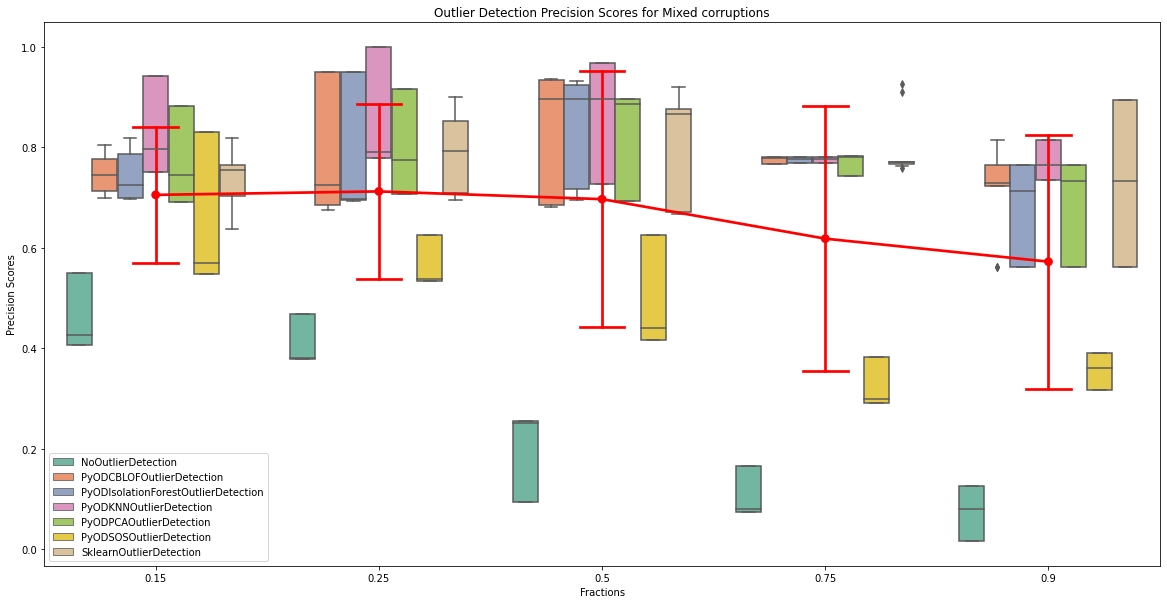

In [66]:
sns.boxplot(x='fraction', y='value', data=df_od_prec, hue='od_method', palette="Set2")
sns.pointplot(x='fraction', y='value', data=df_od_prec, ci="sd", capsize=0.2, color="red")
plt.xlabel("Fractions")
plt.ylabel("Precision Scores")
plt.title("Outlier Detection Precision Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [44]:
df_od_rec = getDfForPlots(od_recalls, od_methods, 'od_method')
df_od_rec

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fraction                od_method     value
0        0.15       NoOutlierDetection  0.500000
1        0.15       NoOutlierDetection  0.500000
2        0.15       NoOutlierDetection  0.500000
3        0.15       NoOutlierDetection  0.625000
4        0.15       NoOutlierDetection  0.625000
..        ...                      ...       ...
310      0.90  SklearnOutlierDetection  0.666336
311      0.90  SklearnOutlierDetection  0.722222
312      0.90  SklearnOutlierDetection  0.898810
313      0.90  SklearnOutlierDetection  0.898810
314      0.90  SklearnOutlierDetection  0.898810

[315 rows x 3 columns]

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


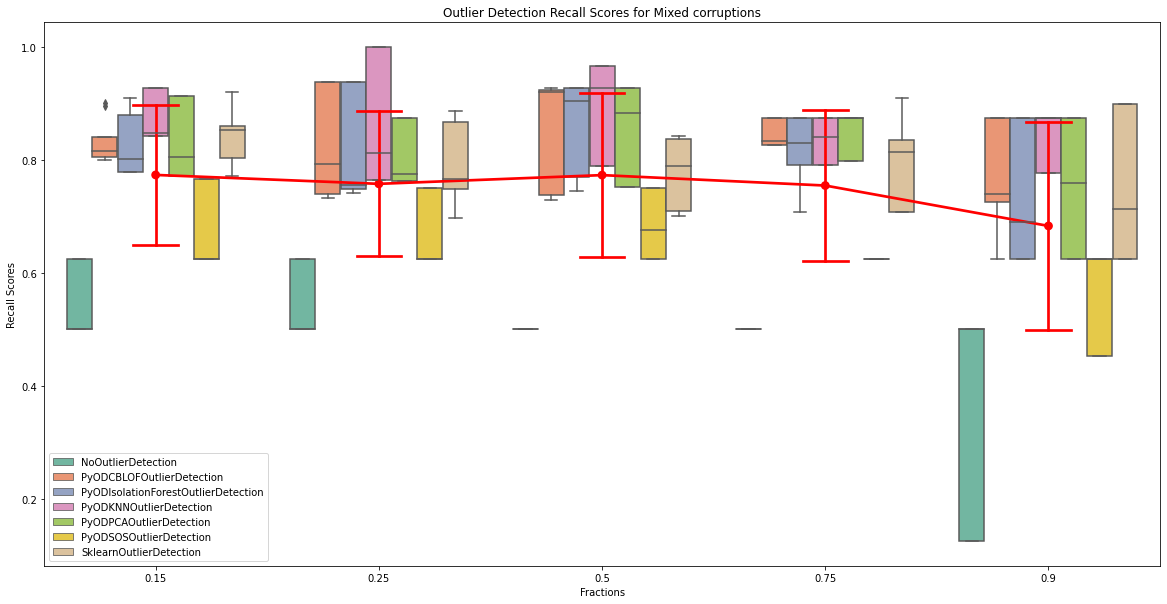

In [67]:
sns.boxplot(x='fraction', y='value', data=df_od_rec, hue='od_method', palette="Set2")
sns.pointplot(x='fraction', y='value', data=df_od_rec, ci="sd", capsize=0.2, color="red")
plt.xlabel("Fractions")
plt.ylabel("Recall Scores")
plt.title("Outlier Detection Recall Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [ ]:
## imputation

In [46]:
df_imp_prec = getDfForPlots(imp_precisions, imp_methods, 'imp_method')
df_imp_prec

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fraction         imp_method     value
0        0.15  DatawigImputation  0.836378
1        0.15  DatawigImputation  0.839557
2        0.15  DatawigImputation  0.842827
3        0.15  DatawigImputation  0.842827
4        0.15  DatawigImputation  0.842827
..        ...                ...       ...
310      0.90  SklearnImputation  0.214286
311      0.90  SklearnImputation  0.214286
312      0.90  SklearnImputation  0.214286
313      0.90  SklearnImputation  0.214286
314      0.90  SklearnImputation  0.413043

[315 rows x 3 columns]

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


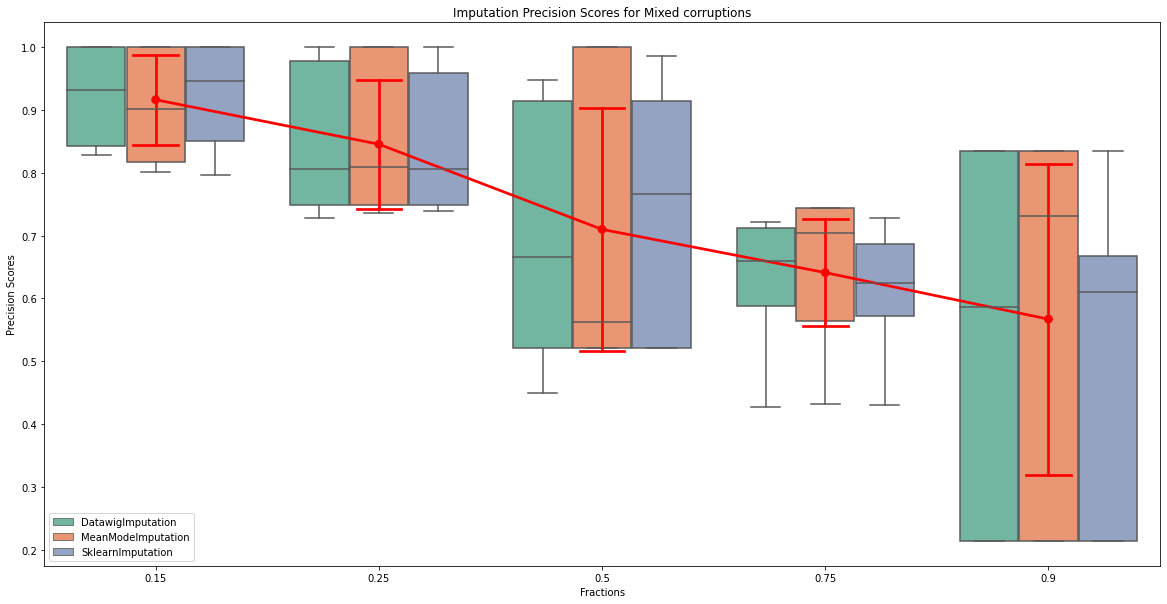

In [68]:
sns.boxplot(x='fraction', y='value', data=df_imp_prec, hue='imp_method', palette="Set2")
sns.pointplot(x='fraction', y='value', data=df_imp_prec, ci="sd", capsize=0.2, color="red")
plt.xlabel("Fractions")
plt.ylabel("Precision Scores")
plt.title("Imputation Precision Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [48]:
df_imp_rec = getDfForPlots(imp_recalls, imp_methods, 'imp_method')
df_imp_rec

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fraction         imp_method     value
0        0.15  DatawigImputation  0.887736
1        0.15  DatawigImputation  0.896357
2        0.15  DatawigImputation  0.904977
3        0.15  DatawigImputation  0.904977
4        0.15  DatawigImputation  0.904977
..        ...                ...       ...
310      0.90  SklearnImputation  0.275000
311      0.90  SklearnImputation  0.275000
312      0.90  SklearnImputation  0.275000
313      0.90  SklearnImputation  0.275000
314      0.90  SklearnImputation  0.475000

[315 rows x 3 columns]

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


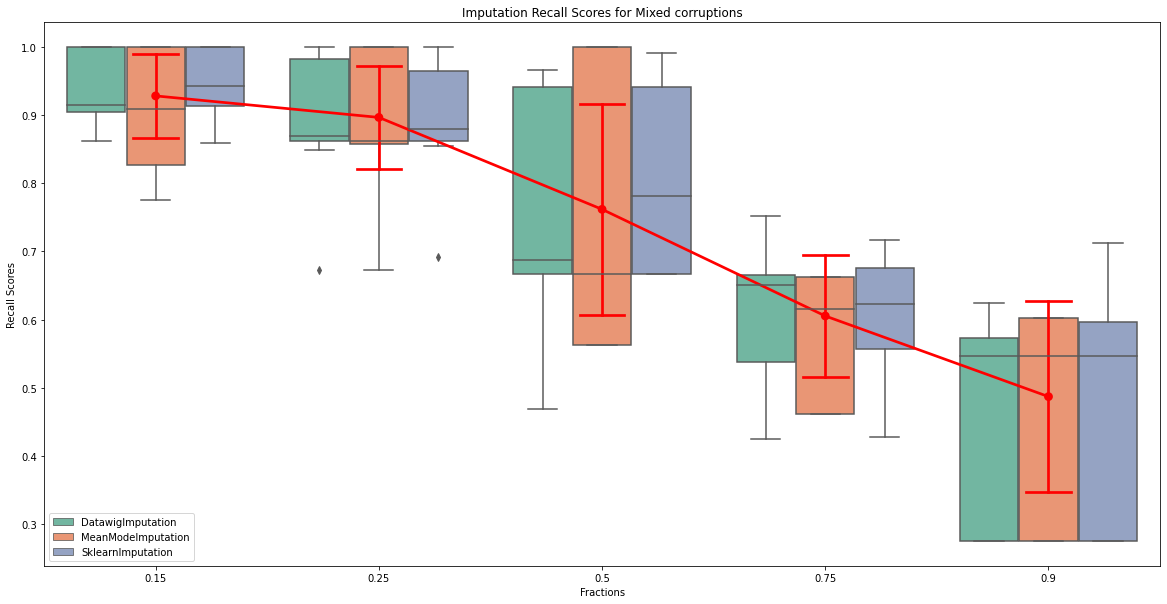

In [69]:
sns.boxplot(x='fraction', y='value', data=df_imp_rec, hue='imp_method', palette="Set2")
sns.pointplot(x='fraction', y='value', data=df_imp_rec, ci="sd", capsize=0.2, color="red")
plt.xlabel("Fractions")
plt.ylabel("Recall Scores")
plt.title("Imputation Recall Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

In [ ]:
### autogluon

In [121]:
results_autoguon = ind_results.copy()
results_autoguon

{0.15: [{'dataset': 'thoracic_surgery',
   'model': None,
   'corruptions': defaultdict(list,
               {('PRE30',): [MissingValues: {'column': 'PRE30', 'fraction': 0.15, 'sampling': 'MAR', 'na_value': nan},
                 CategoricalShift: {'column': 'PRE30', 'fraction': 0.15, 'sampling': 'MCAR'}],
                ('PRE5',): [Scaling: {'column': 'PRE5', 'fraction': 0.15, 'sampling': 'MNAR'}],
                ('AGE',): [GaussianNoise: {'column': 'AGE', 'fraction': 0.15, 'sampling': 'MCAR'}]}),
   'cleaners': [{'Outlier detection method': NoOutlierDetection,
     'Outlier Detection Score': {'Precision': 0.39095744680851063,
      'Recall': 0.5,
      'F1-score': 0.43795959163275505,
      'Accuracy': 0.7819148936170213},
     'Imputation method': MeanModeImputation,
     'Imputation Score': {'Precision': 0.7062643239113827,
      'Recall': 0.6973684210526316,
      'F1-score': 0.7015873015873015,
      'Accuracy': 0.8191489361702128,
      'Mean Squared Error': 5966.964512384013}

In [122]:
od_precisions_a = getMethodMetrics(results_autoguon, 'Outlier Detection Score', 'Precision')
od_precisions_a

{0.15: [0.39095744680851063,
  0.39095744680851063,
  0.8822973995597139,
  0.8822973995597139,
  0.8070462164750958,
  0.8034564393939394,
  0.7919021950271949,
  0.7919021950271949,
  0.8213830587293702,
  0.8171735312899107,
  0.6721409574468085,
  0.6721409574468085,
  0.7997616248693835,
  0.721588612579569,
  0.39344262295081966,
  0.39344262295081966,
  0.836169676514421,
  0.836169676514421,
  0.7473525840208579,
  0.7188409268327302,
  0.736675911531939,
  0.736675911531939,
  0.722936687394008,
  0.7418387623305656,
  0.5368852459016393,
  0.5368852459016393,
  0.7765573770491804,
  0.7315573770491803,
  0.40625,
  0.40625,
  0.796875,
  0.796875,
  0.7457386363636364,
  0.7457386363636364,
  0.7247596153846154,
  0.7247596153846154,
  0.7457386363636364,
  0.7457386363636364,
  0.546875,
  0.546875,
  0.7911931818181819,
  0.7815777972027973,
  0.39095744680851063,
  0.39095744680851063,
  0.8826841787439614,
  0.8826841787439614,
  0.8072518438509209,
  0.8158867122719735,


### Boxplot

In [123]:
df_od_prec_a = pd.DataFrame.from_dict(od_precisions_a, orient='index', columns=od_methods * int(len(od_precisions_a[next(iter(od_precisions_a))])/len(od_methods)))
df_od_prec_a.insert(loc=0, column="fraction", value=df_od_prec_a.index)

df_od_prec_a = pd.melt(df_od_prec_a, id_vars=['fraction'], var_name='od_method').sort_values(by=["fraction", "od_method"])
df_od_prec_a.reset_index(inplace=True, drop=True)

df_od_prec_a

fraction                od_method     value
0        0.15       NoOutlierDetection  0.390957
1        0.15       NoOutlierDetection  0.390957
2        0.15       NoOutlierDetection  0.393443
3        0.15       NoOutlierDetection  0.393443
4        0.15       NoOutlierDetection  0.406250
..        ...                      ...       ...
415      0.90  SklearnOutlierDetection  0.547397
416      0.90  SklearnOutlierDetection  0.899425
417      0.90  SklearnOutlierDetection  0.924342
418      0.90  SklearnOutlierDetection  0.869318
419      0.90  SklearnOutlierDetection  0.875000

[420 rows x 3 columns]

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


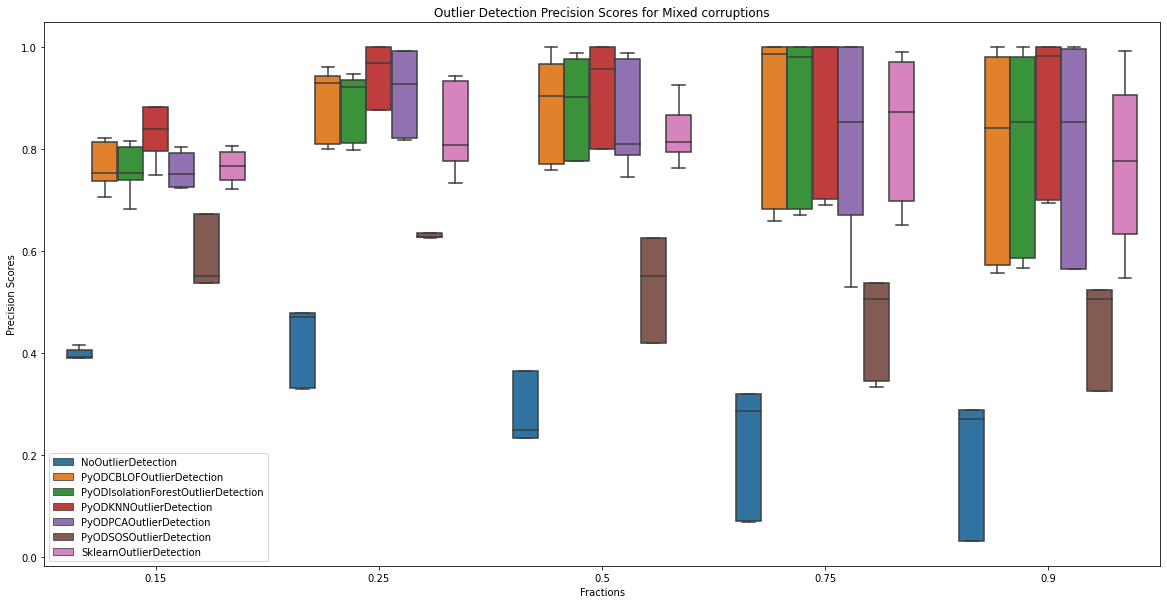

In [124]:
sns.boxplot(x='fraction', y='value', data=df_od_prec_a, hue='od_method')
plt.xlabel("Fractions")
plt.ylabel("Precision Scores")
plt.title("Outlier Detection Precision Scores for Mixed corruptions")
plt.legend(loc='lower left')

plt.show()

### Extras

In [50]:
results_dict = ind_results.copy()

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
fracs = []

od_methods = []
od_precisions = []
od_recalls = []
od_f1scores = []
od_accuracy = []

for frac in results_dict.keys():
    for i in range(len(results_dict[frac])):
        for j in range(len(results_dict[frac][i]['cleaners'])):
            fracs.append(frac)
            od_methods.append(results_dict[frac][i]['cleaners'][j]['Outlier detection method'])
            od_precisions.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['Precision'])
            od_recalls.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['Recall'])
            od_f1scores.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['F1-score'])
            od_accuracy.append(results_dict[frac][i]['cleaners'][j]['Outlier Detection Score']['Accuracy'])
            
df_od = pd.DataFrame({
    'fraction': fracs, 
    'od_method': od_methods, 
    'od_precision': od_precisions, 
    'od_recall': od_recalls,
    'od_f1-score': od_f1scores,
    'od_accuracy': od_accuracy
})

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
df_od['od_method'] = df_od['od_method'].astype('category')

/home/rupali/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'od_precision'}, xlabel='[fraction]'>

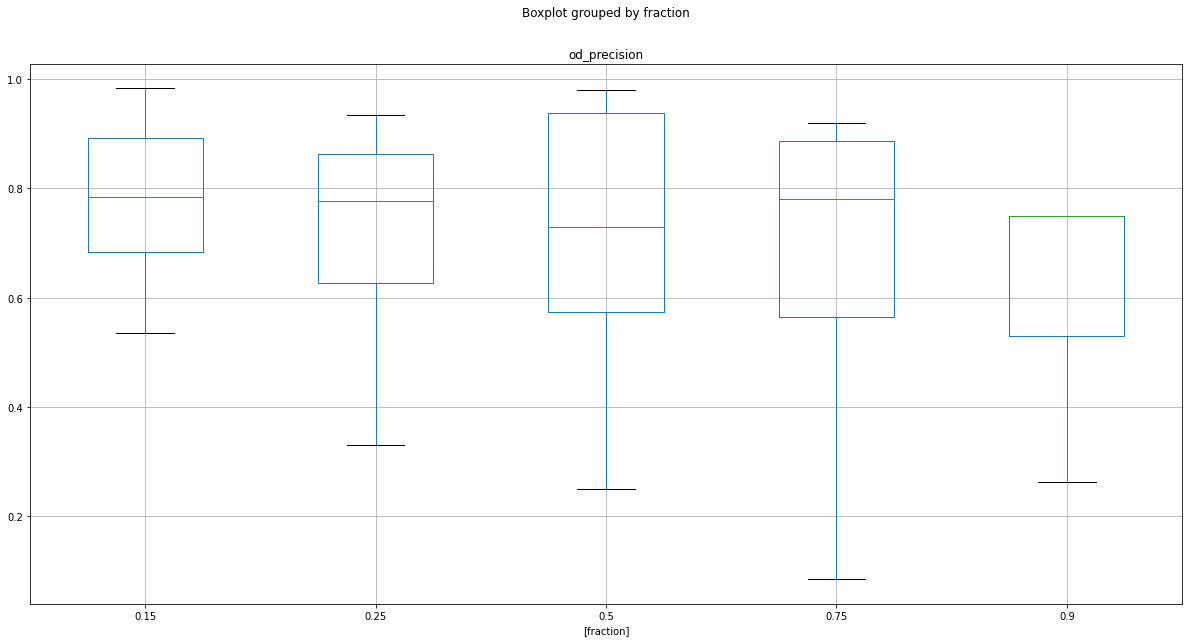

In [154]:
df.boxplot(column=['od_precision'], by=['fraction'])

In [128]:
fracs = []

imp_methods = []
imp_precisions = []
imp_recalls = []
imp_f1scores = []
imp_accuracy = []

for frac in results_dict.keys():
    for i in range(len(results_dict[frac])):
        for j in range(len(results_dict[frac][i]['cleaners'])):
            fracs.append(frac)
            
            imp_methods.append(results_dict[frac][i]['cleaners'][j]['Imputation method'])
            imp_precisions.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['Precision'])
            imp_recalls.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['Recall'])
            imp_f1scores.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['F1-score'])
            imp_accuracy.append(results_dict[frac][i]['cleaners'][j]['Imputation Score']['Accuracy'])
            
df_imp = pd.DataFrame({
    'fraction': fracs,
    'imp_method': imp_methods, 
    'imp_precision': imp_precisions, 
    'imp_recall': imp_recalls,
    'imp_f1-score': imp_f1scores,
    'imp_accuracy': imp_accuracy
})

In [129]:
fracs = []

models = []
roc_auc_scores = []
model_accuracy = []

for frac in results_dict.keys():
    for i in range(len(results_dict[frac])):
        for j in range(len(results_dict[frac][i]['cleaners'])):
            fracs.append(frac)
            
            models.append(ind_results[frac][i]['model'])
            roc_auc_scores.append(ind_results[frac][i]['cleaners'][j]['PPP score with cleaning']['roc_auc_score'])
            model_accuracy.append(ind_results[frac][i]['cleaners'][j]['PPP score with cleaning']['classification_report']['accuracy'])
            
df_model = pd.DataFrame({
    'fraction': fracs, 
    'model': models,
    'roc_auc_score': roc_auc_scores,
    'model_accuracy': model_accuracy
})